In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import re
from functools import reduce

In [2]:
data_path = '/project2/kribelba_1515/saadawy/mpra/downstream'
enhancer_bc_counts = pd.read_csv('enhancer_barcode_count_downstream.tsv', sep='\t')
mpra_raw_data = pd.read_csv('df_for_mpra_downstream.tsv', sep='\t')

In [3]:
csv_files = [file for file in os.listdir(data_path) if file.endswith('.csv')]

df_list = []

for file in csv_files:
    file_path = os.path.join(data_path, file)

    match = re.search(r'(agg_[^_]+_norm_[^_]+)', file)

    identifier = match.group(1)

    df = pd.read_csv(file_path, usecols=['logFC', 'SE', 'uid'])

    df = df.rename(columns={
        'logFC': f'logFC_{identifier}',
        'SE': f'SE_{identifier}'
    })

    df_list.append(df)

merged_df = reduce(lambda left, right: pd.merge(left, right, on='uid'), df_list)

merged_df = merged_df[[c for c in merged_df.columns if c != 'uid'] + ['uid']]

merged_df = merged_df.rename(columns={'uid': 'Enhancer'})

merged_df = pd.merge(merged_df, enhancer_bc_counts, on='Enhancer')

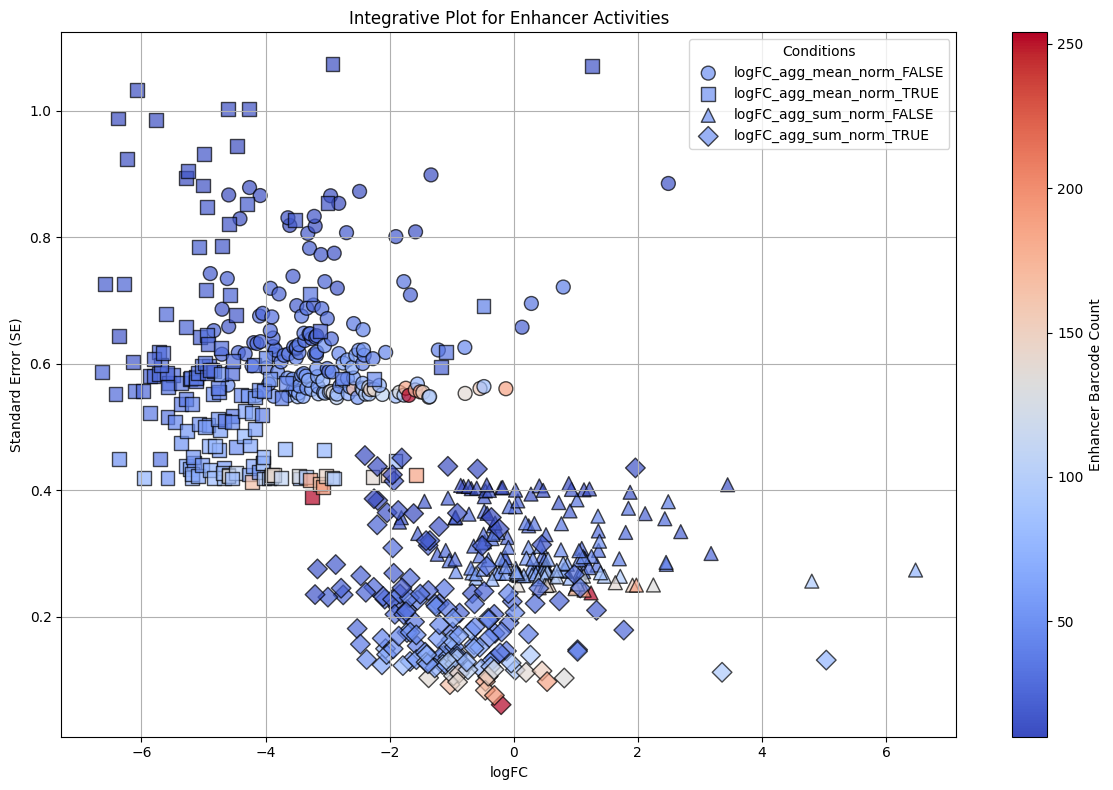

In [5]:
conditions = [
    'logFC_agg_mean_norm_FALSE', 'logFC_agg_mean_norm_TRUE',
    'logFC_agg_sum_norm_FALSE', 'logFC_agg_sum_norm_TRUE'
]

se_conditions = [
    'SE_agg_mean_norm_FALSE', 'SE_agg_mean_norm_TRUE',
    'SE_agg_sum_norm_FALSE', 'SE_agg_sum_norm_TRUE'
]

logFC_data = merged_df[conditions]
SE_data = merged_df[se_conditions]
enhancers = merged_df['Enhancer']
barcode_counts = merged_df['Enhancer_barcode_count']

plt.figure(figsize=(12, 8))

norm = plt.Normalize(barcode_counts.min(), barcode_counts.max())
cmap = plt.get_cmap('coolwarm')
markers = ['o', 's', '^', 'D']

for i, condition in enumerate(conditions):
    plt.scatter(
        logFC_data.iloc[:, i], SE_data.iloc[:, i],
        c=barcode_counts, cmap=cmap, norm=norm,
        label=condition, edgecolors='black', alpha=0.7,
        s=100, marker=markers[i]
    )

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=plt.gca())
cbar.set_label('Enhancer Barcode Count')

plt.xlabel('logFC')
plt.ylabel('Standard Error (SE)')
plt.title('Integrative Plot for Enhancer Activities')

plt.grid(True)
plt.legend(title='Conditions', loc='best')

plt.tight_layout()
plt.show()

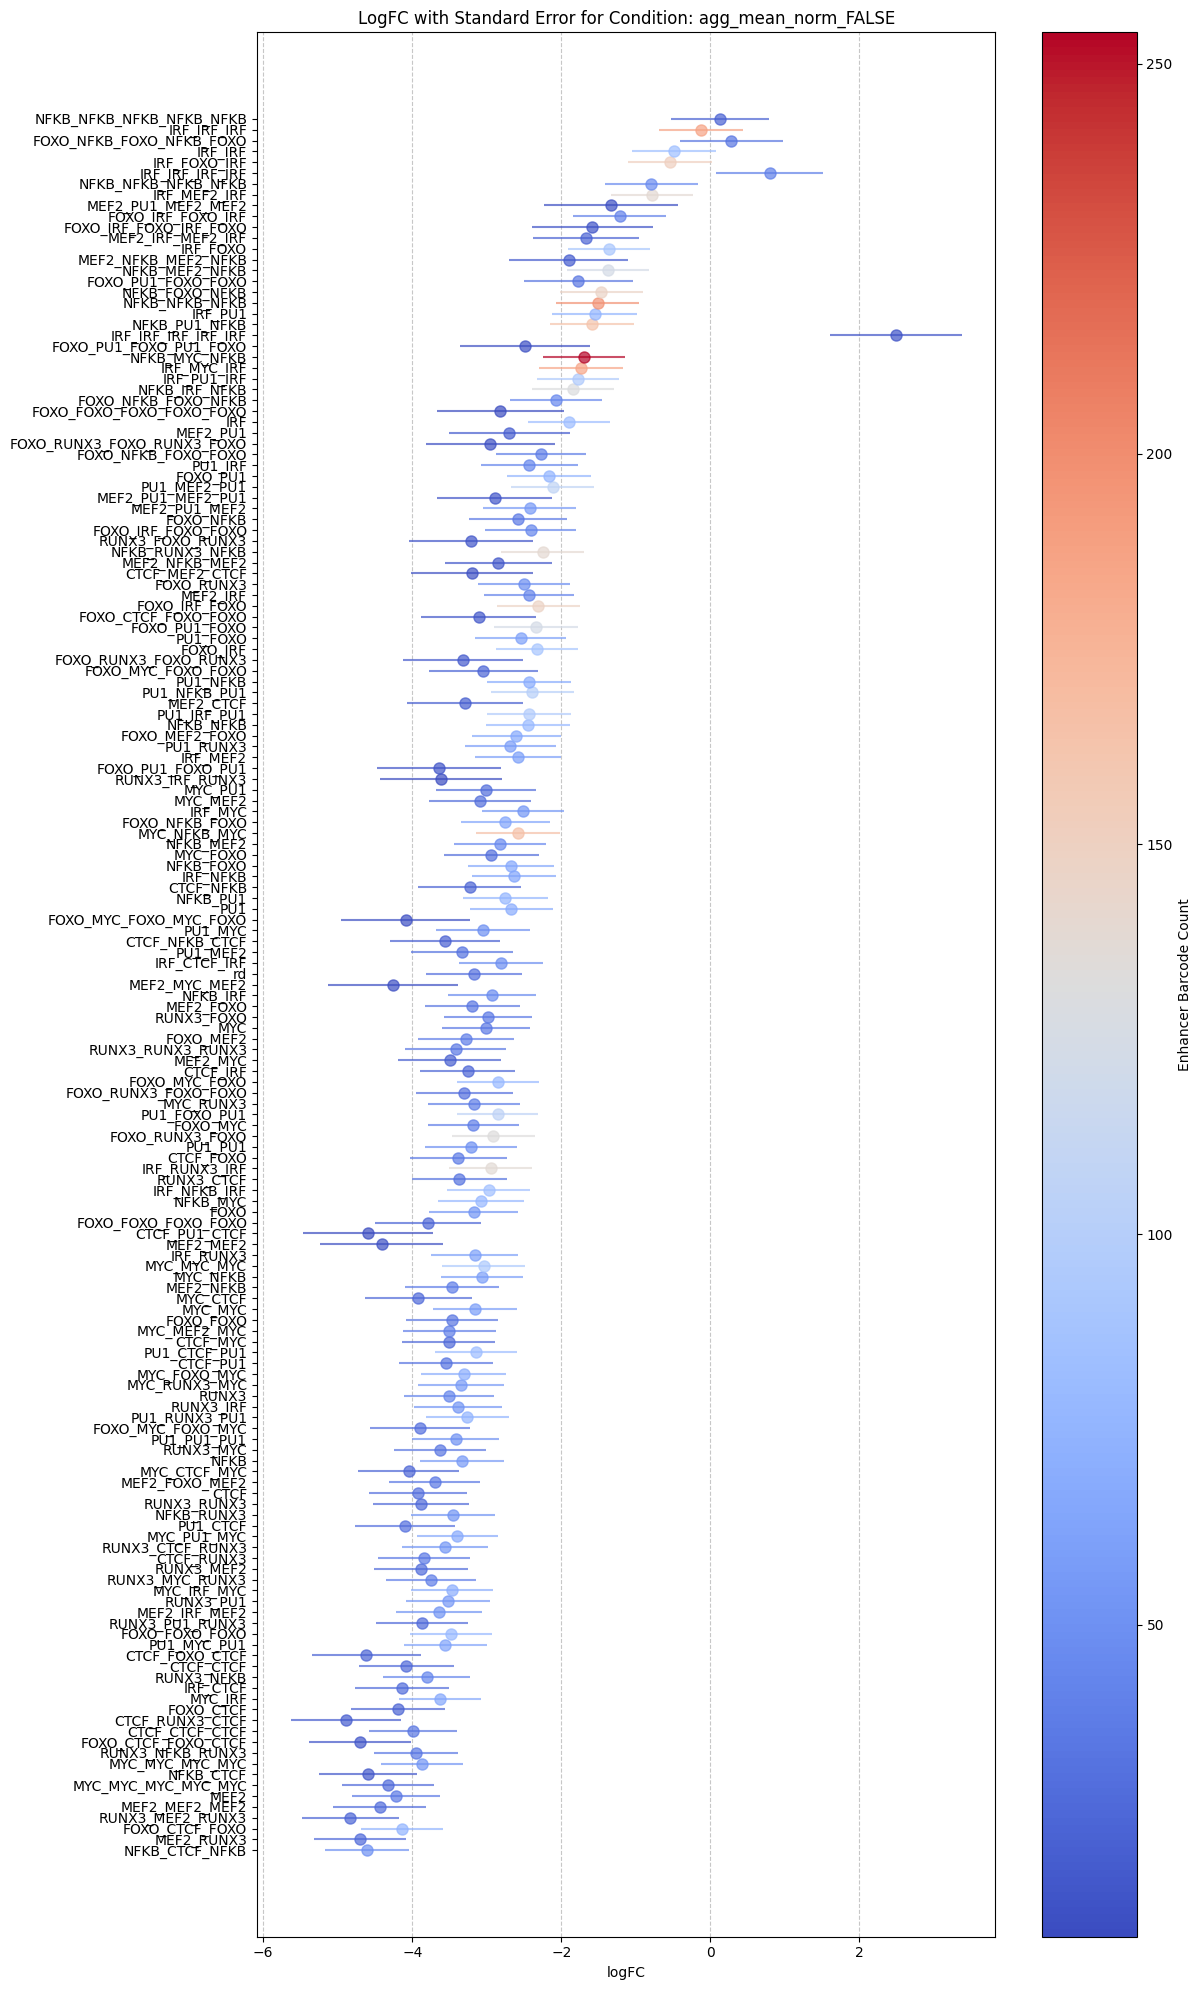

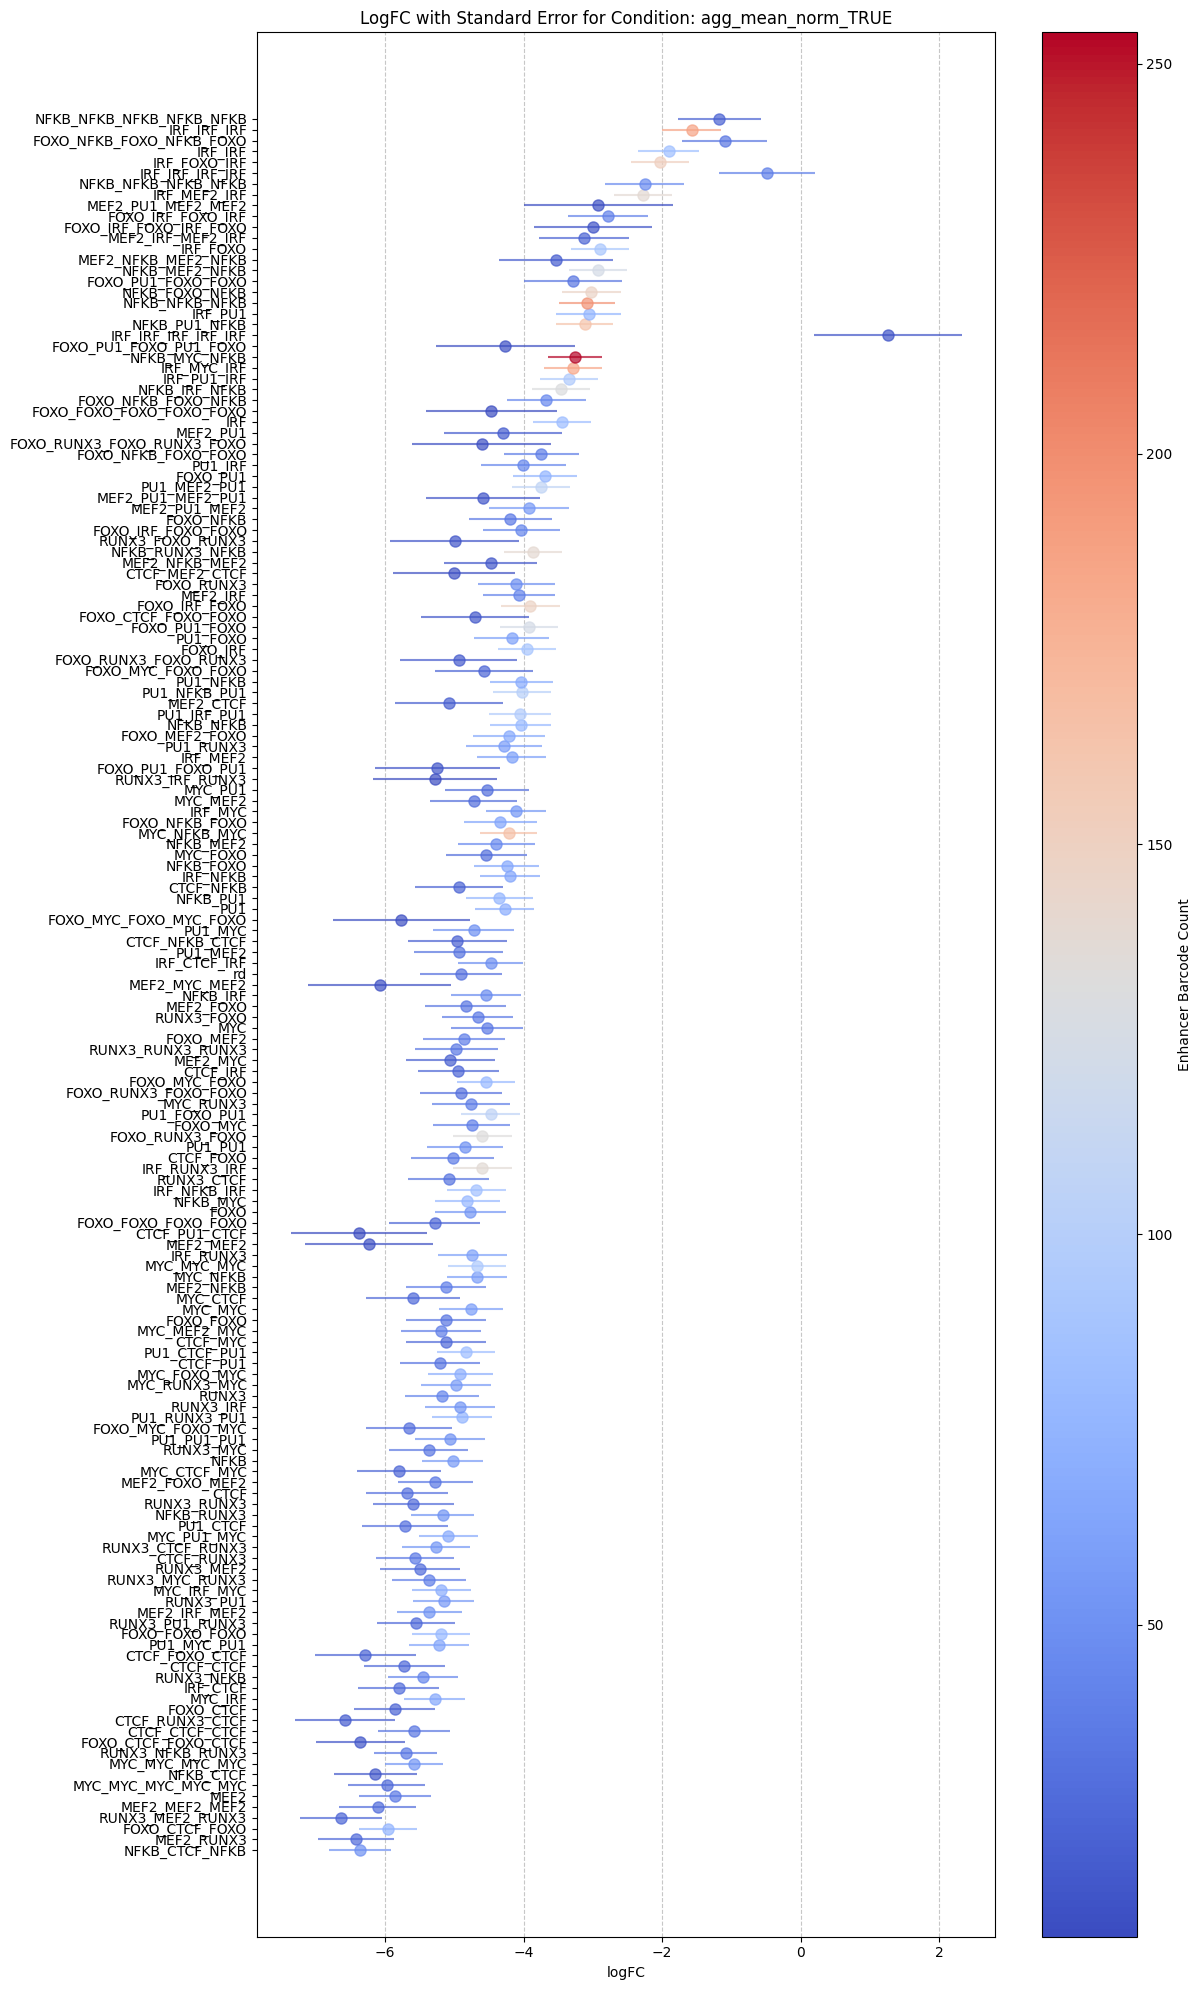

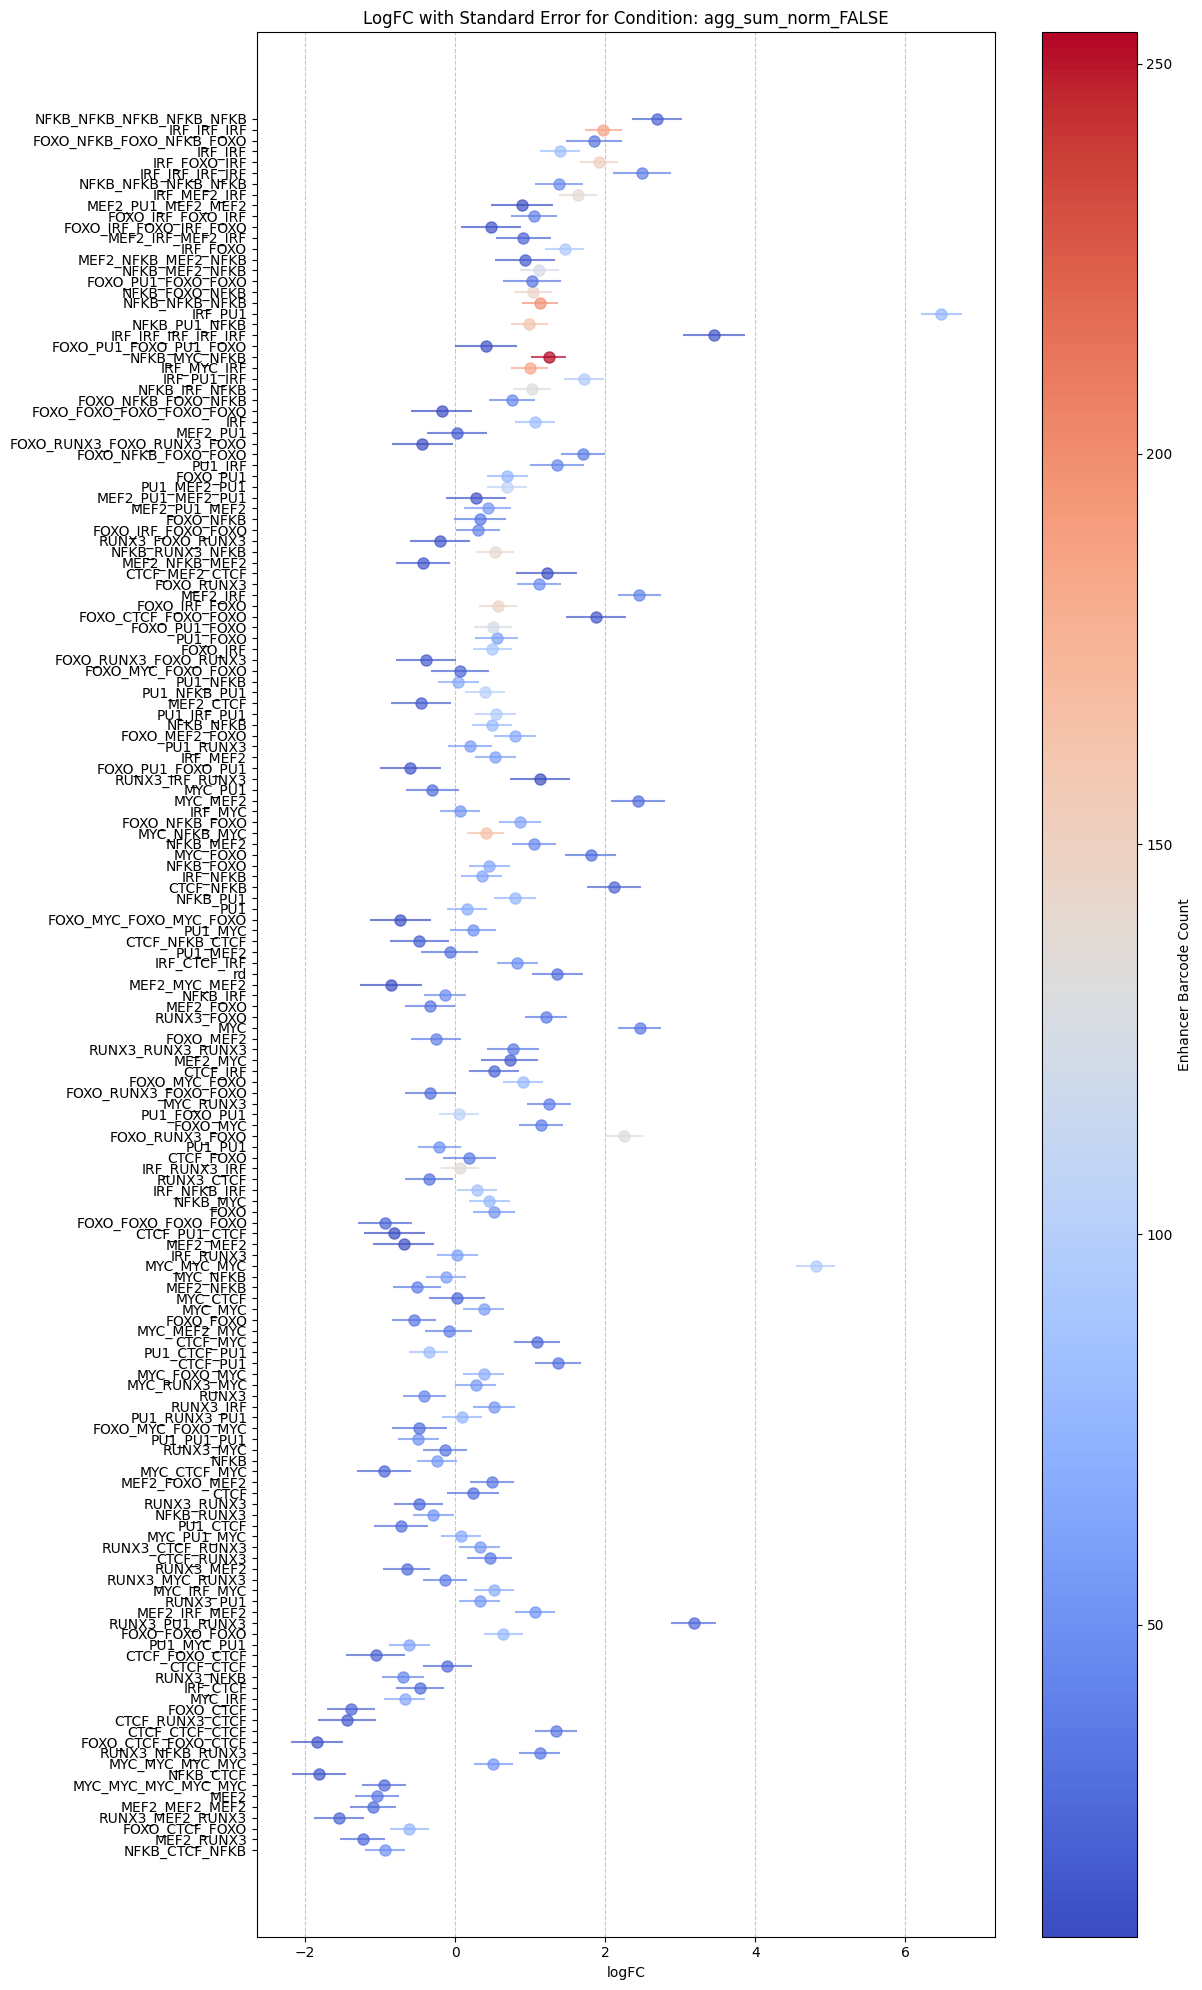

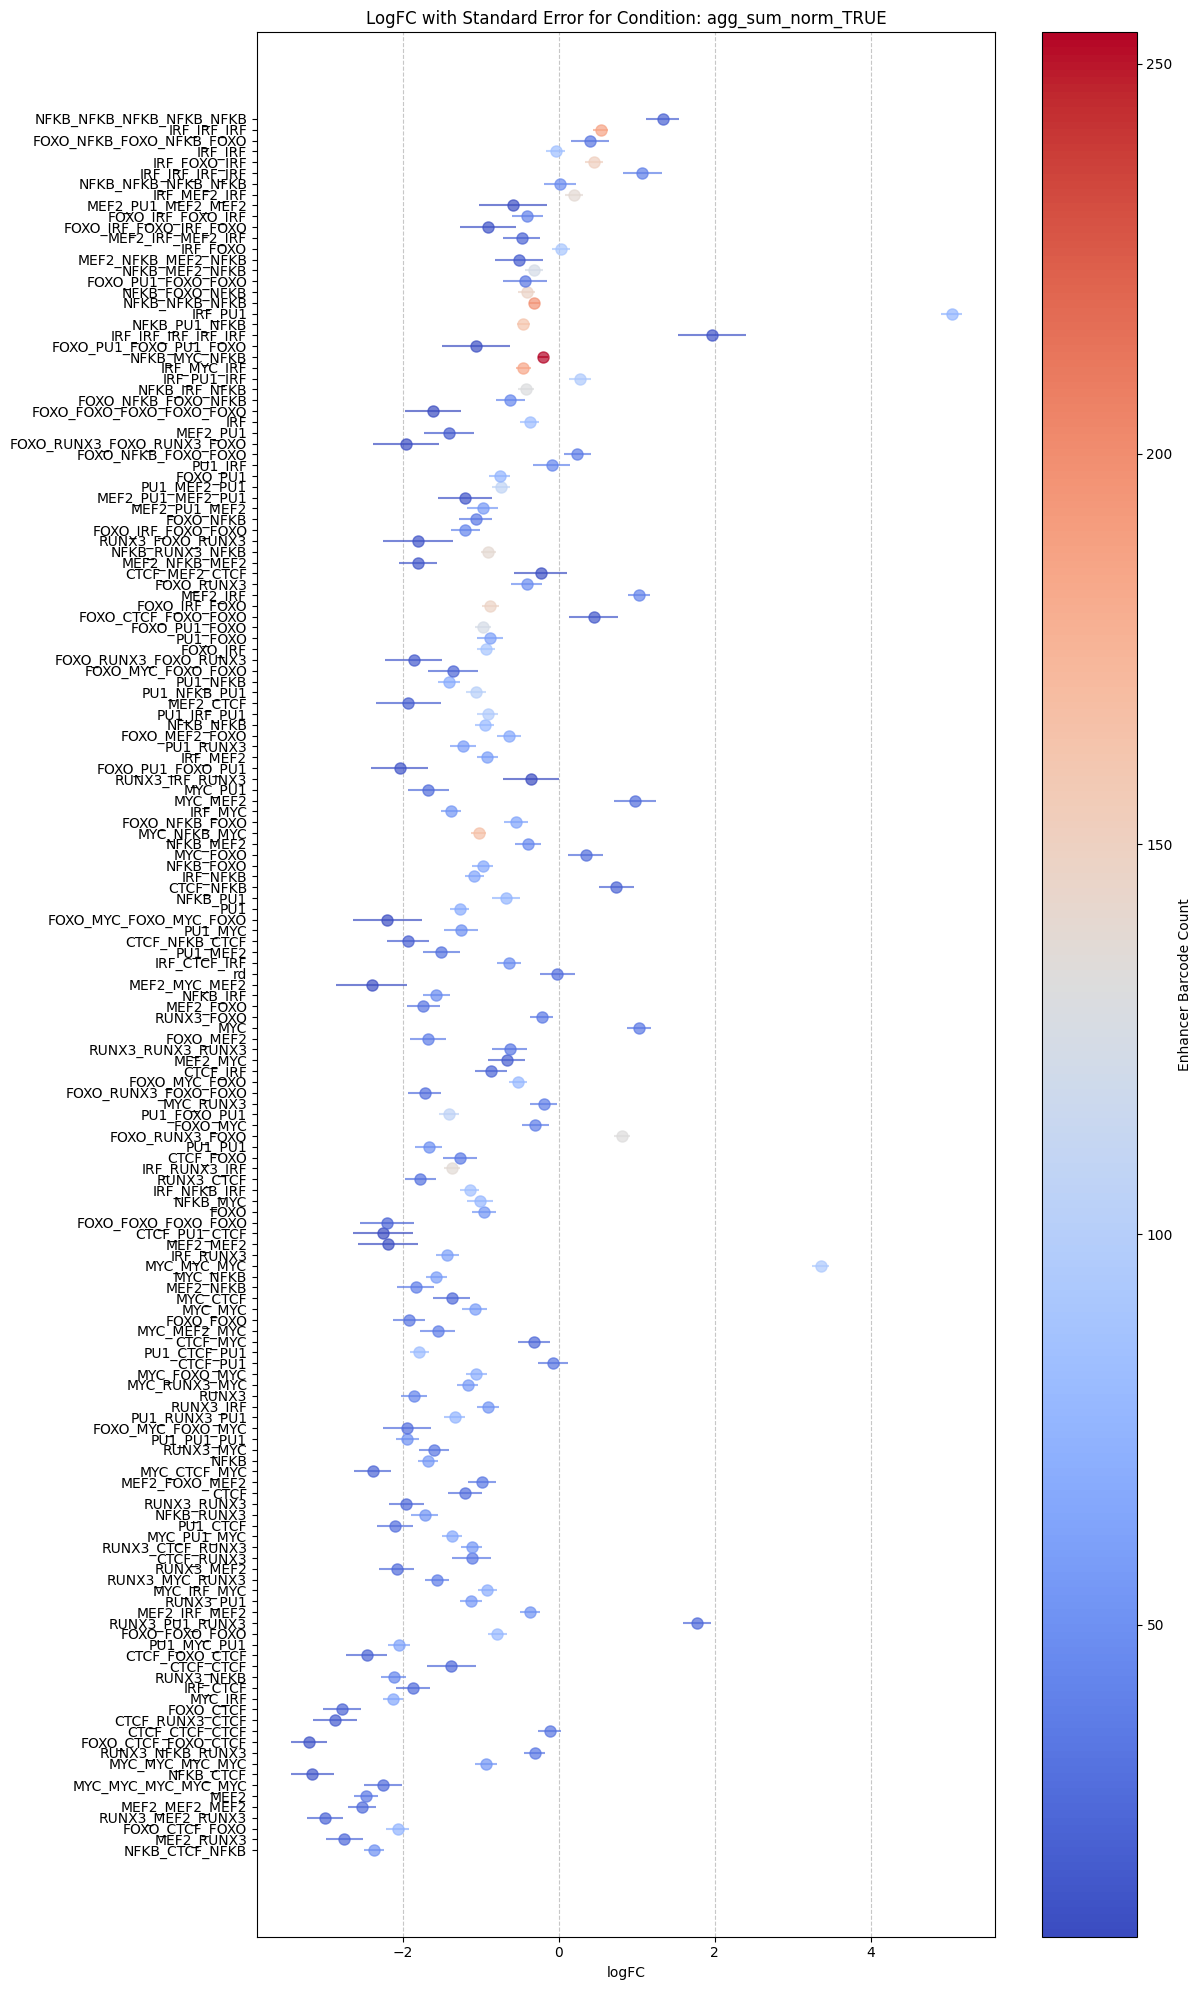

In [10]:
conditions = ['agg_mean_norm_FALSE', 'agg_mean_norm_TRUE', 
              'agg_sum_norm_FALSE', 'agg_sum_norm_TRUE']

for i, condition in enumerate(conditions):
    plt.figure(figsize=(12, 20))

    logFC_values = merged_df[f'logFC_{condition}']
    SE_values = merged_df[f'SE_{condition}']
    
    lower_bound = logFC_values - SE_values
    upper_bound = logFC_values + SE_values
    
    colors = cmap(norm(merged_df['Enhancer_barcode_count']))

    for idx in range(len(merged_df)):
        plt.errorbar(
            logFC_values.iloc[idx], idx,  # x-coordinate: logFC value, y-coordinate: index of enhancer
            xerr=[[logFC_values.iloc[idx] - lower_bound.iloc[idx]], [upper_bound.iloc[idx] - logFC_values.iloc[idx]]],  # Horizontal error bars
            fmt='o',  # Marker type: dot
            color=colors[idx],  # Color by barcode count
            markersize=8,  # Size of the dots
            alpha=0.7  # Transparency of dots
        )
    
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=plt.gca())
    cbar.set_label('Enhancer Barcode Count')

    plt.xlabel('logFC')
    plt.title(f'LogFC with Standard Error for Condition: {condition}')
    
    plt.yticks(np.arange(len(merged_df)), merged_df['Enhancer'])
    
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)

    plot_filename = f"{condition}_logFC_with_SE_horizontal.png"
    plt.tight_layout()
    # plt.save_fig(plot_filename)
    plt.show()
    plt.close()

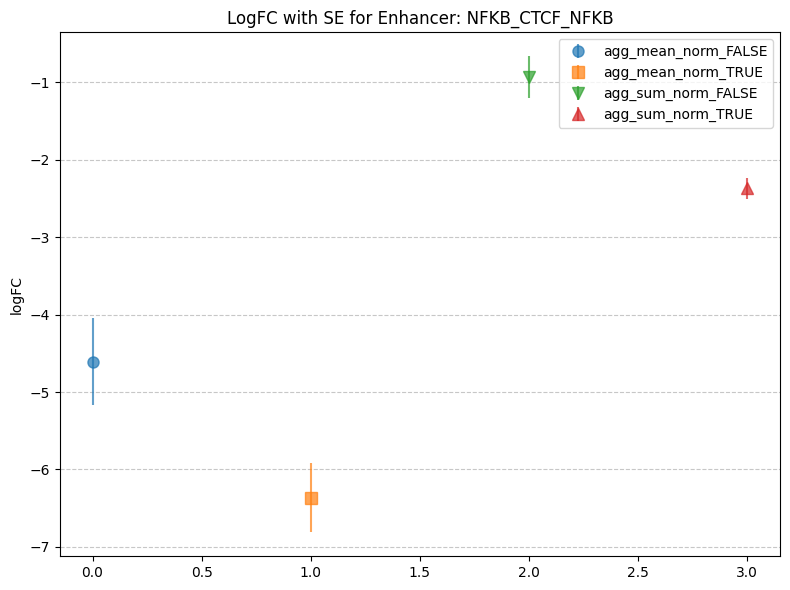

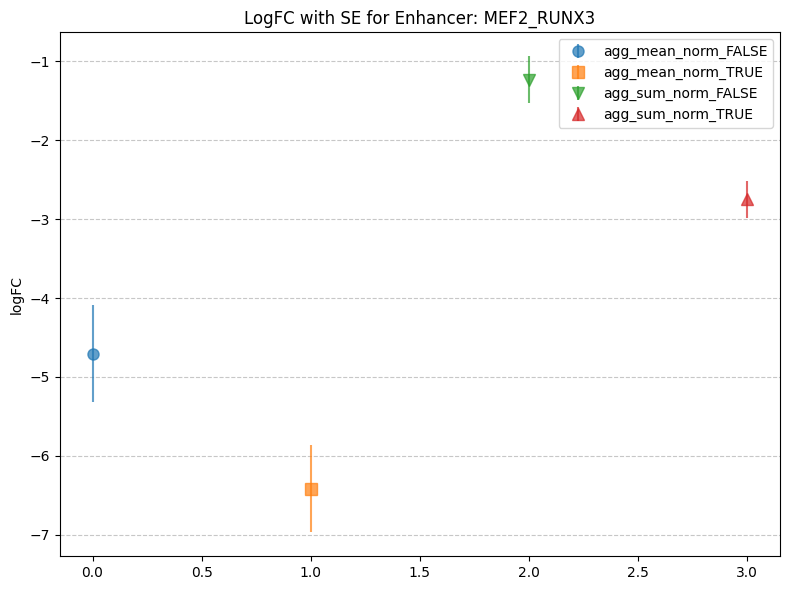

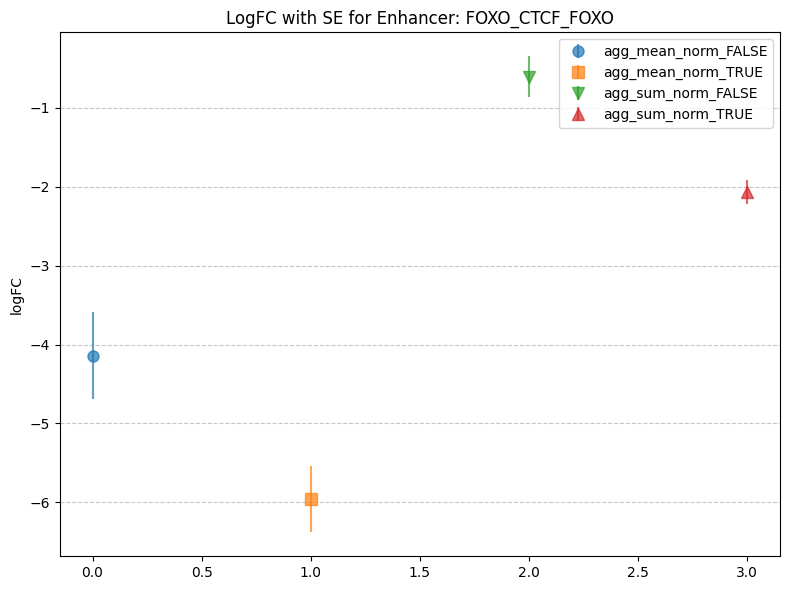

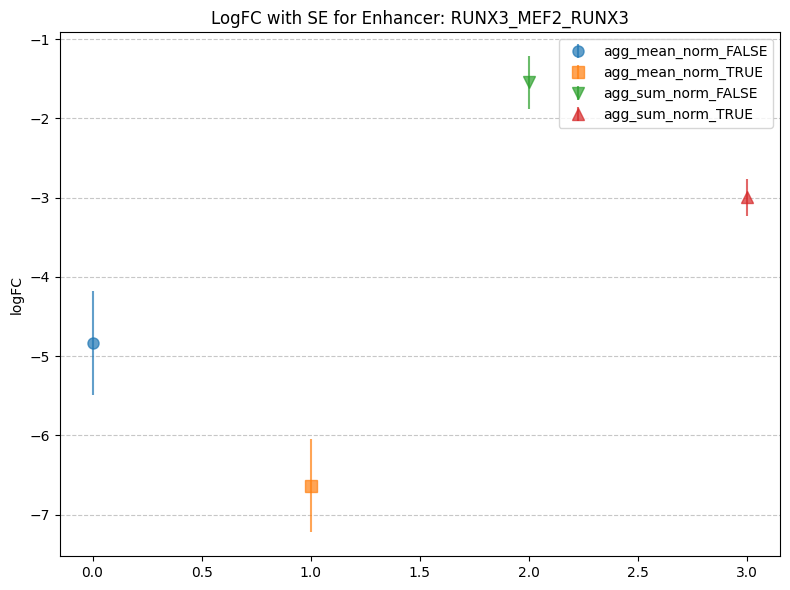

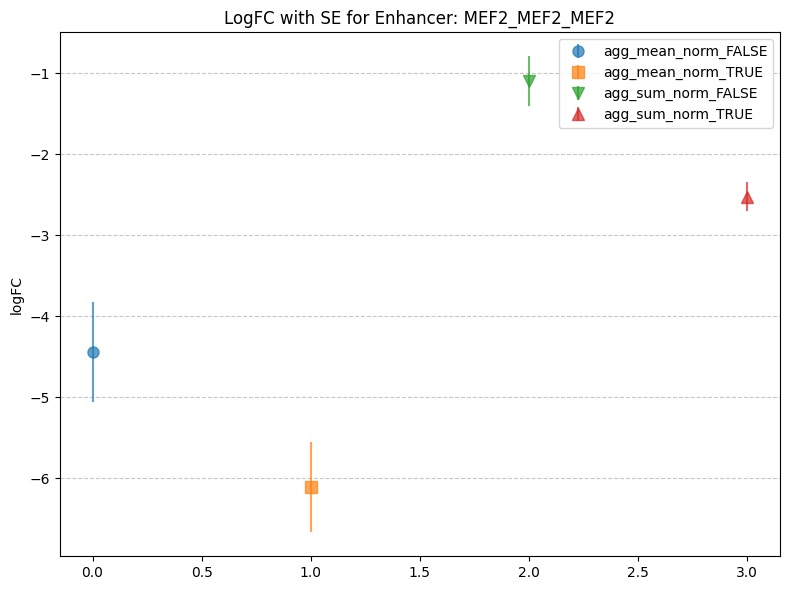

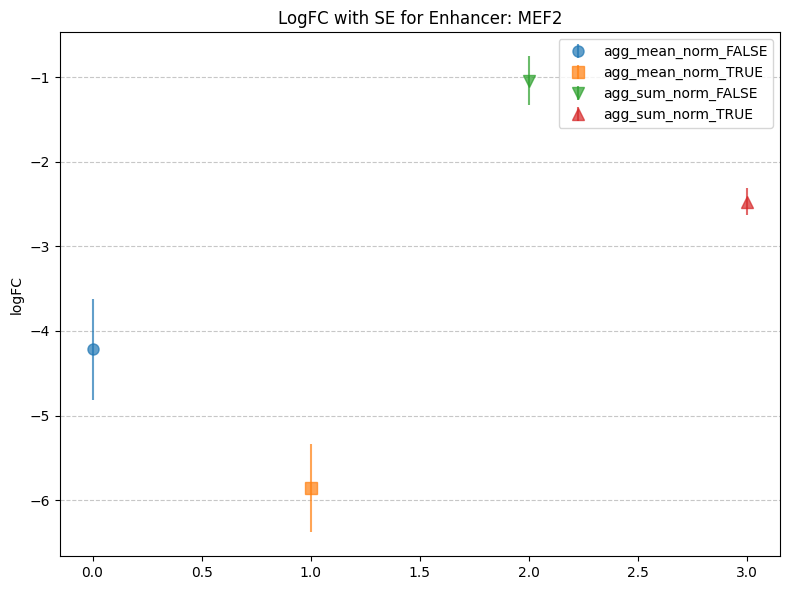

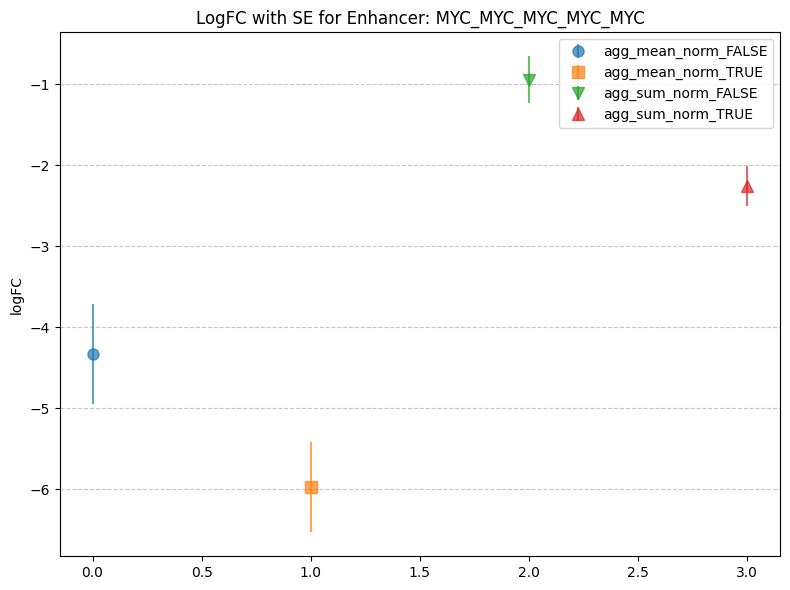

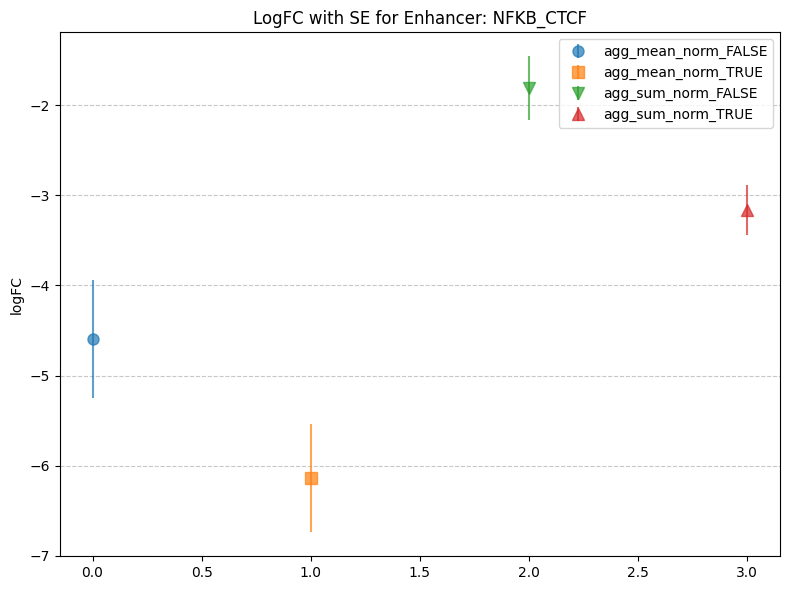

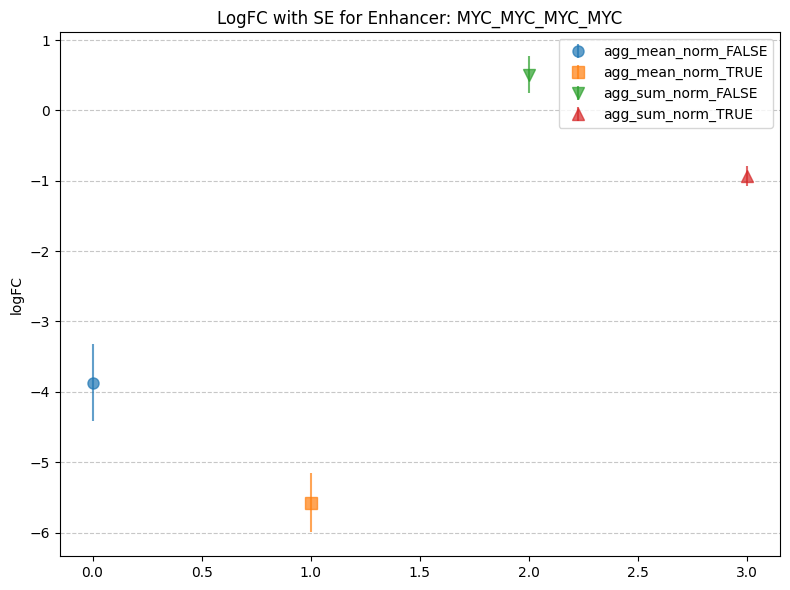

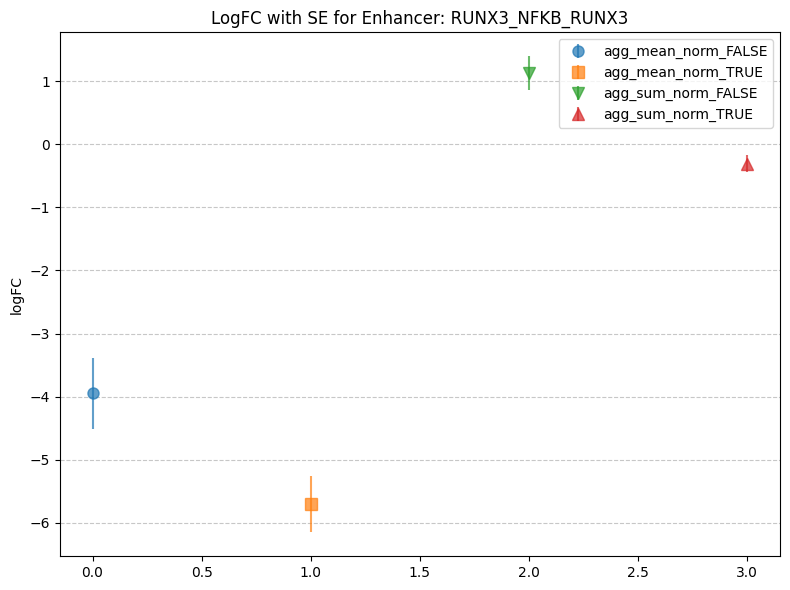

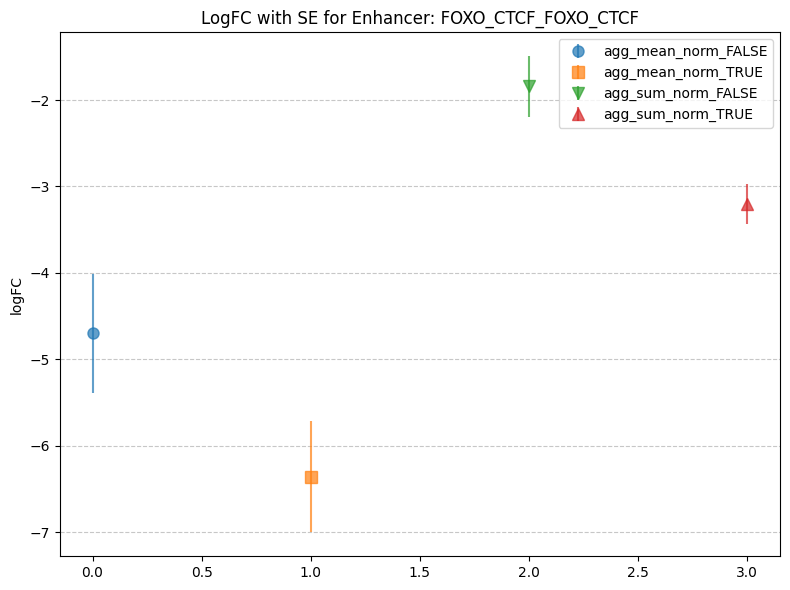

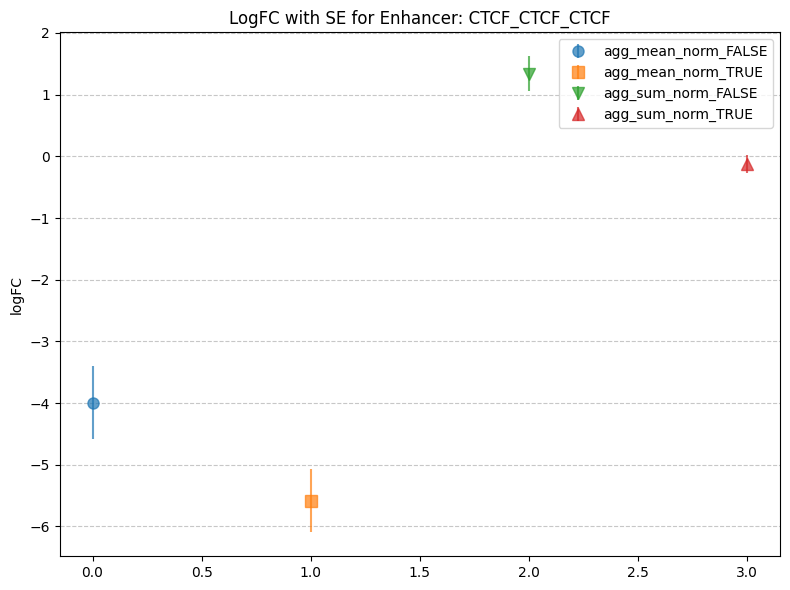

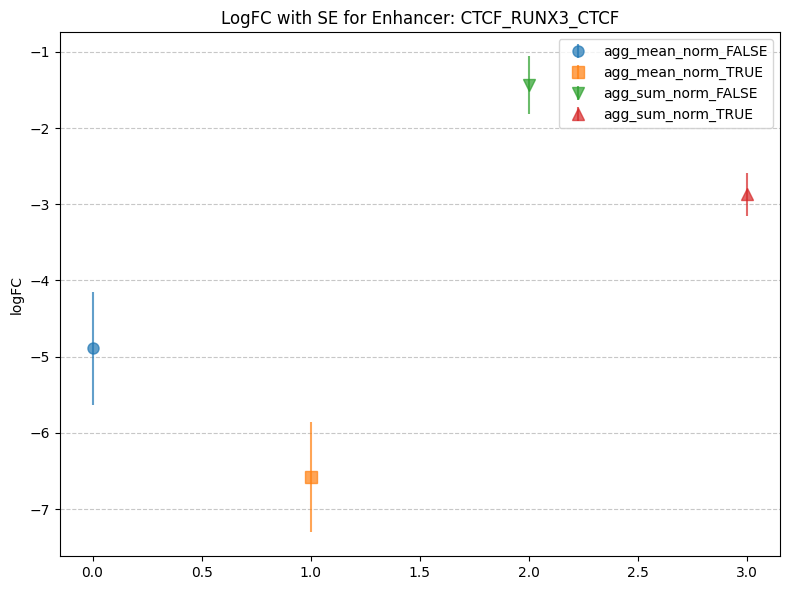

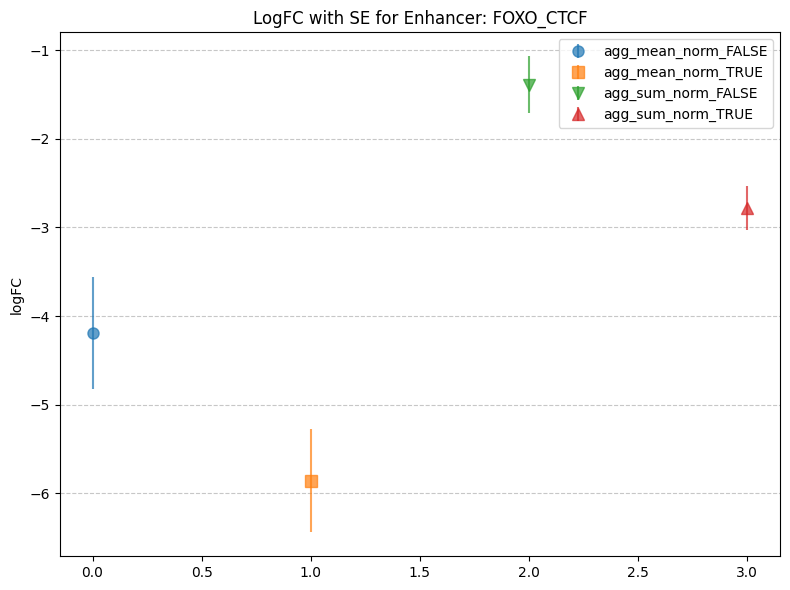

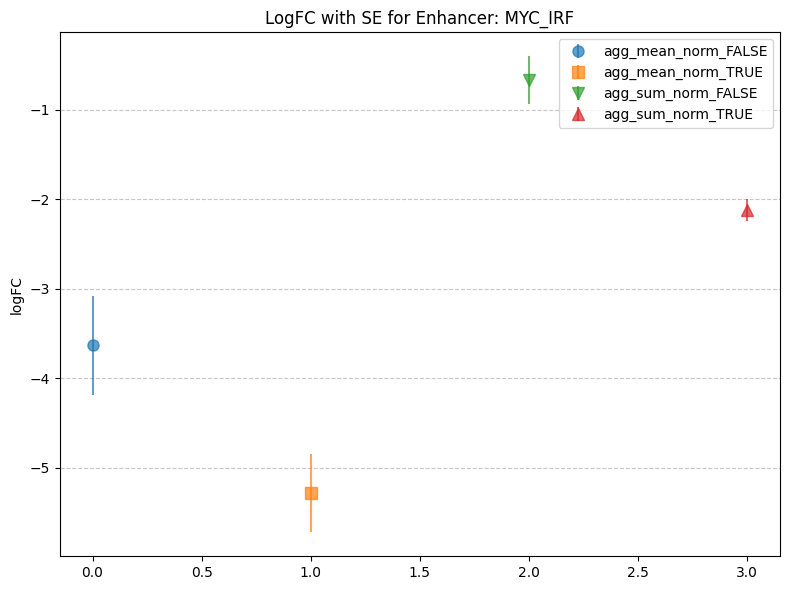

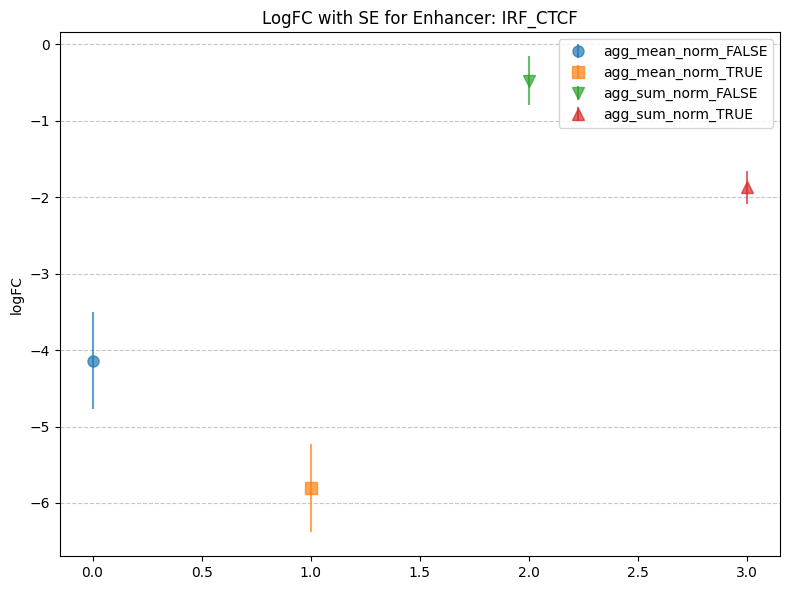

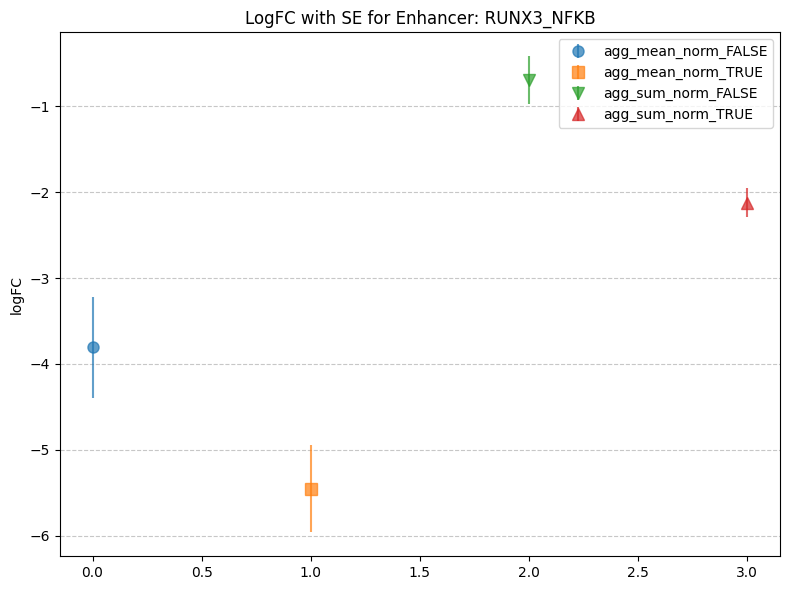

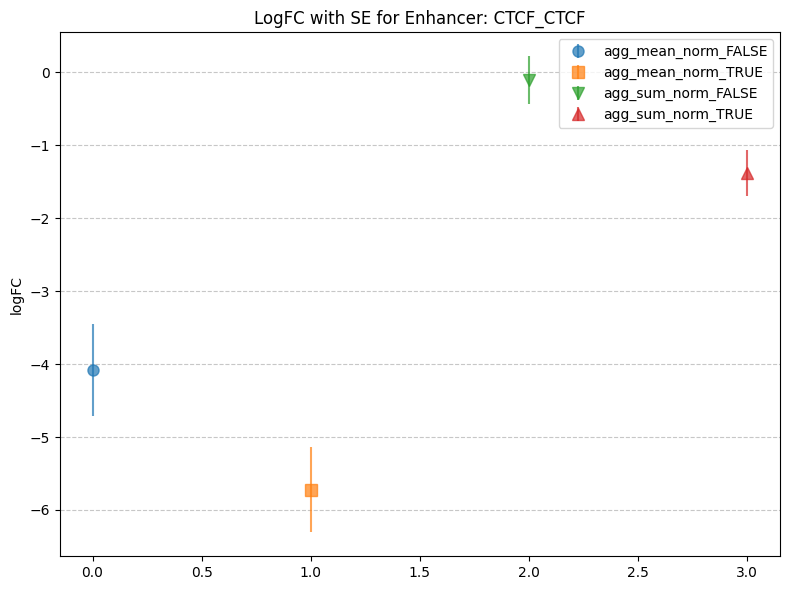

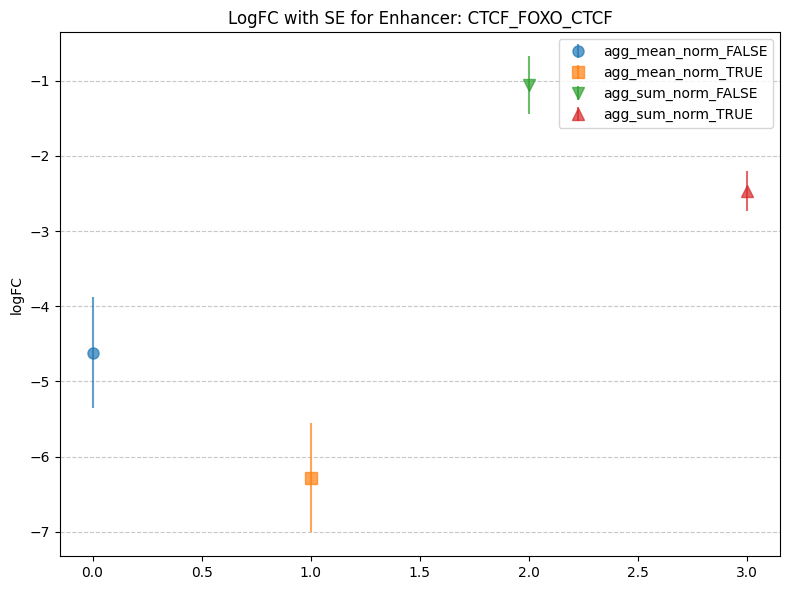

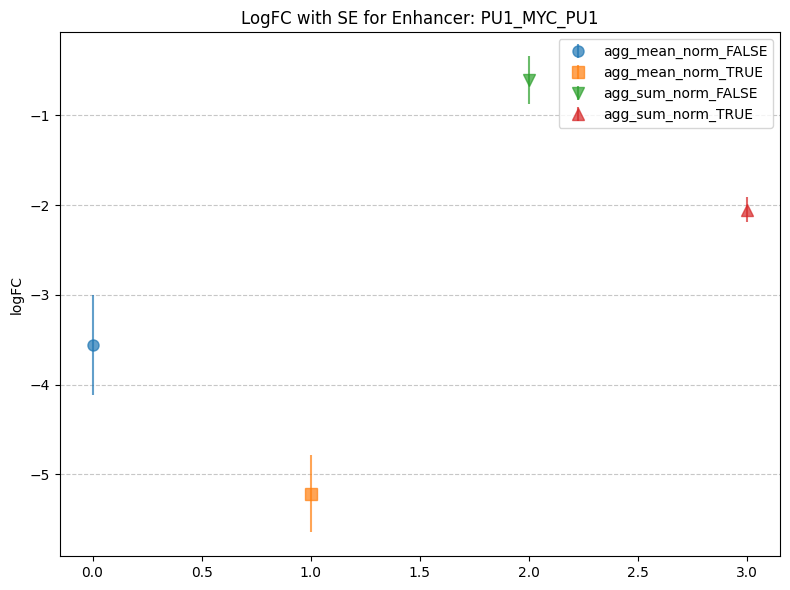

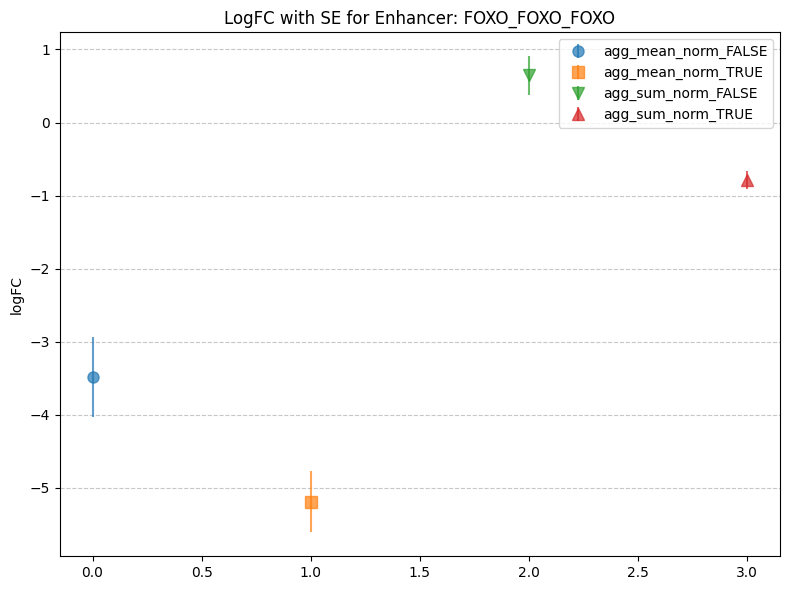

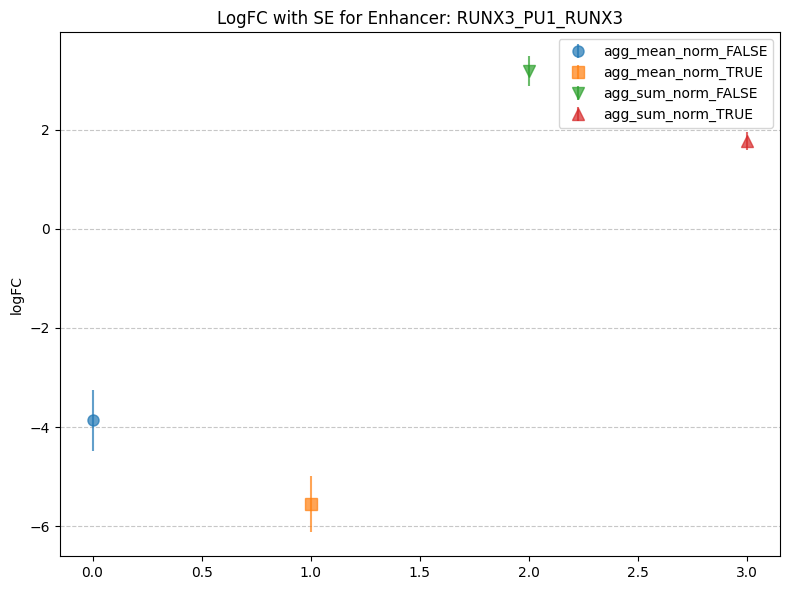

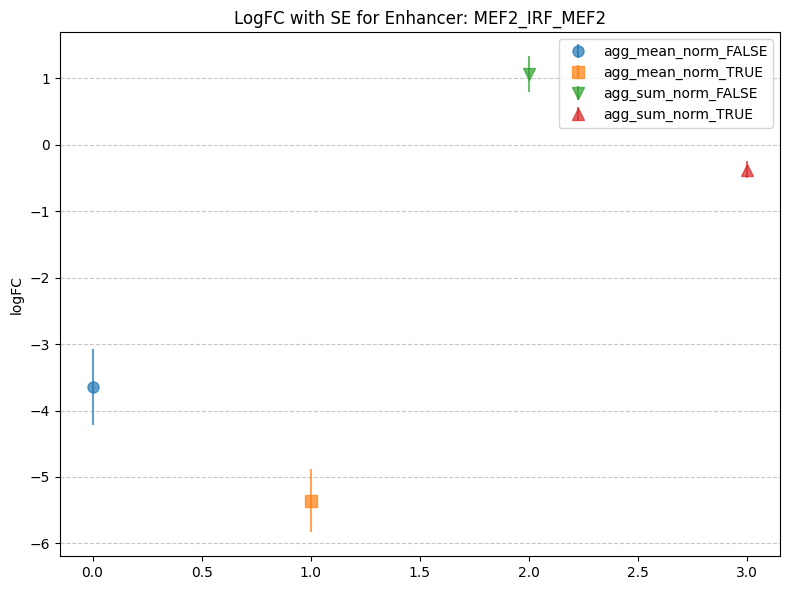

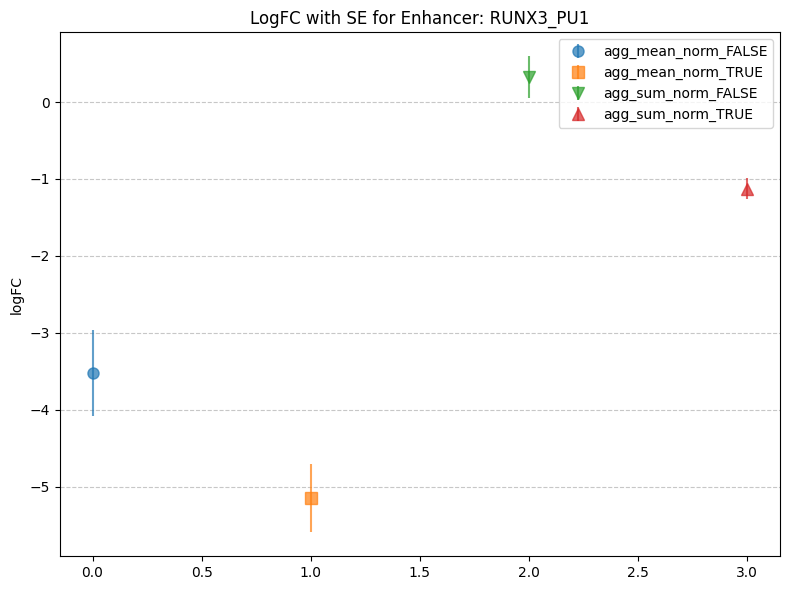

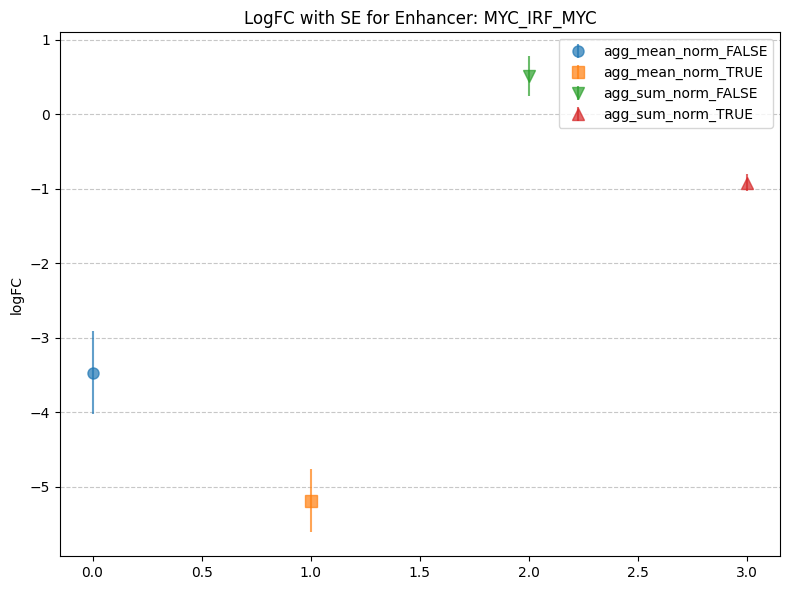

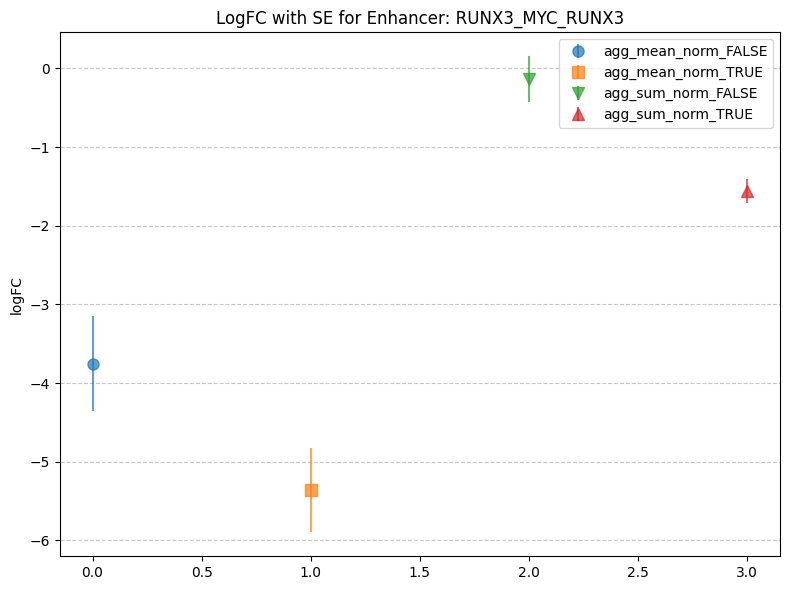

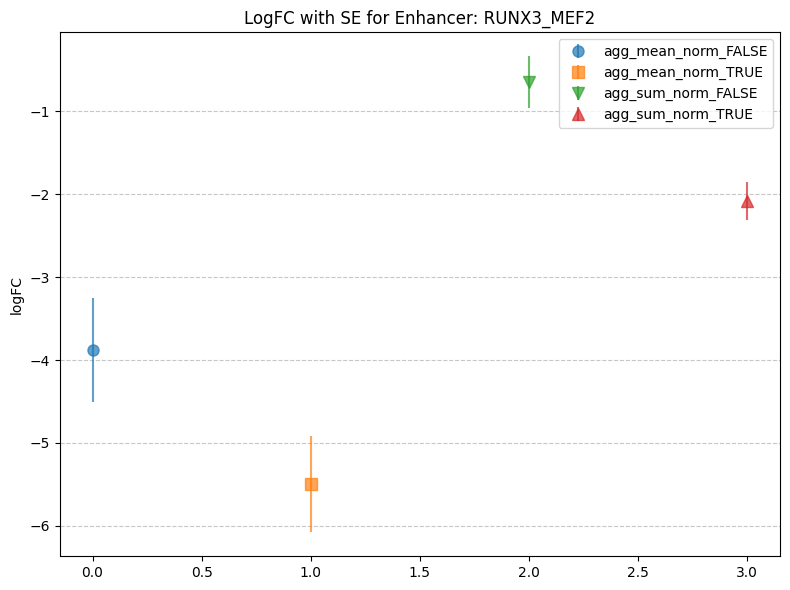

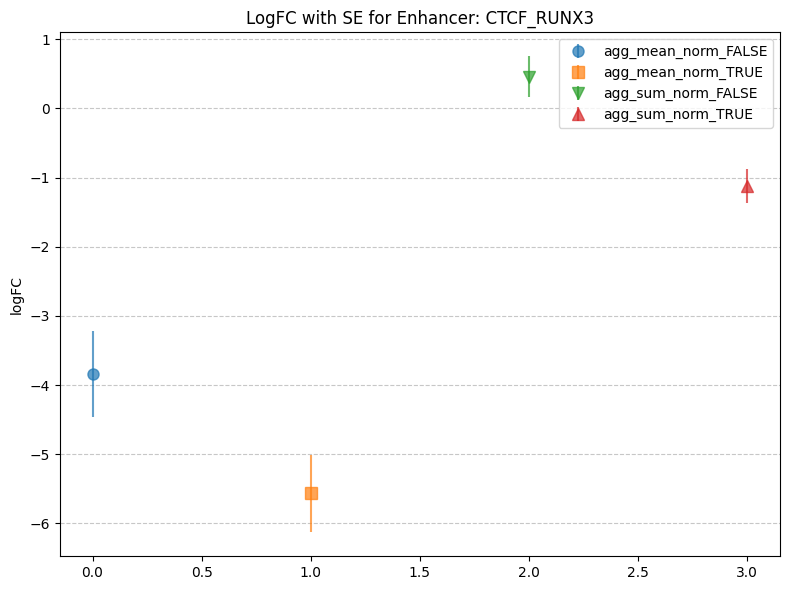

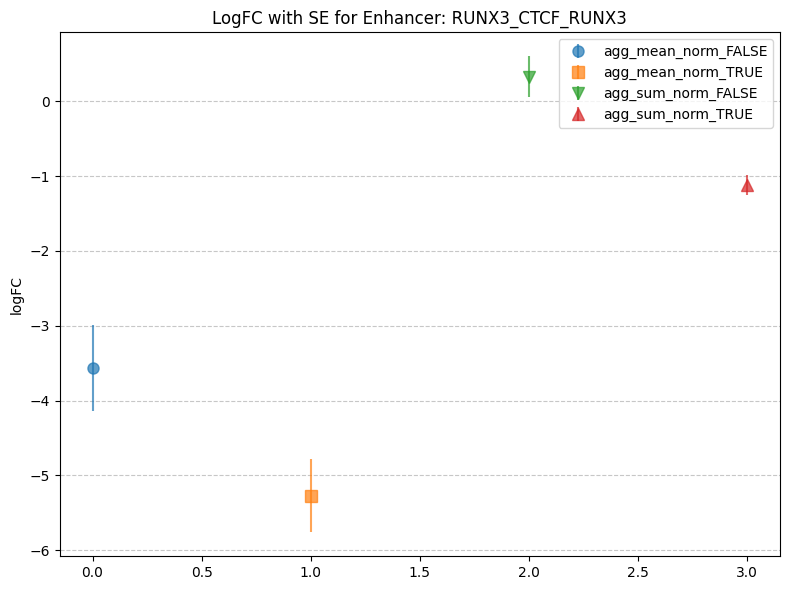

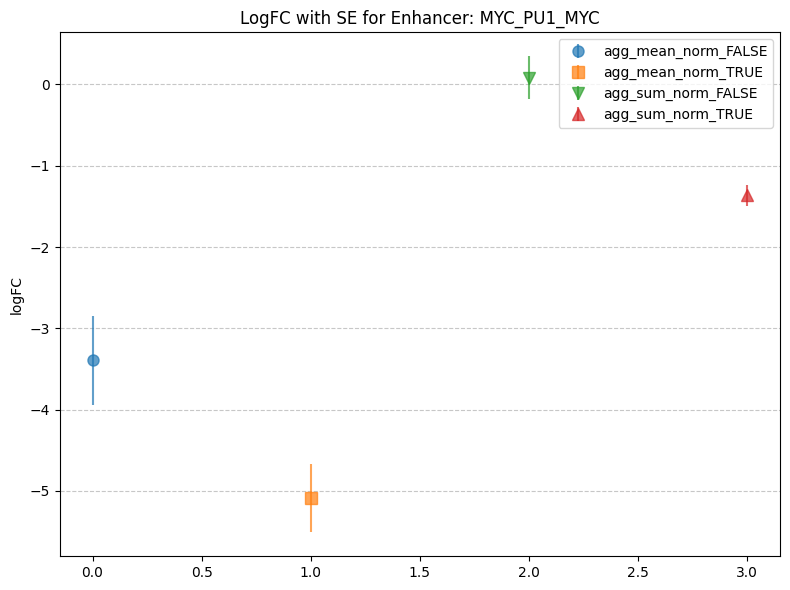

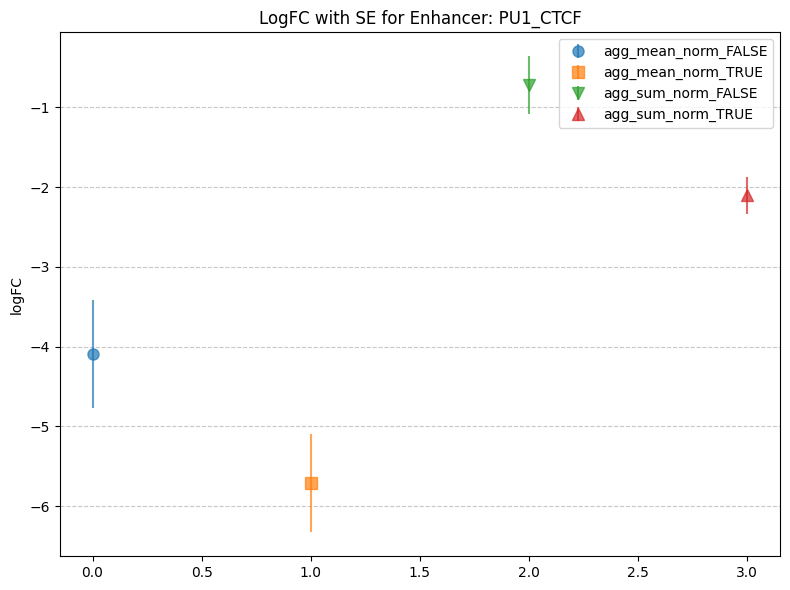

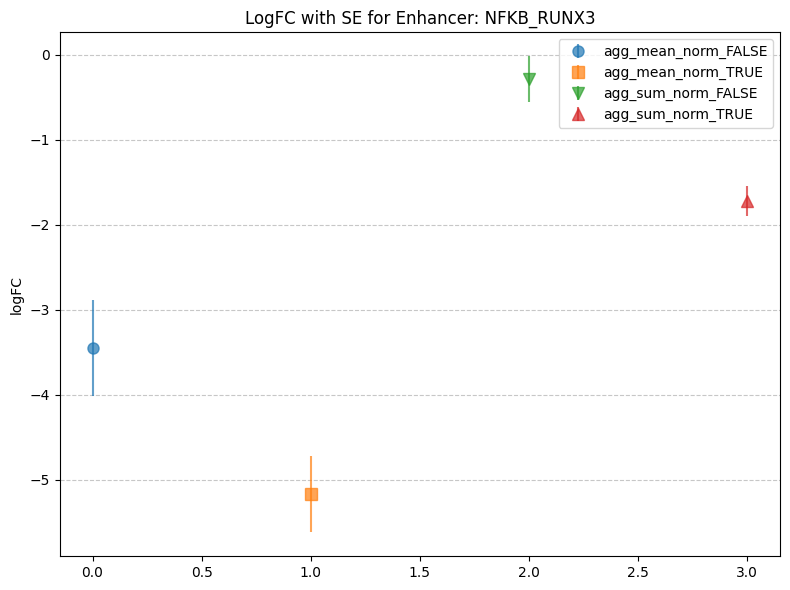

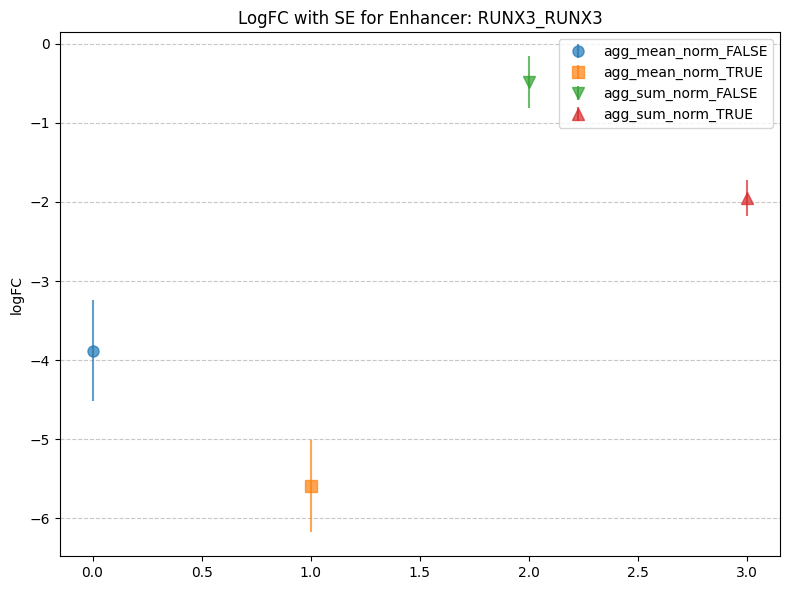

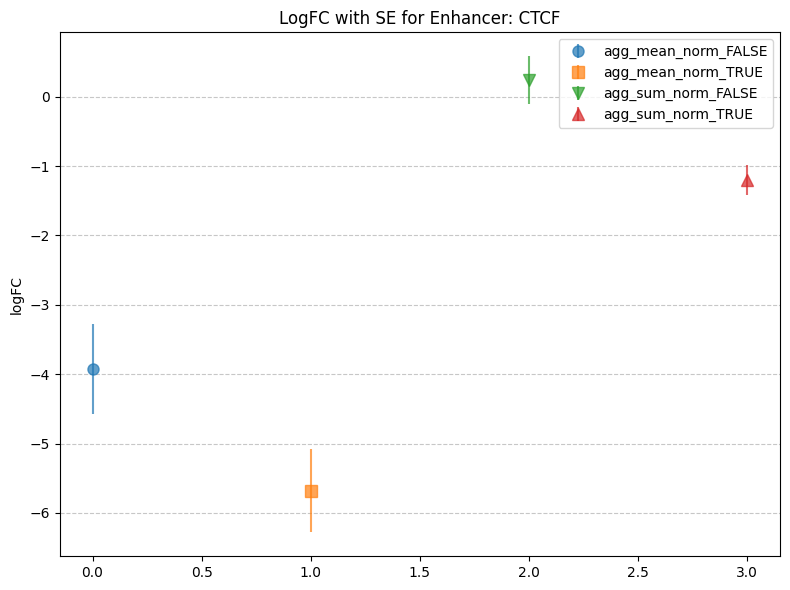

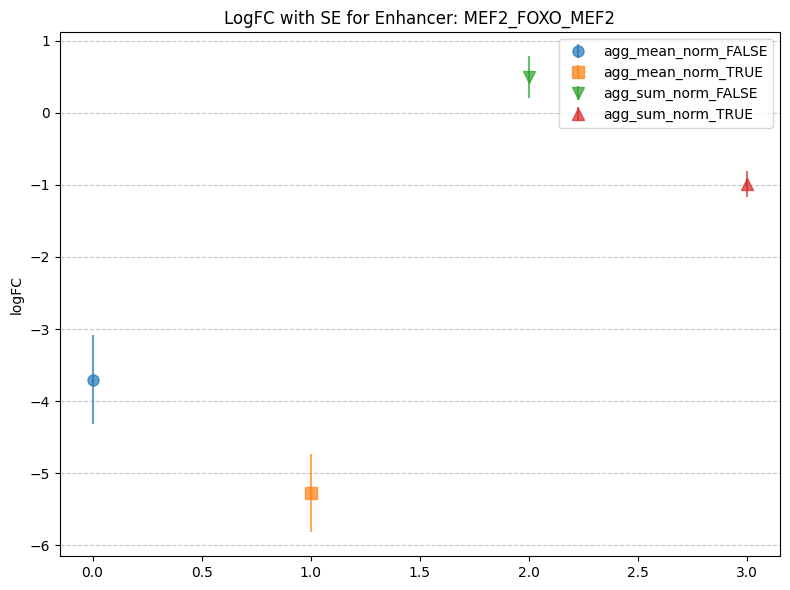

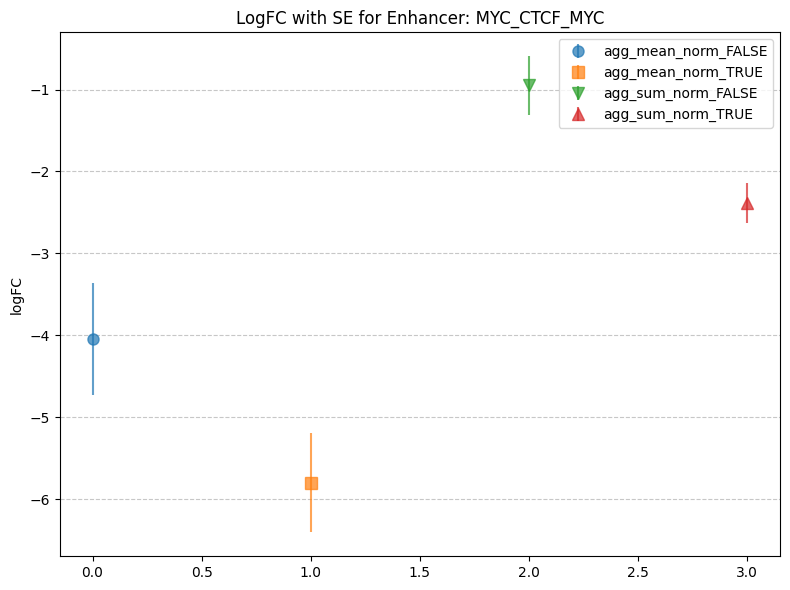

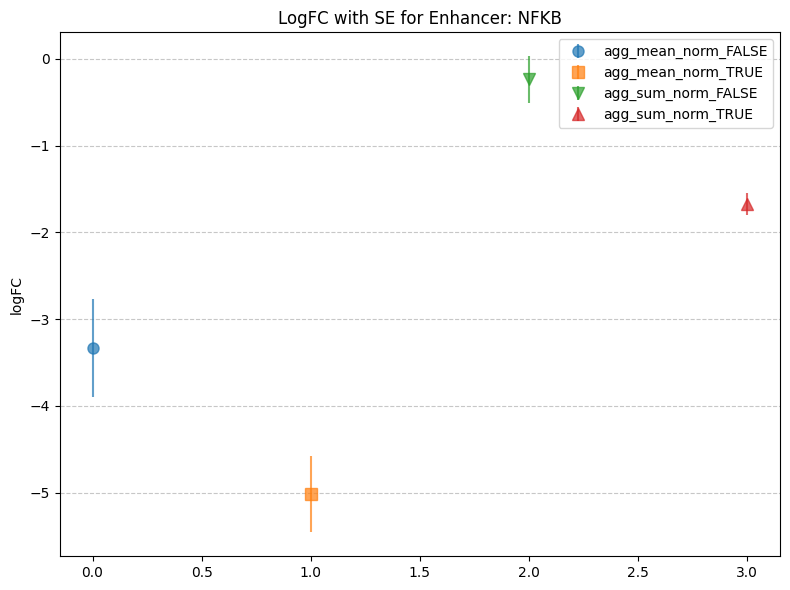

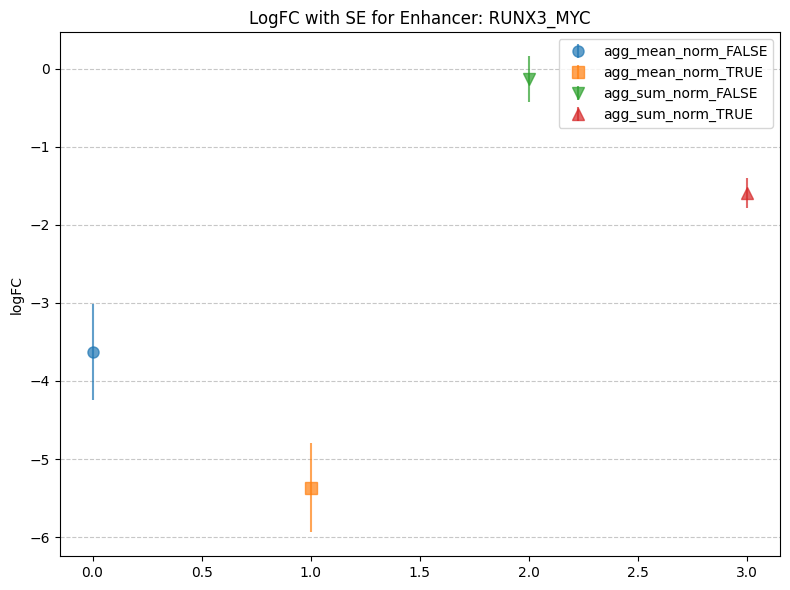

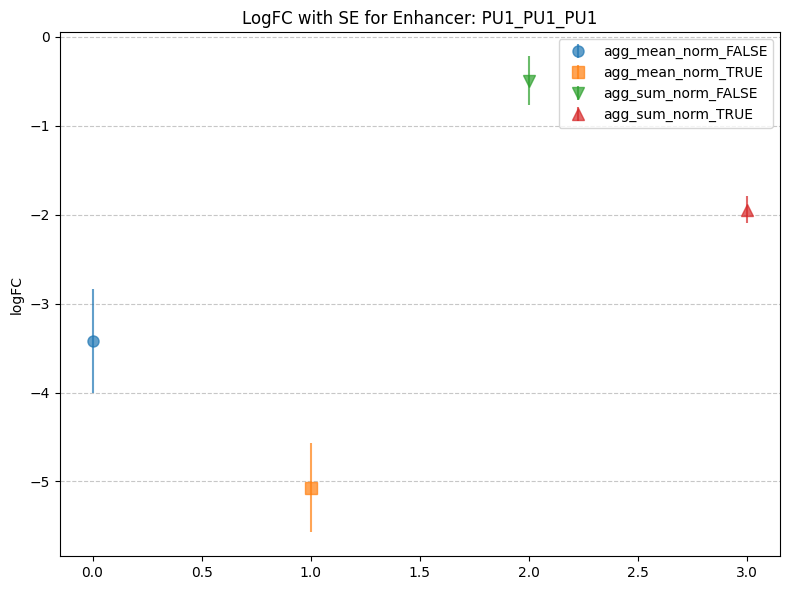

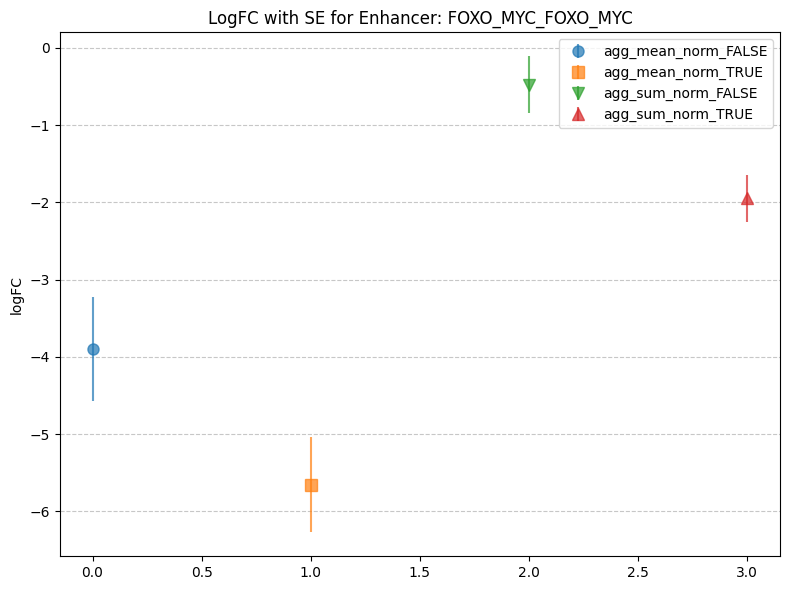

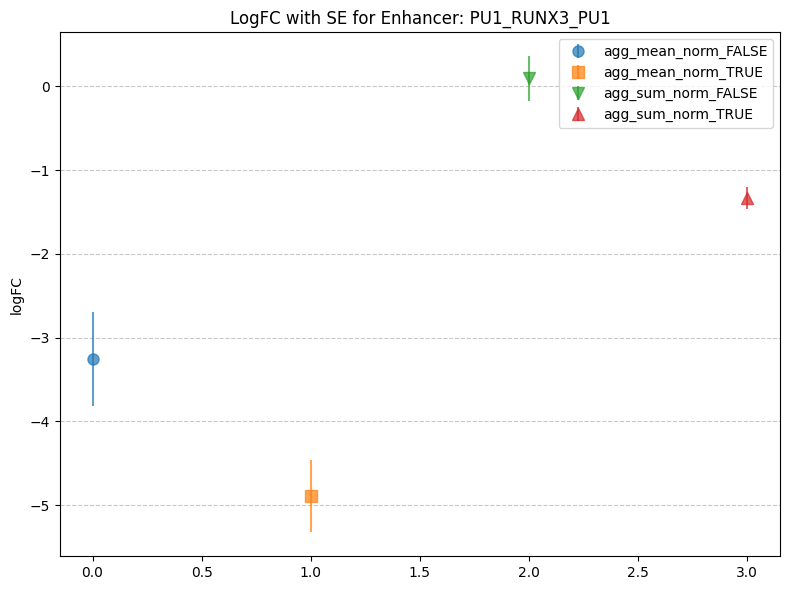

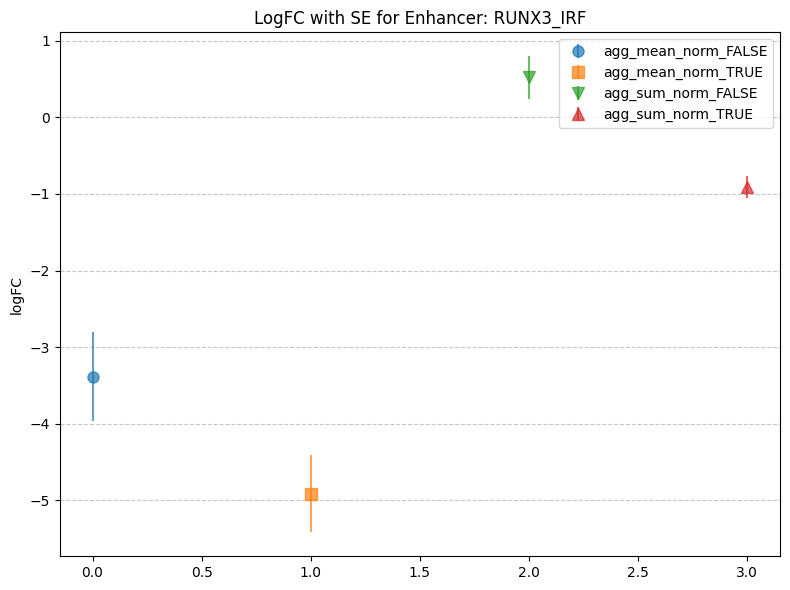

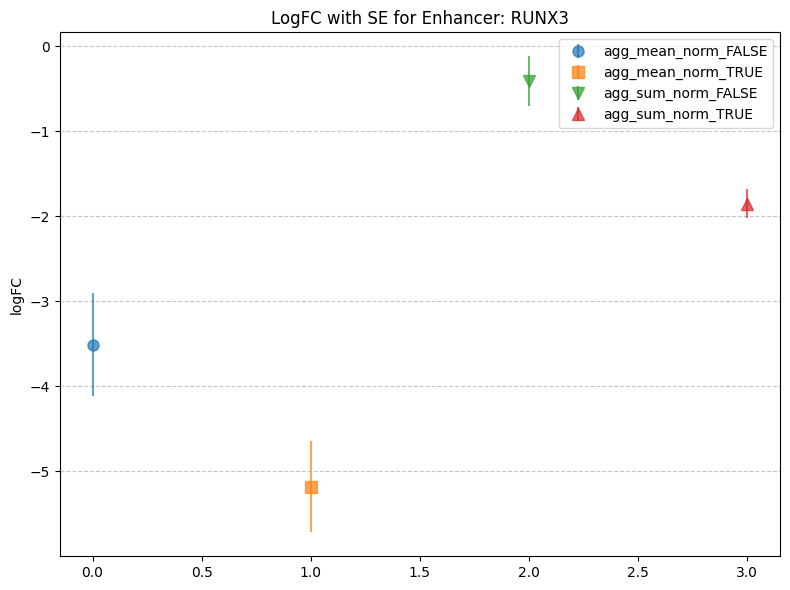

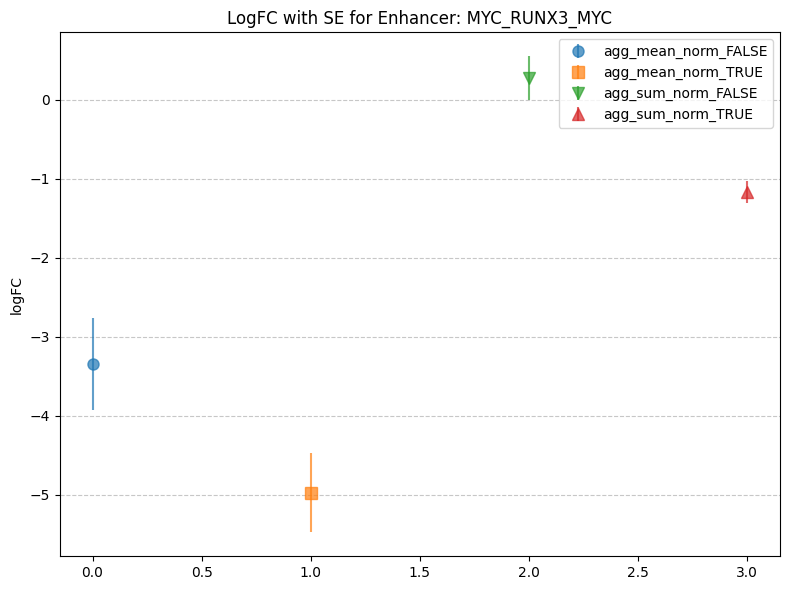

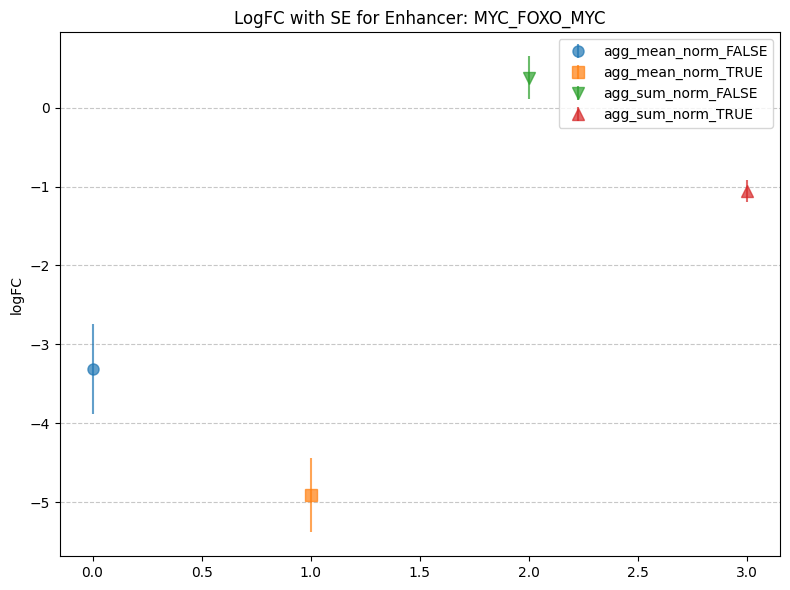

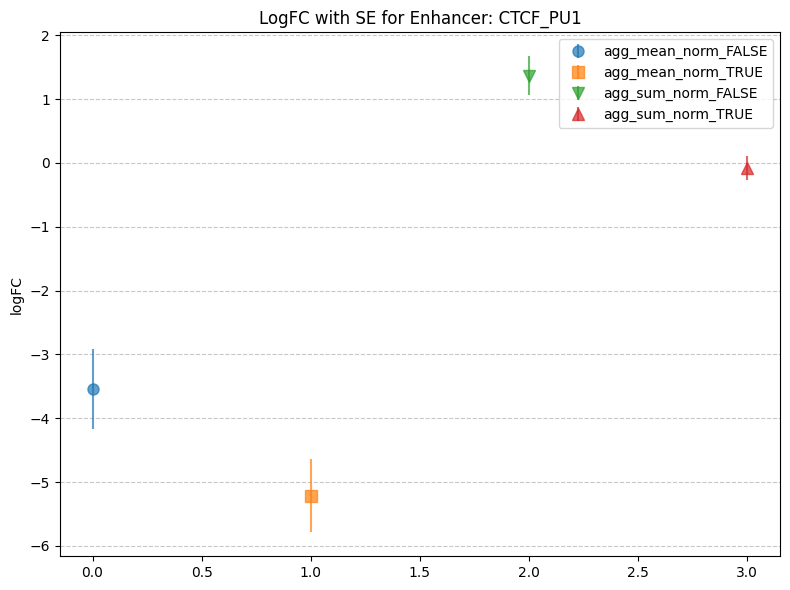

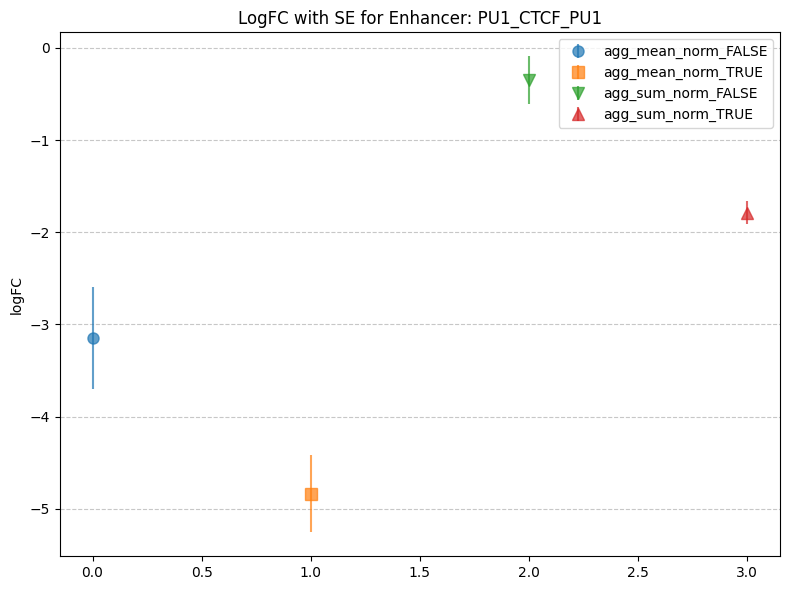

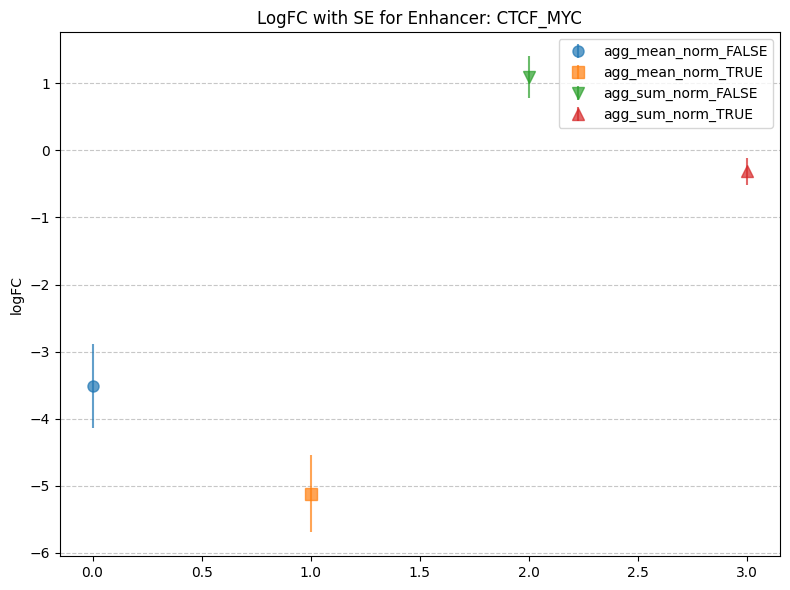

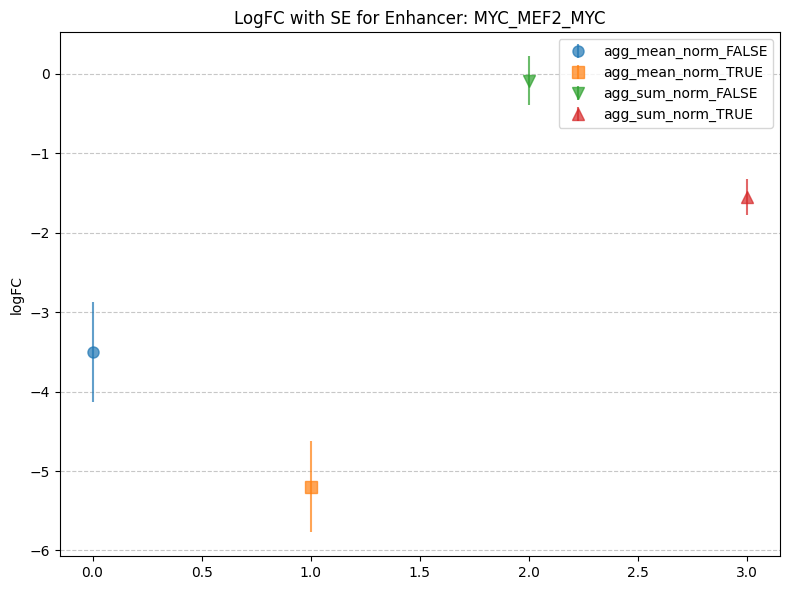

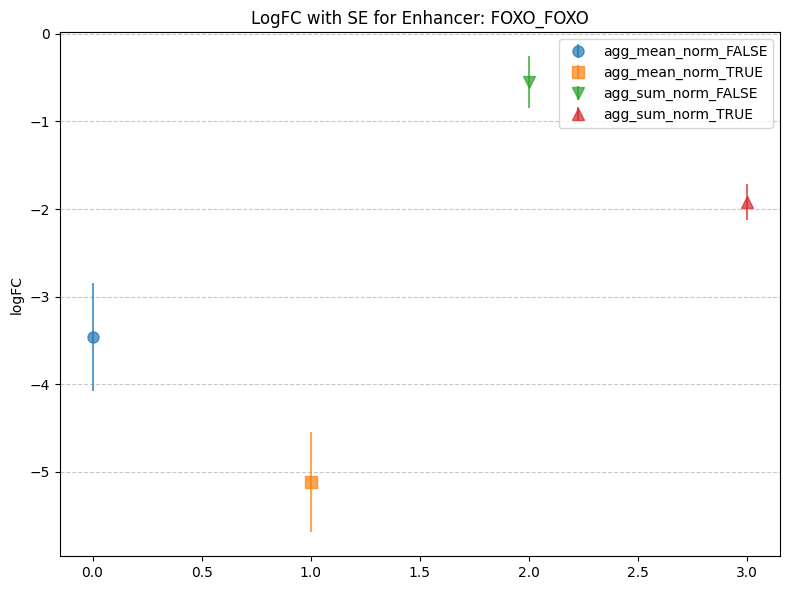

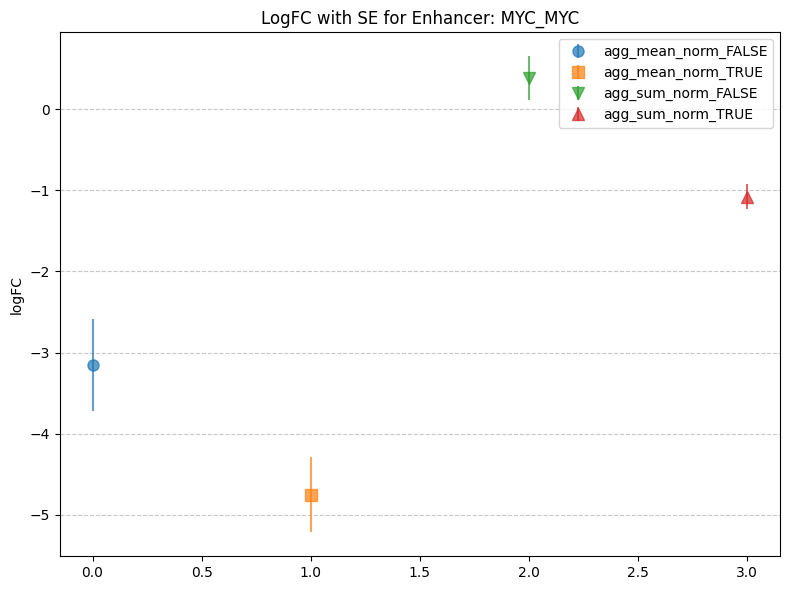

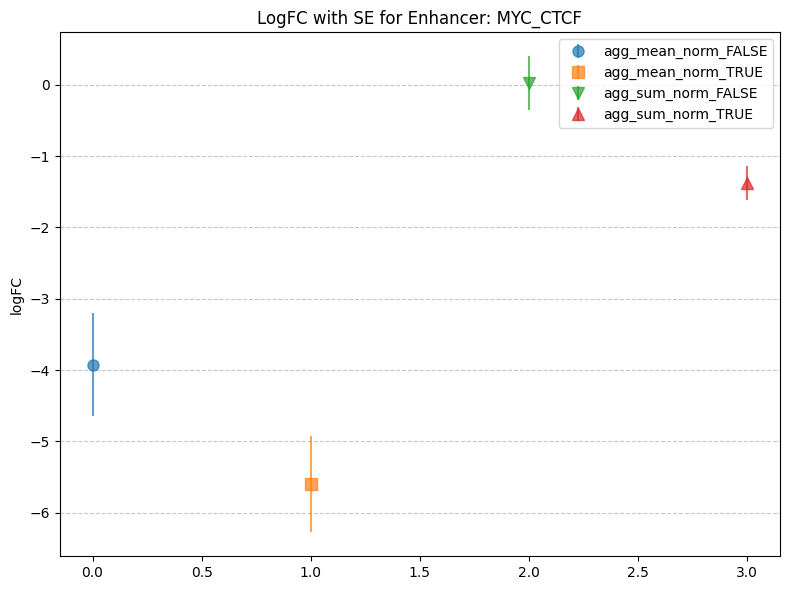

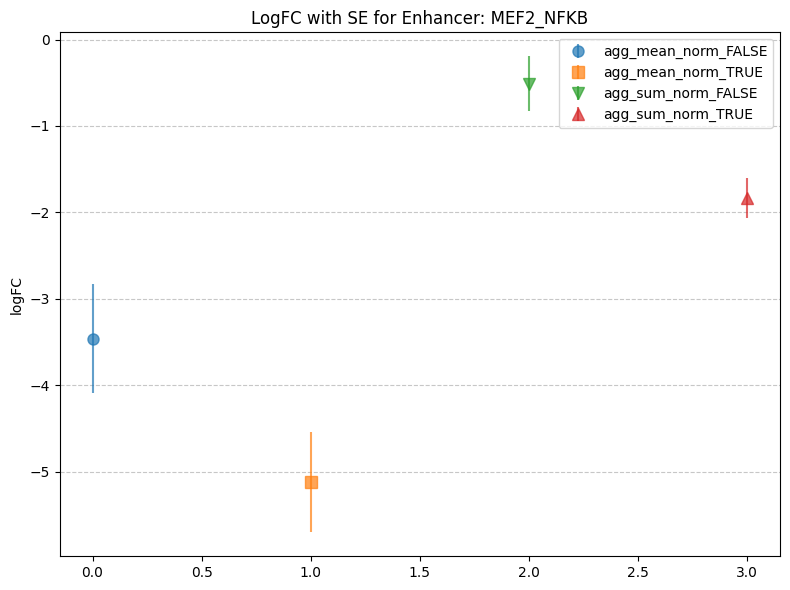

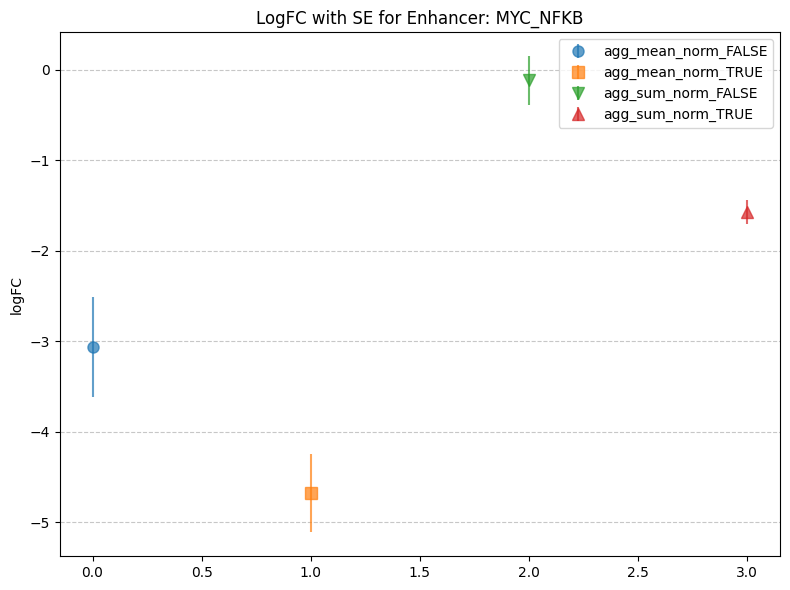

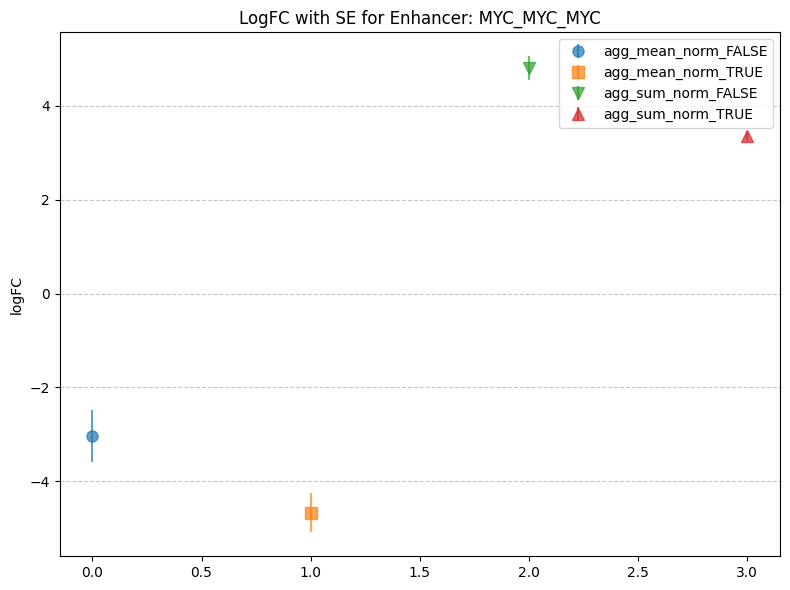

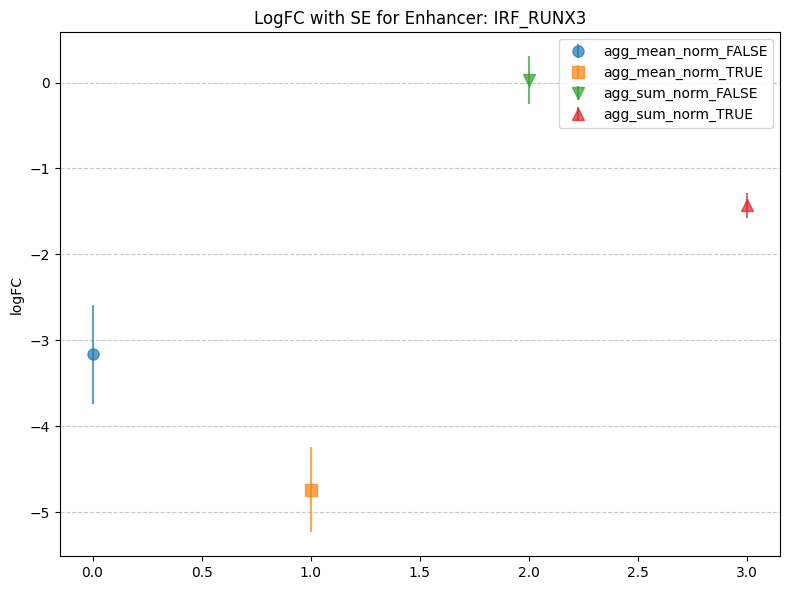

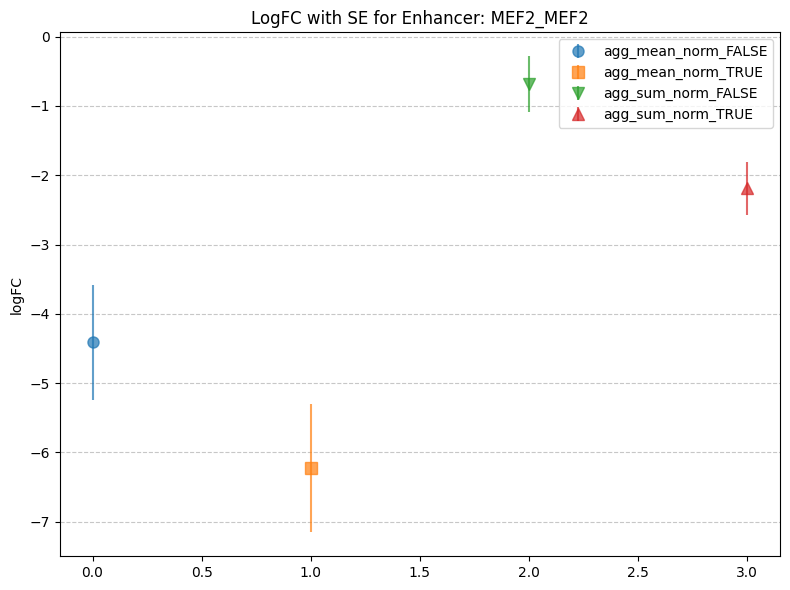

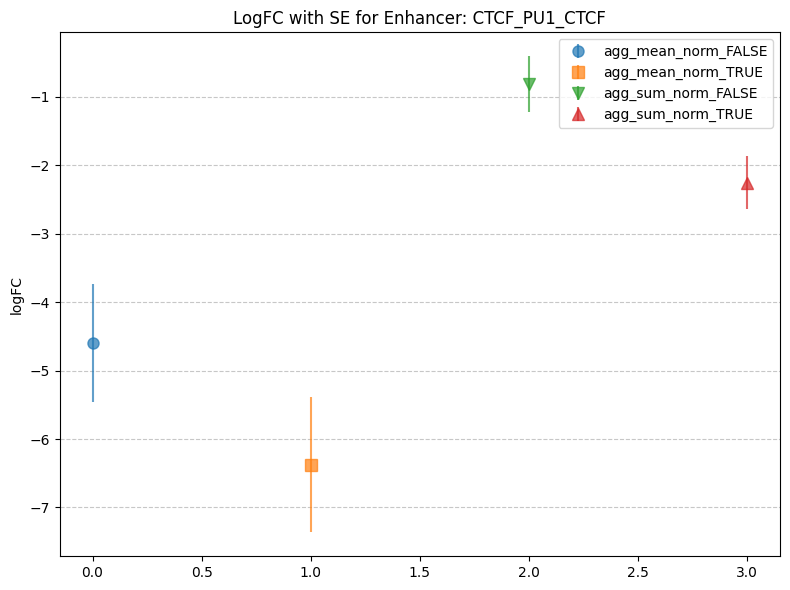

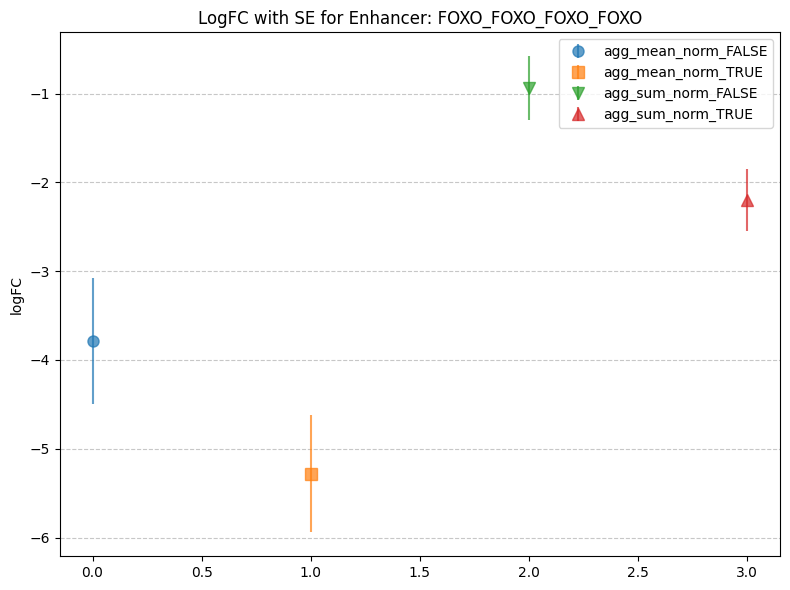

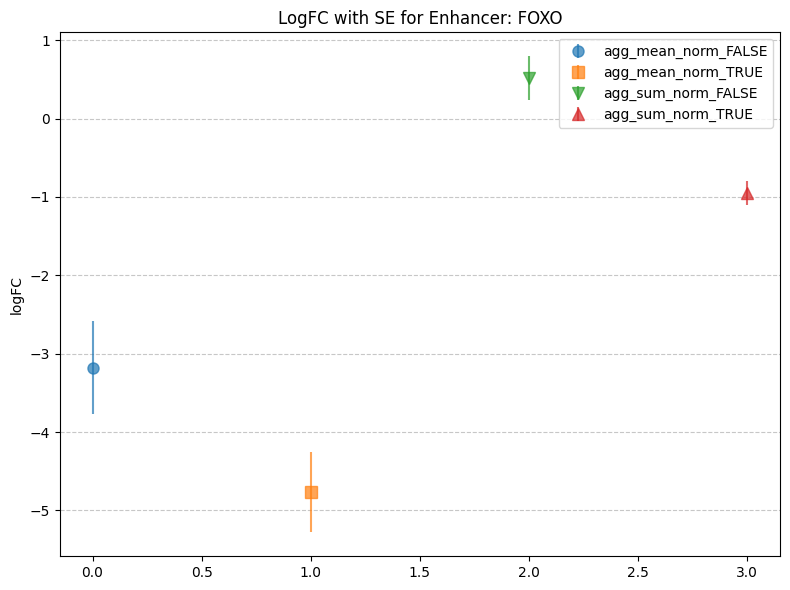

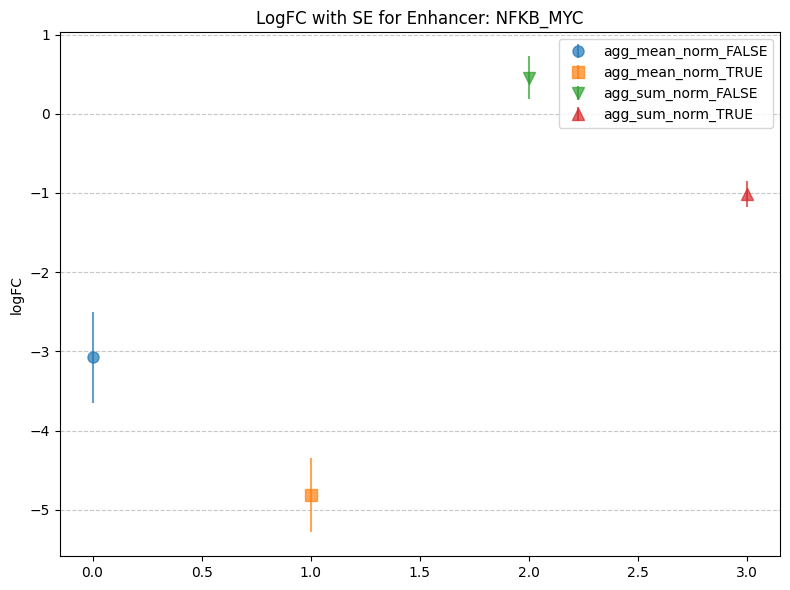

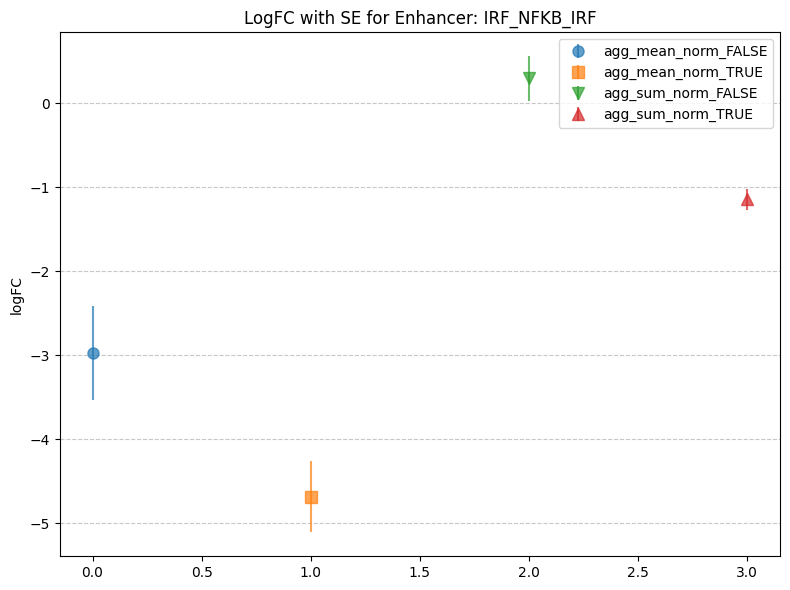

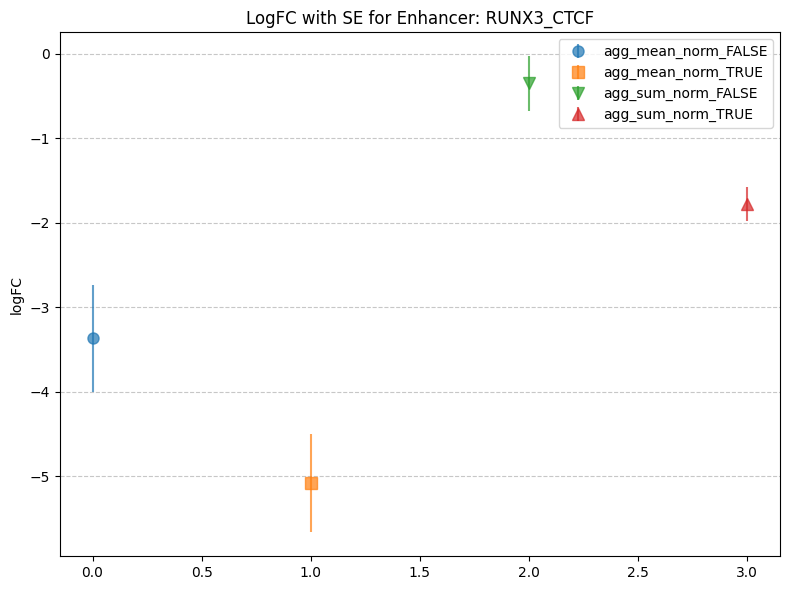

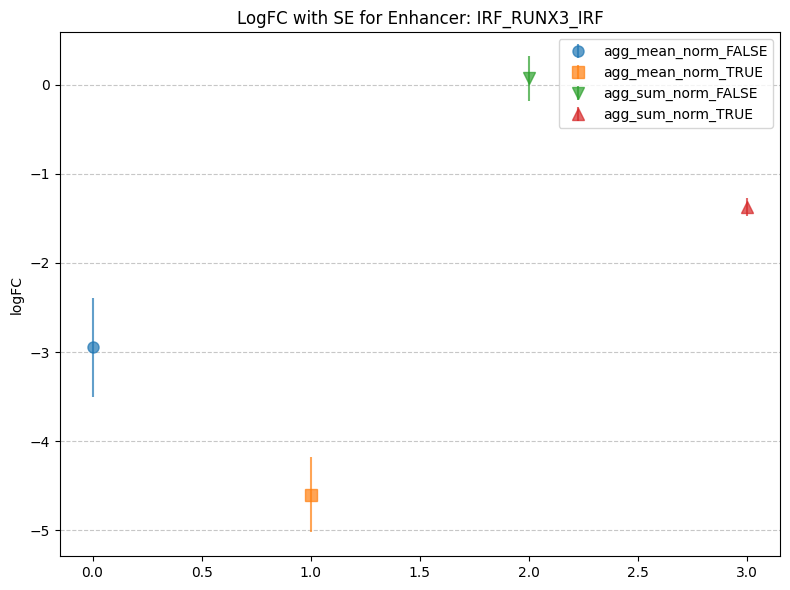

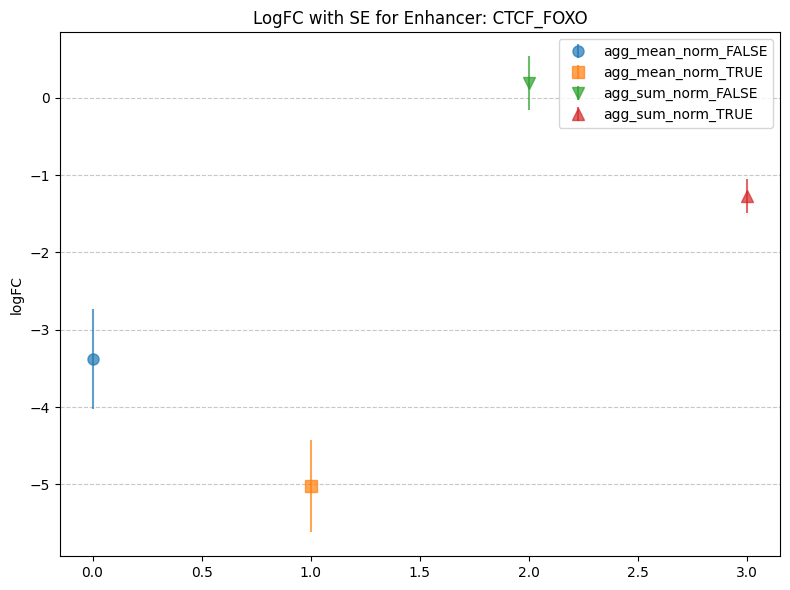

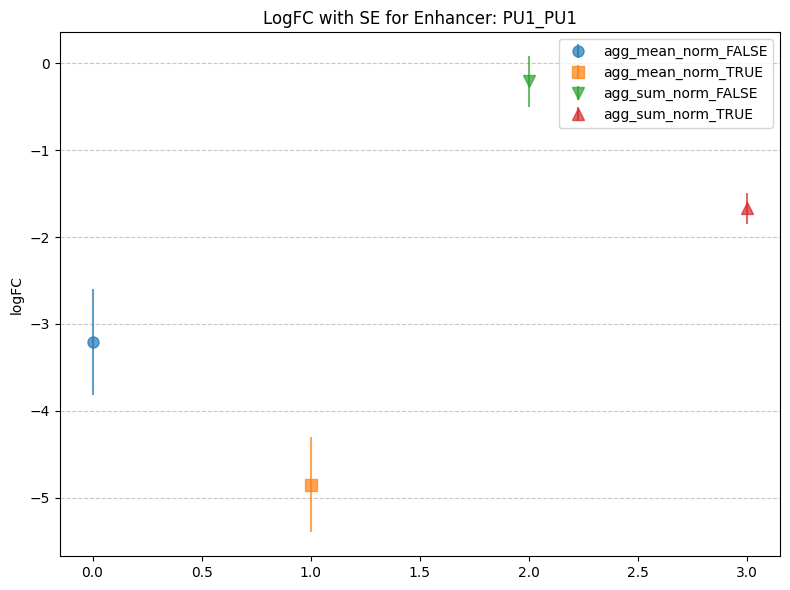

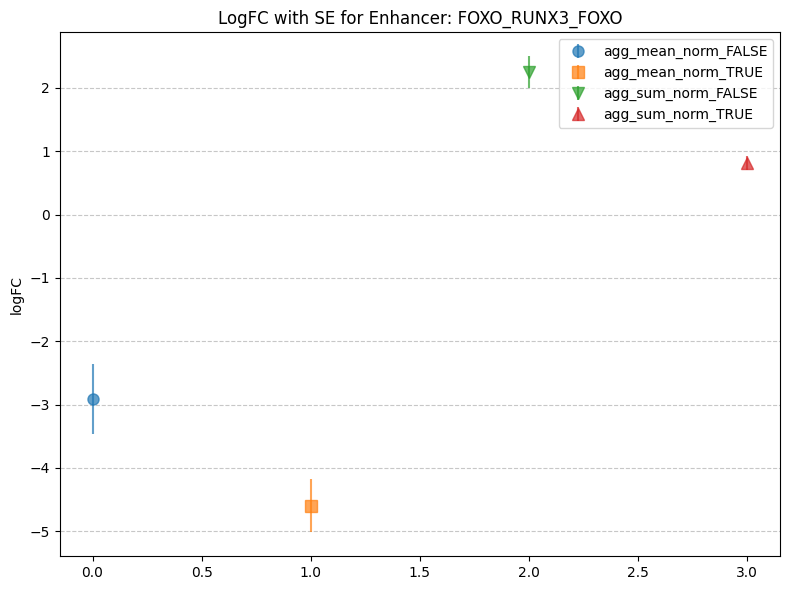

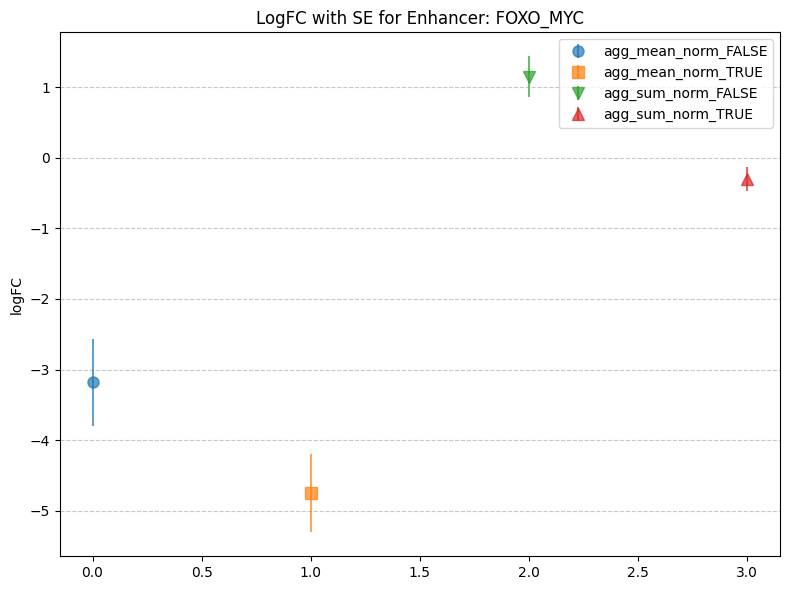

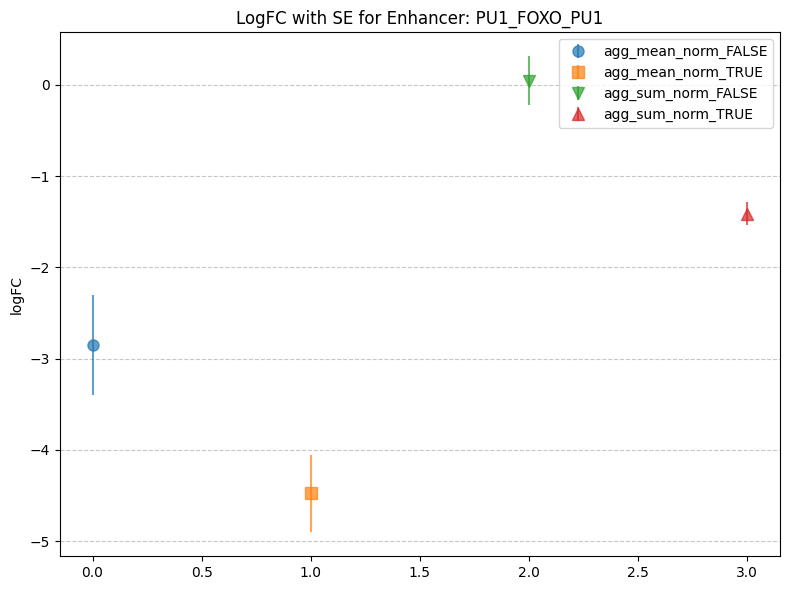

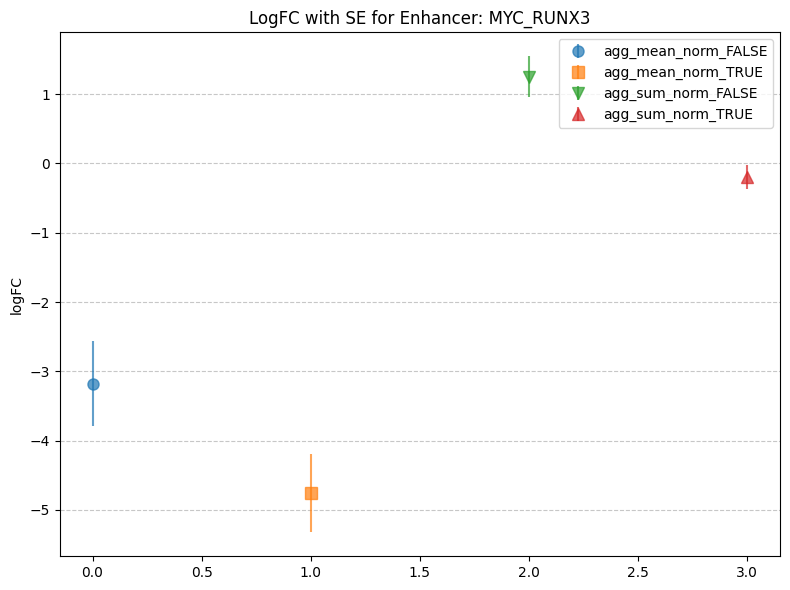

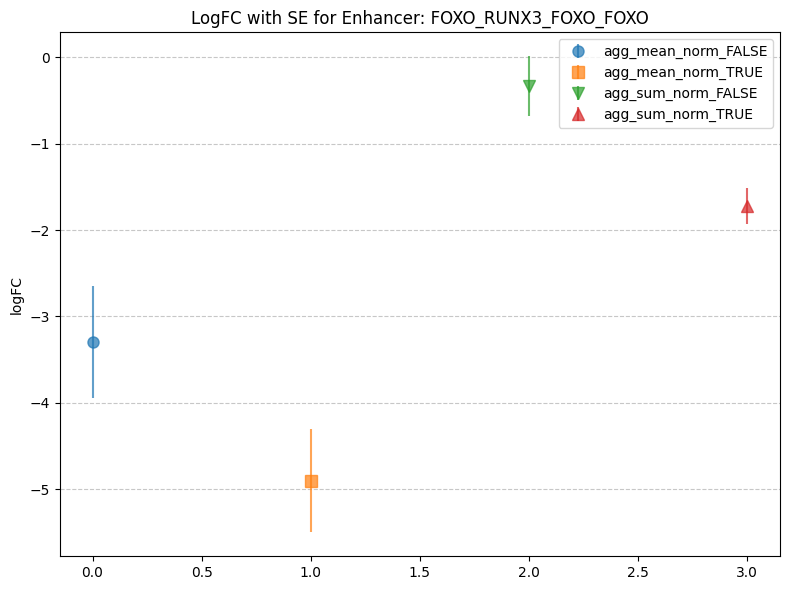

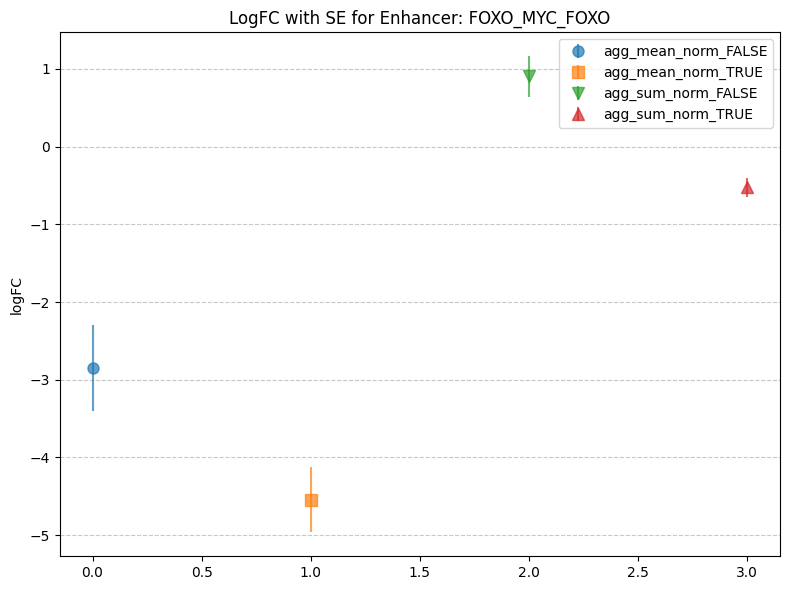

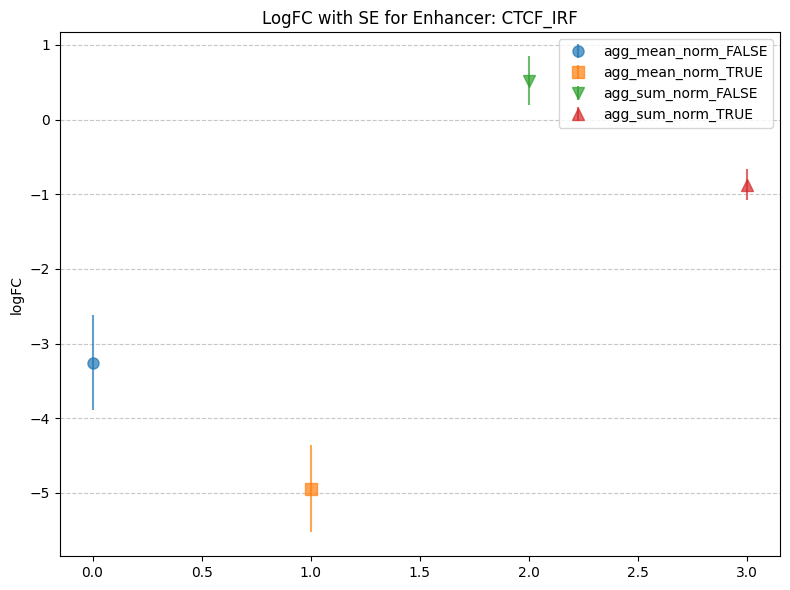

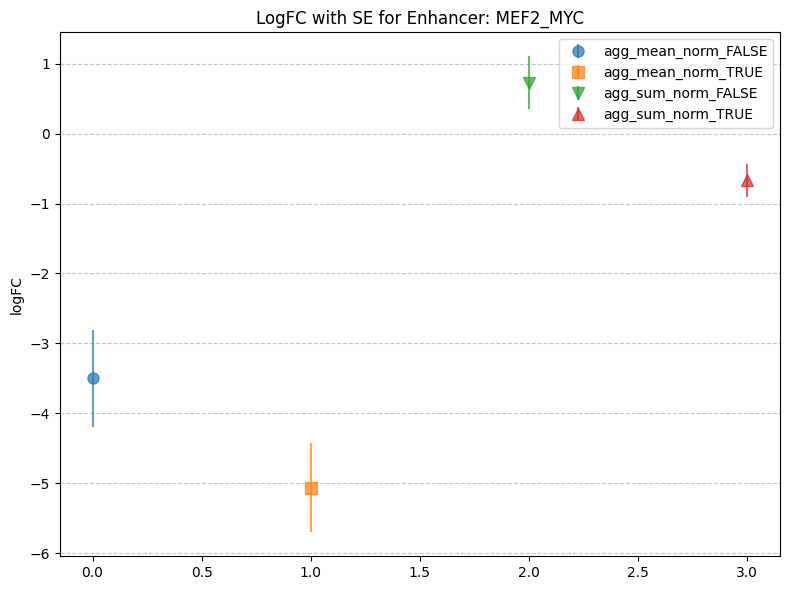

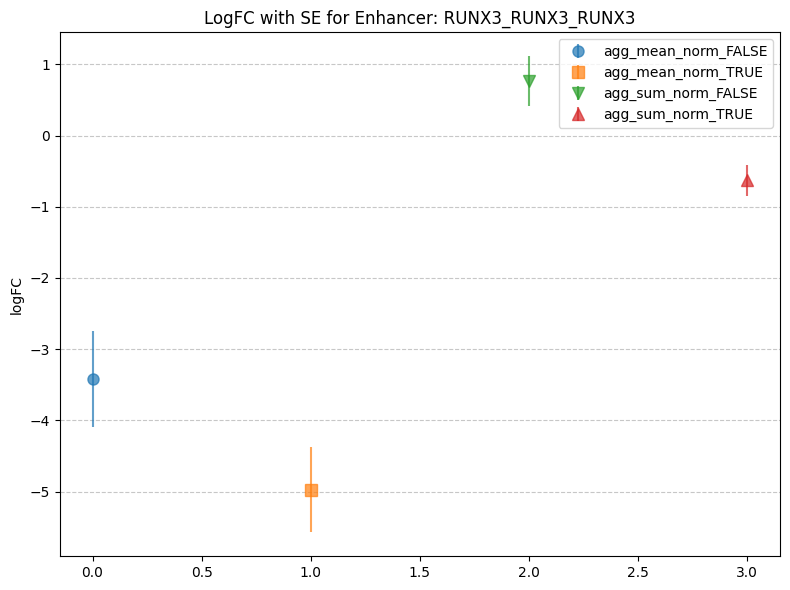

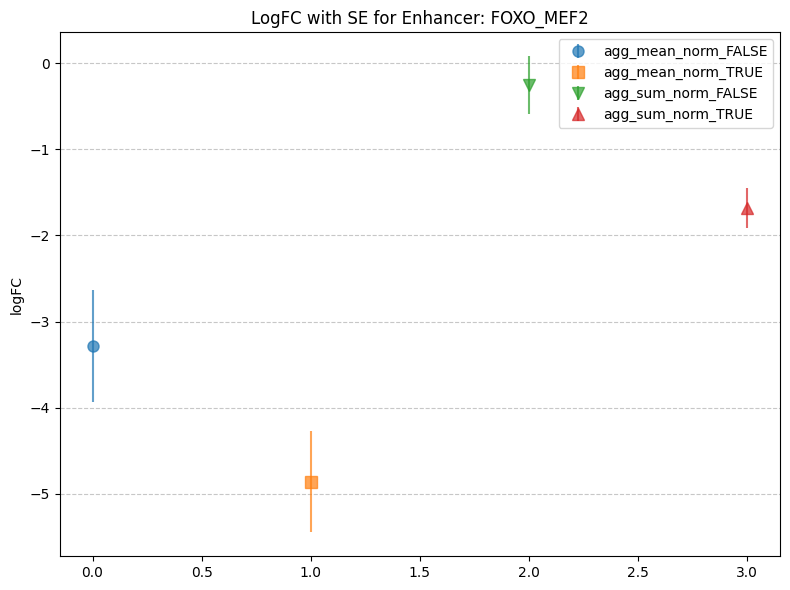

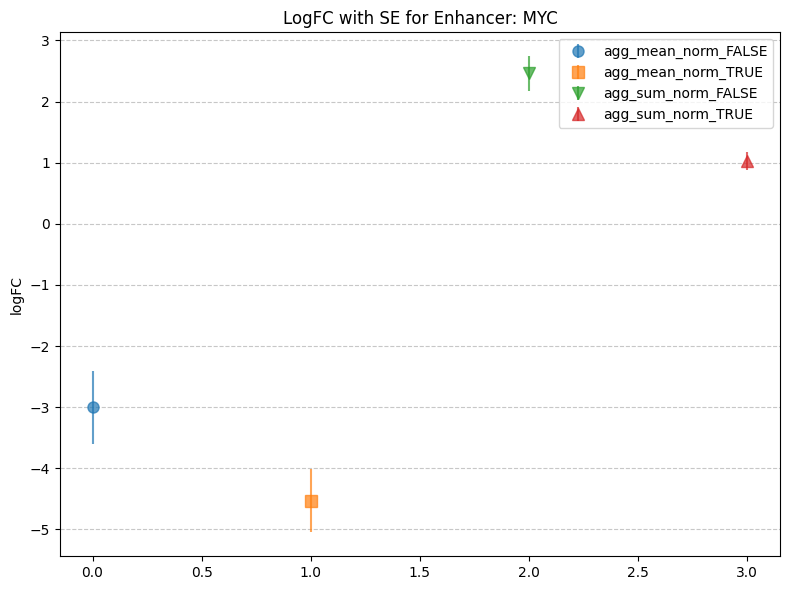

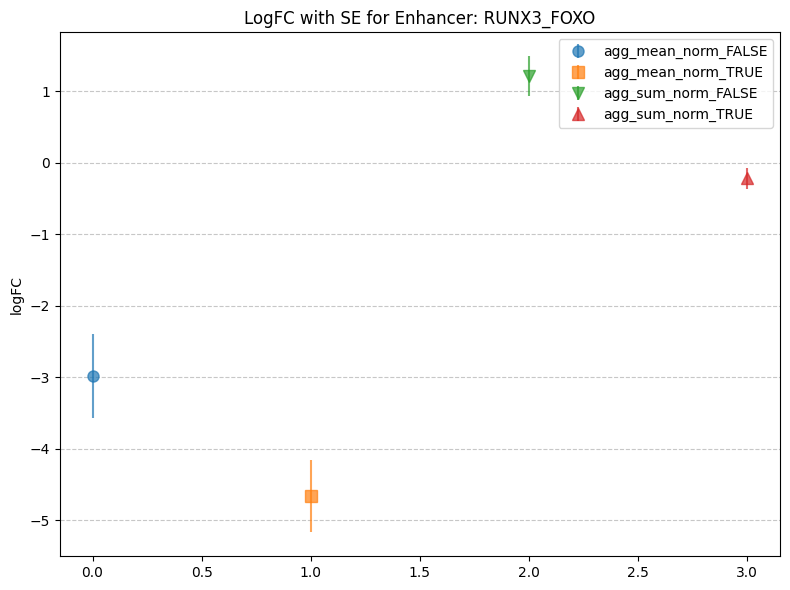

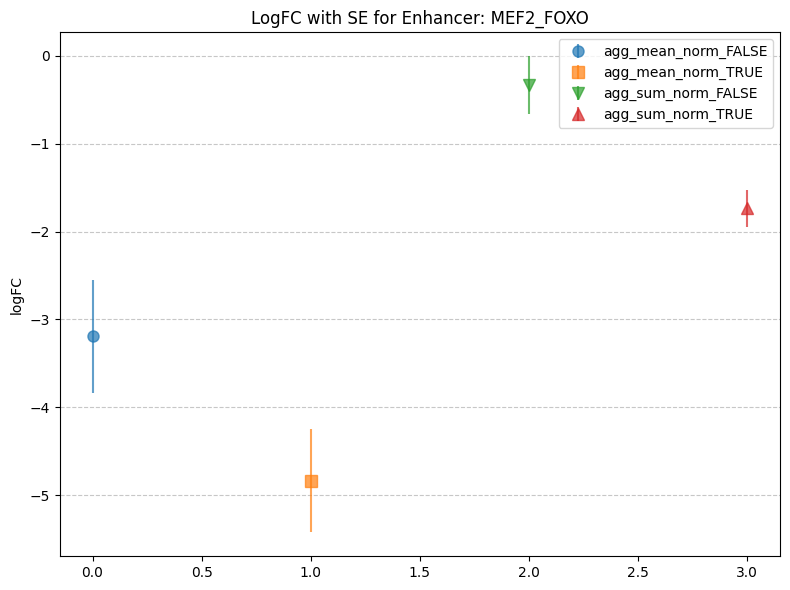

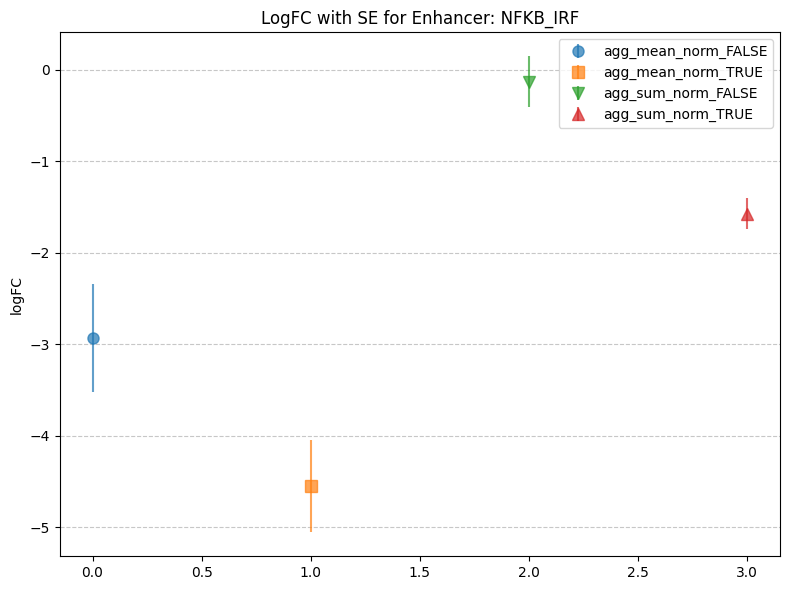

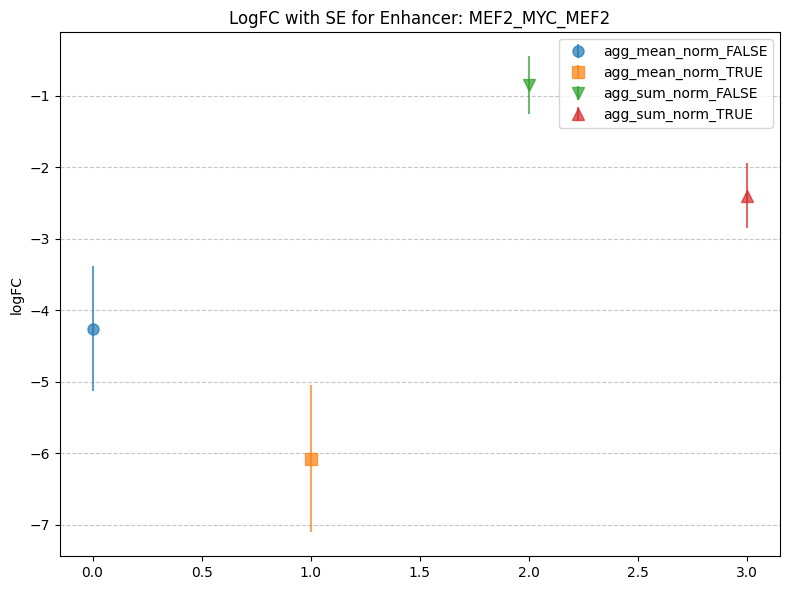

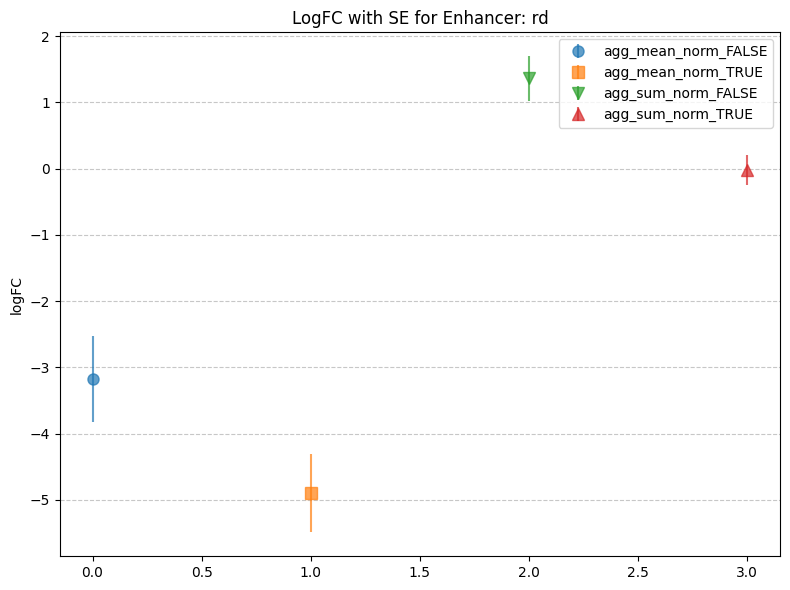

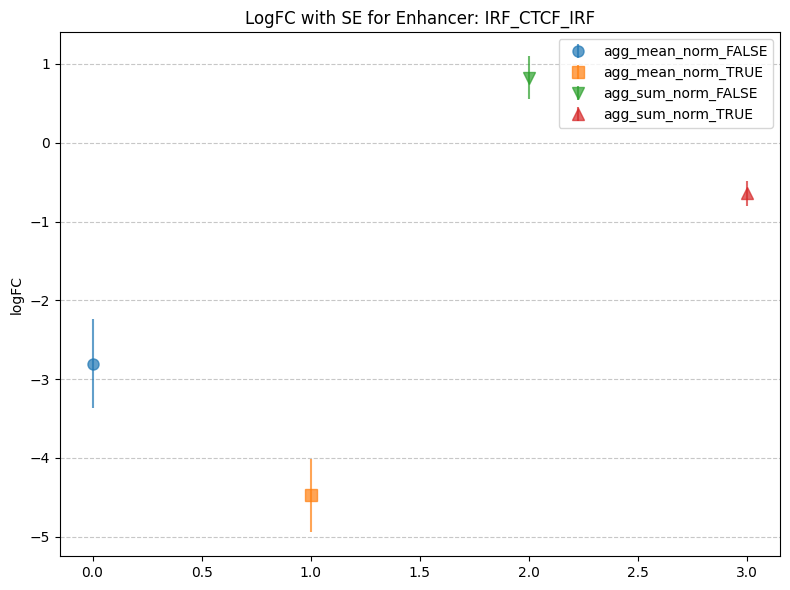

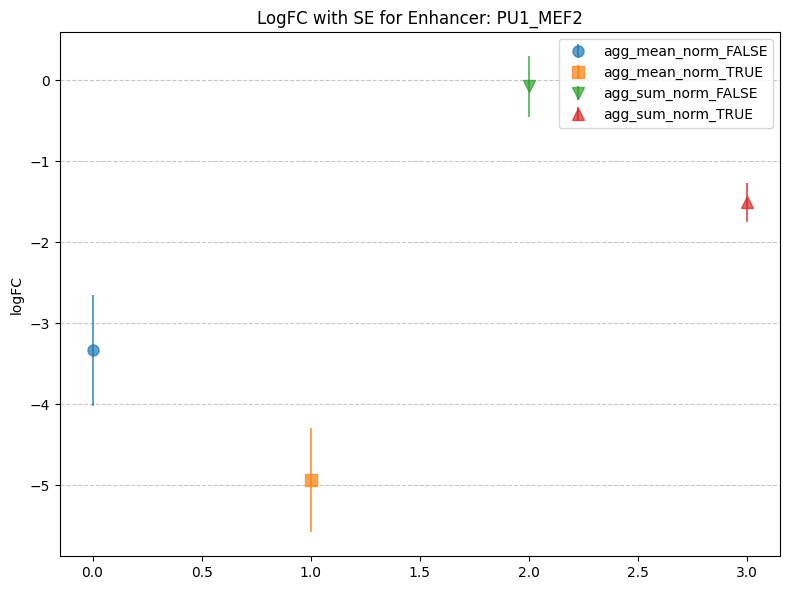

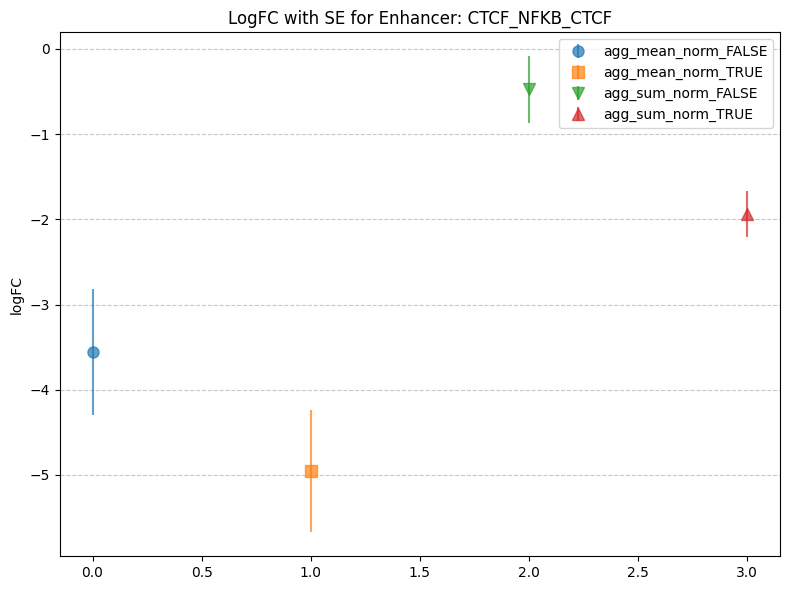

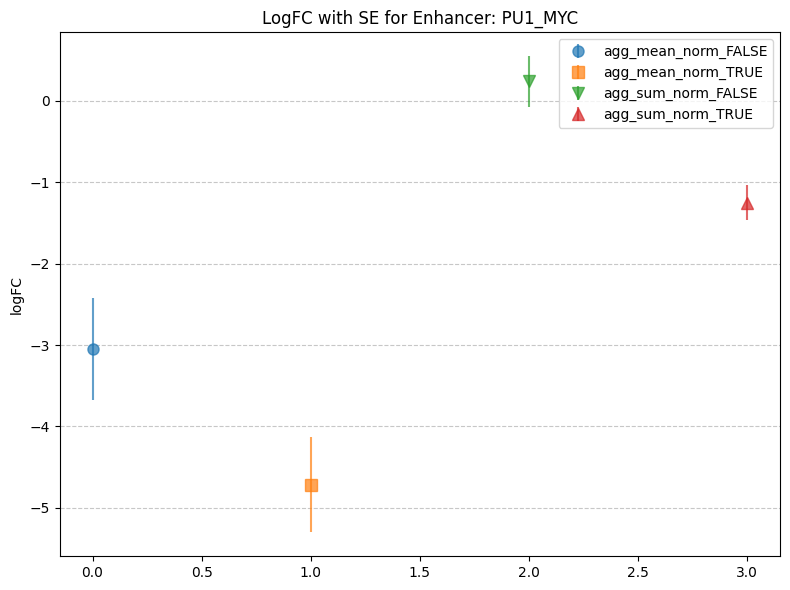

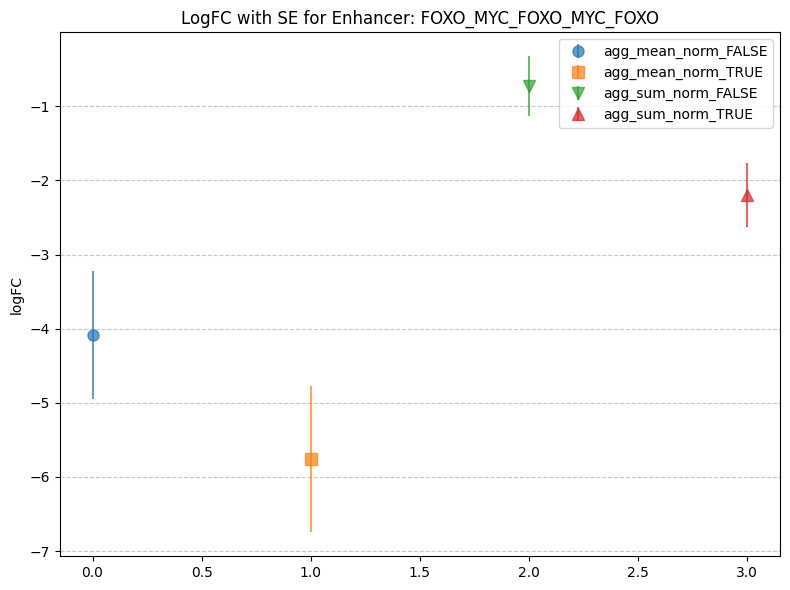

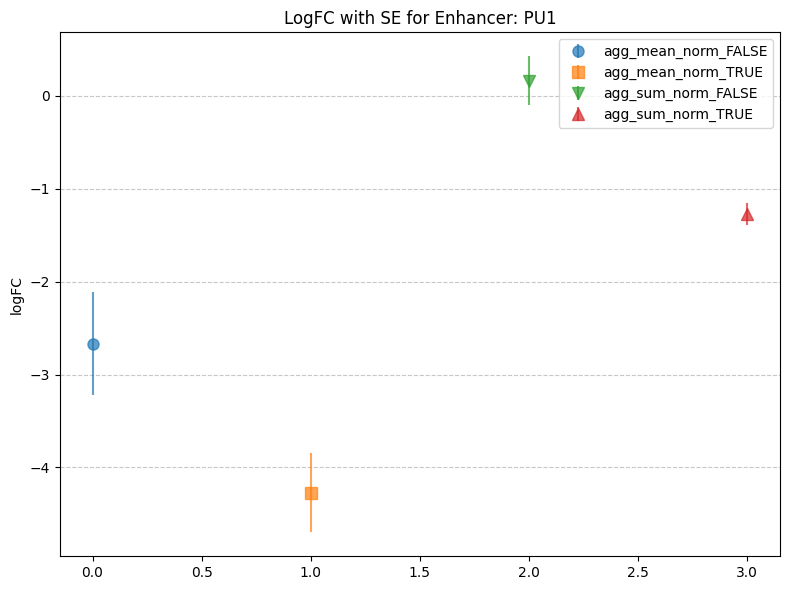

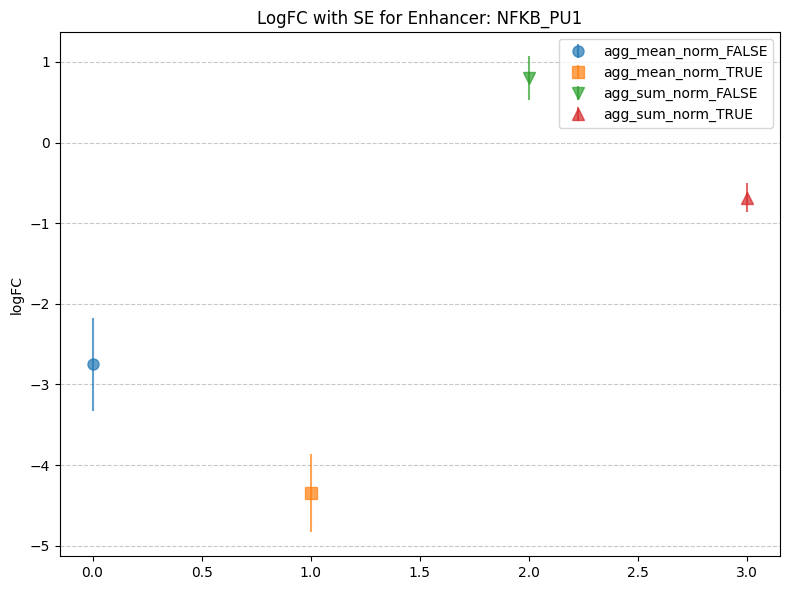

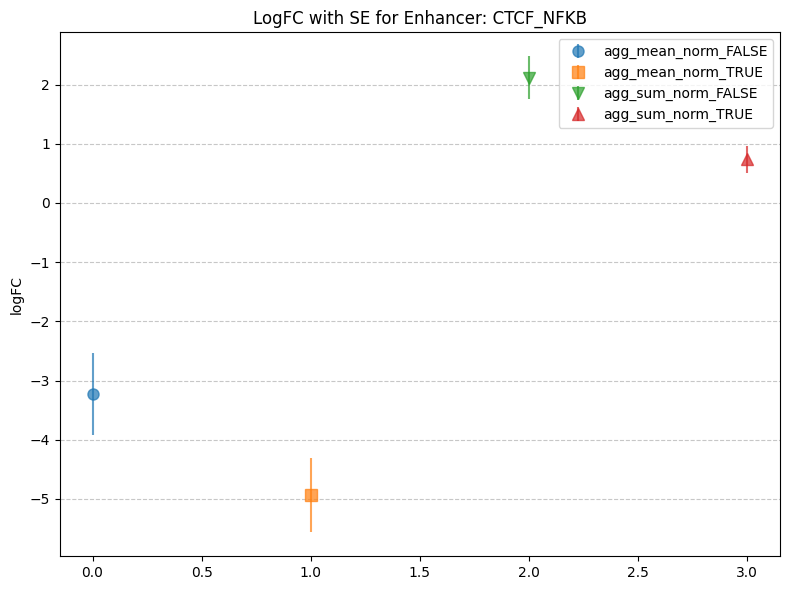

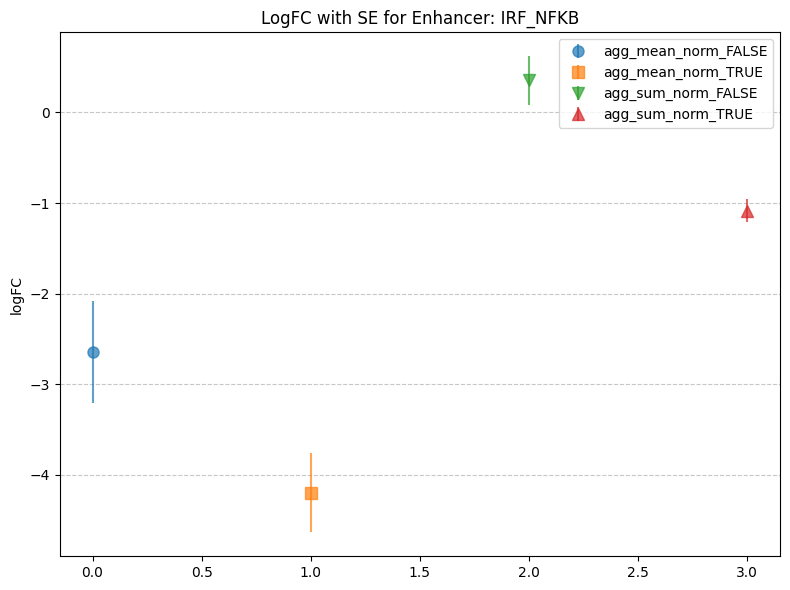

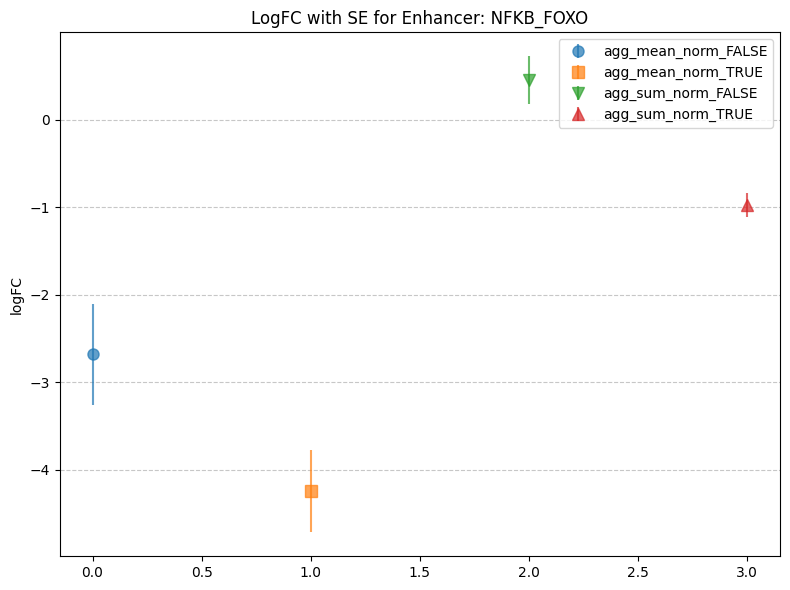

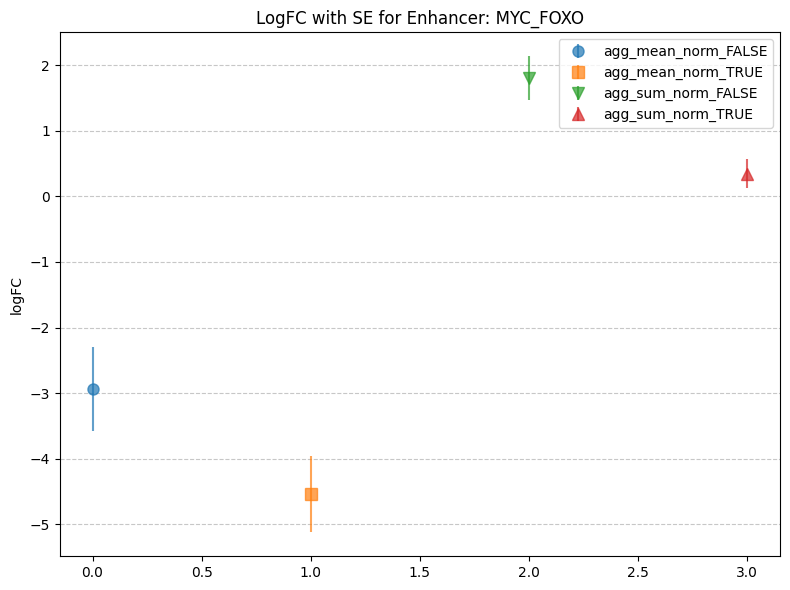

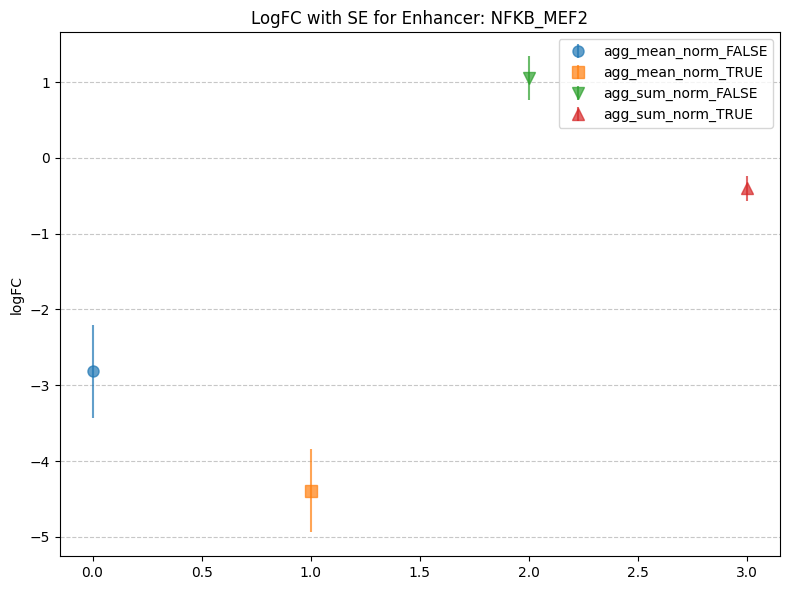

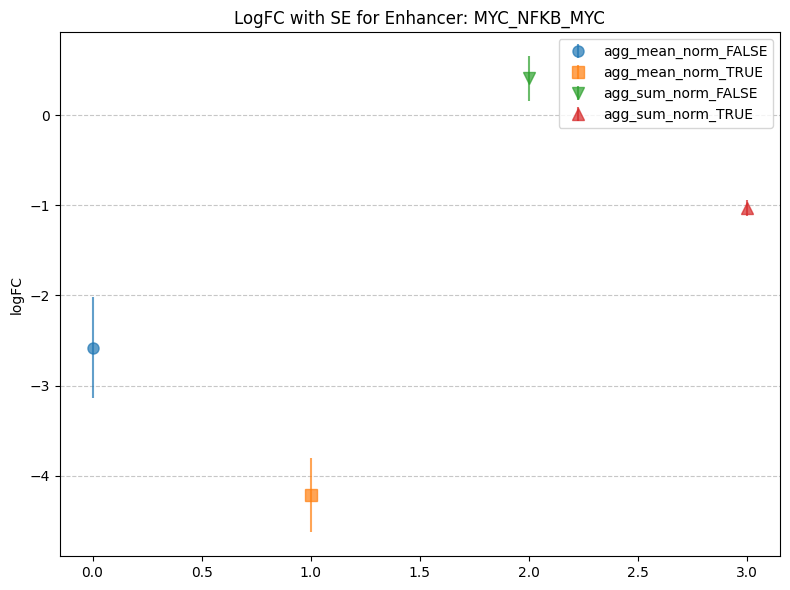

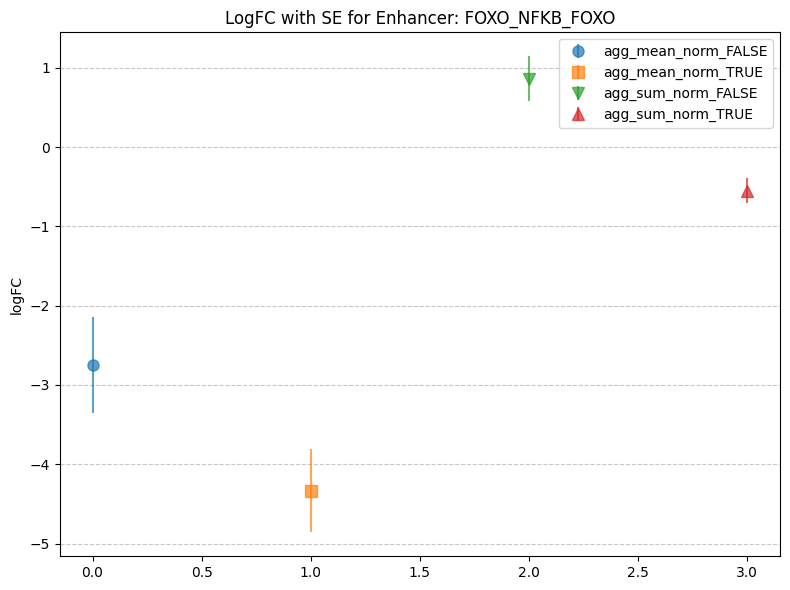

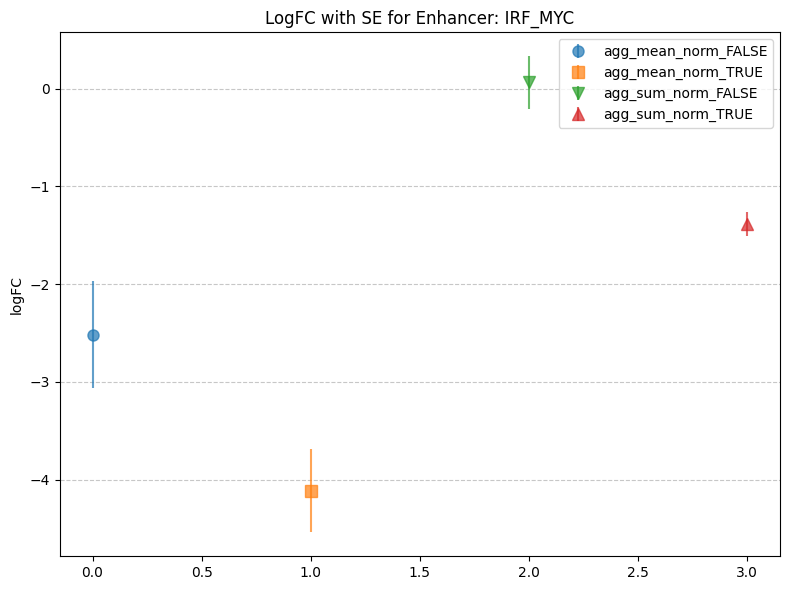

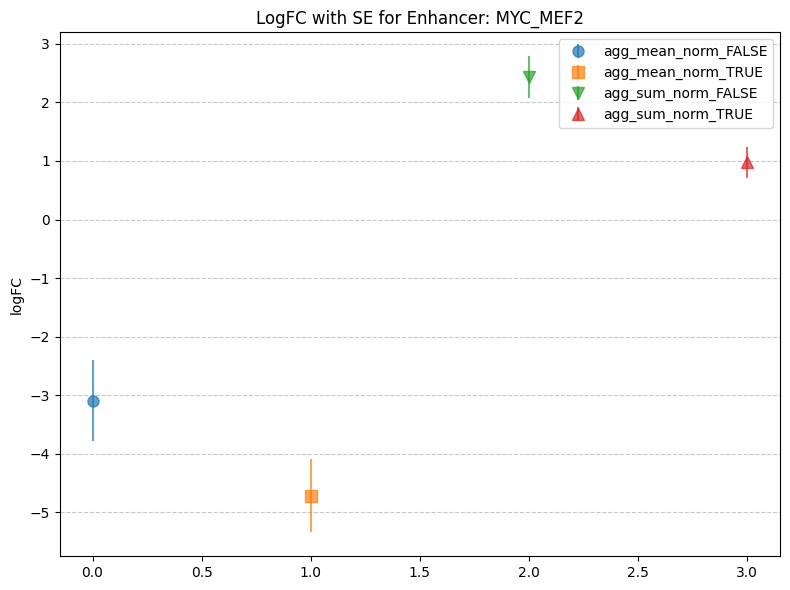

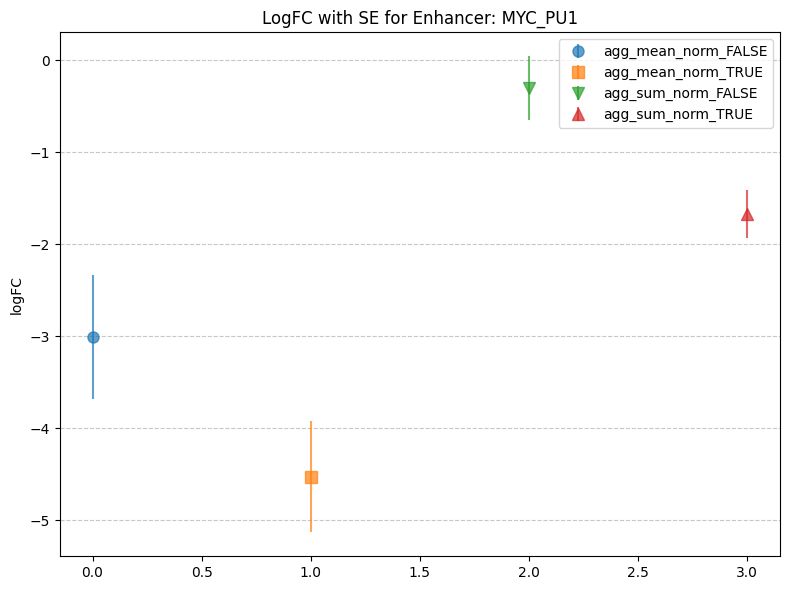

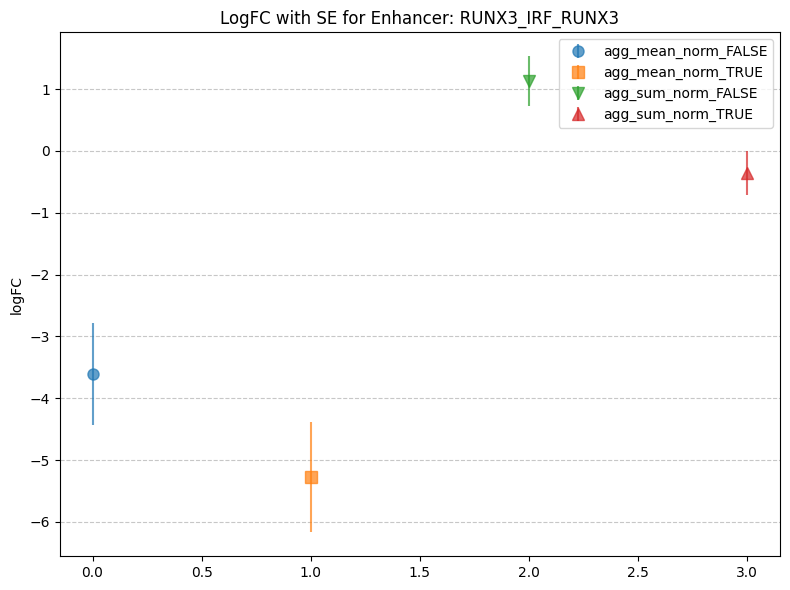

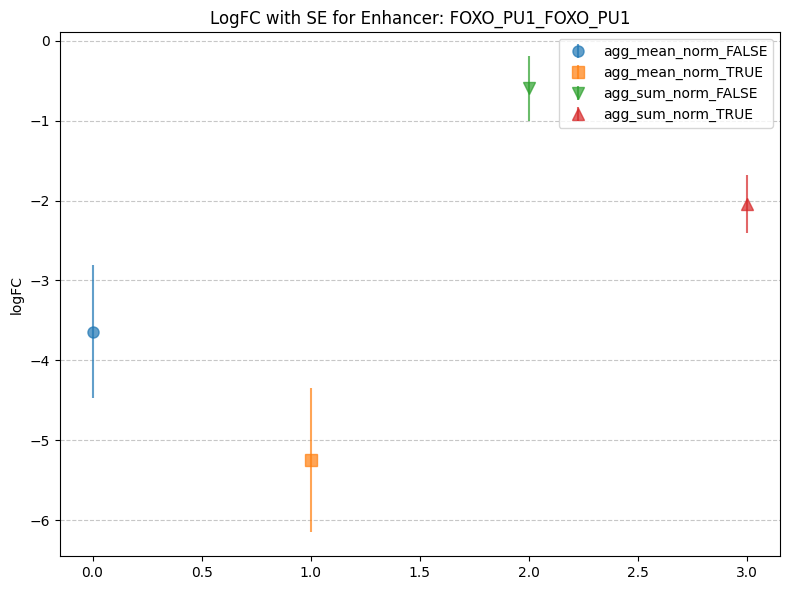

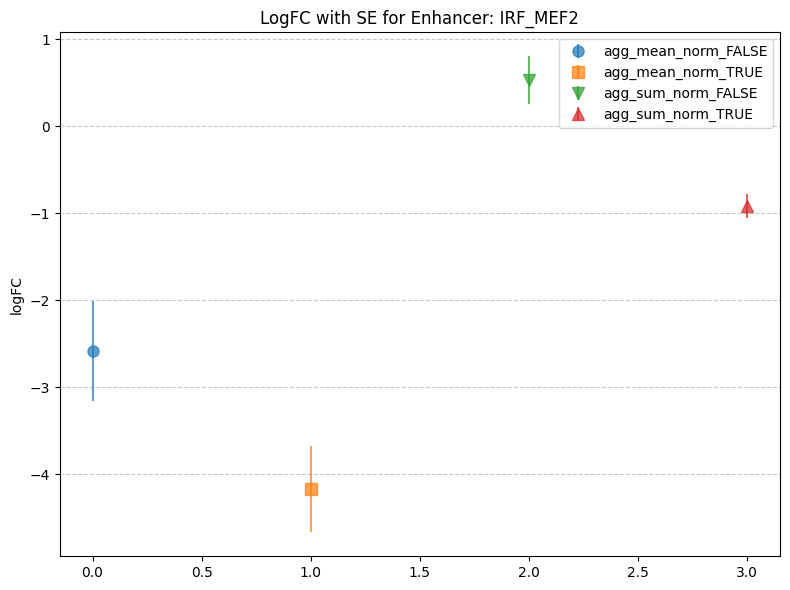

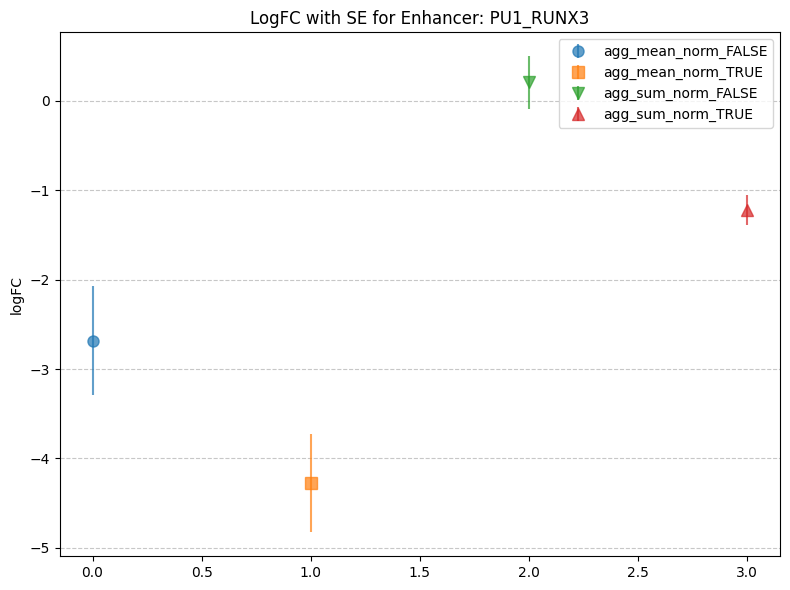

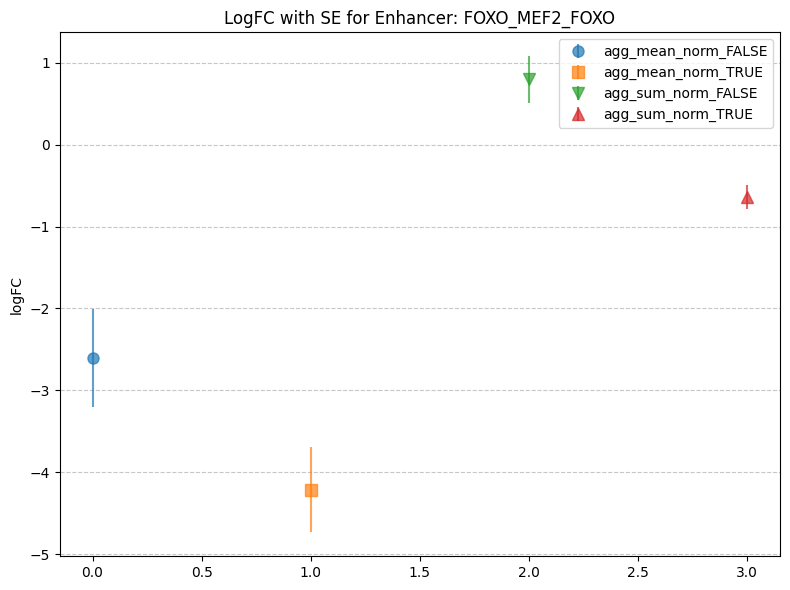

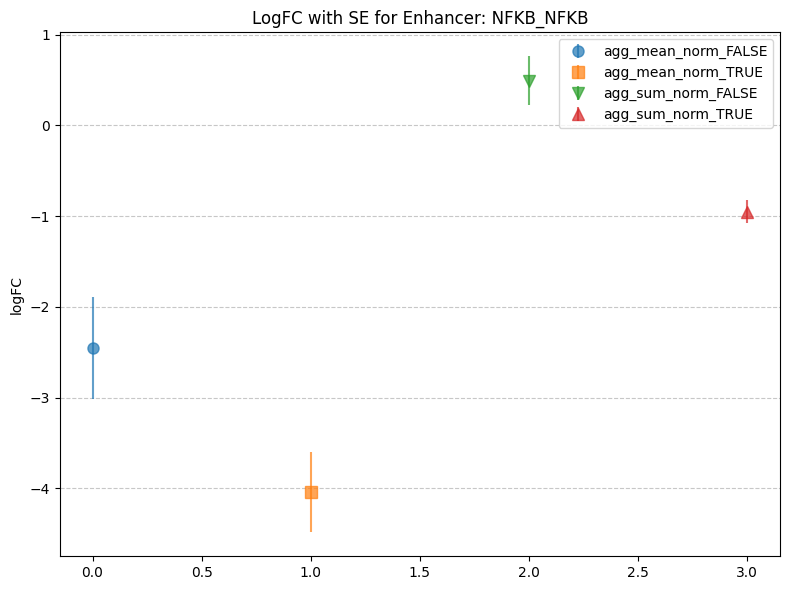

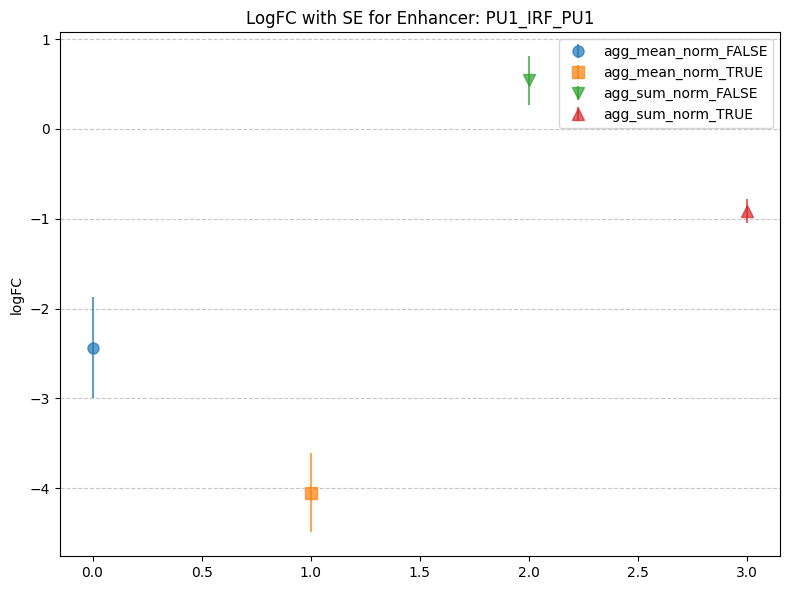

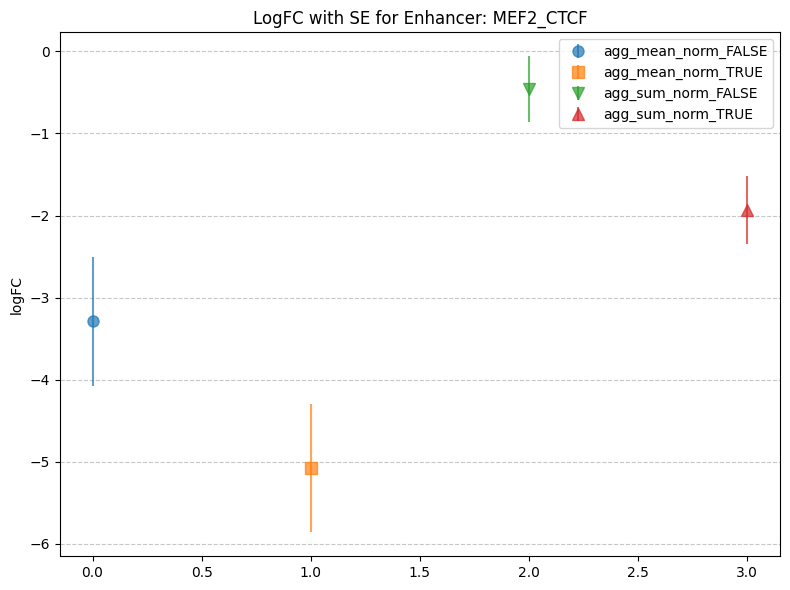

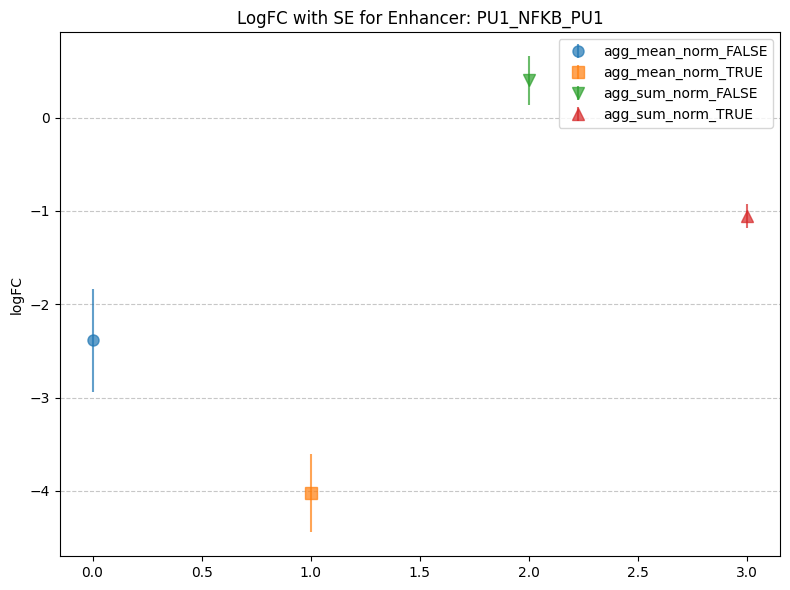

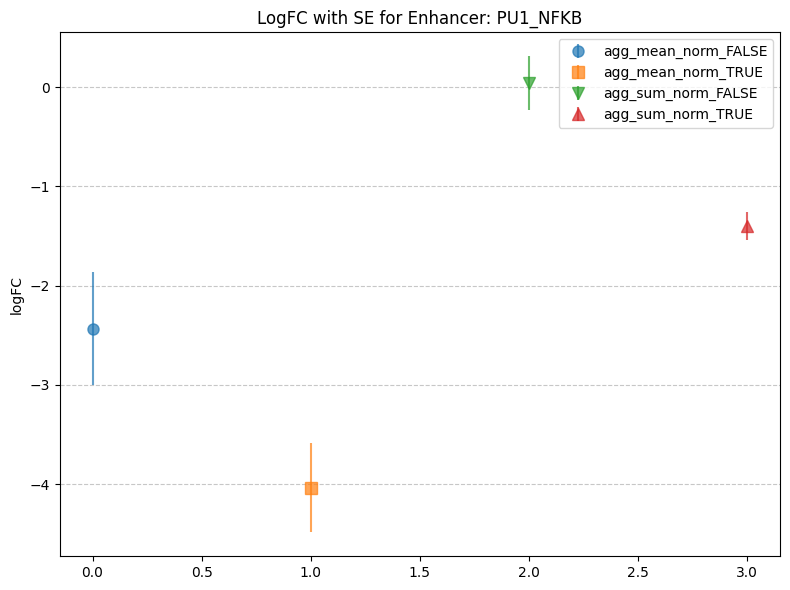

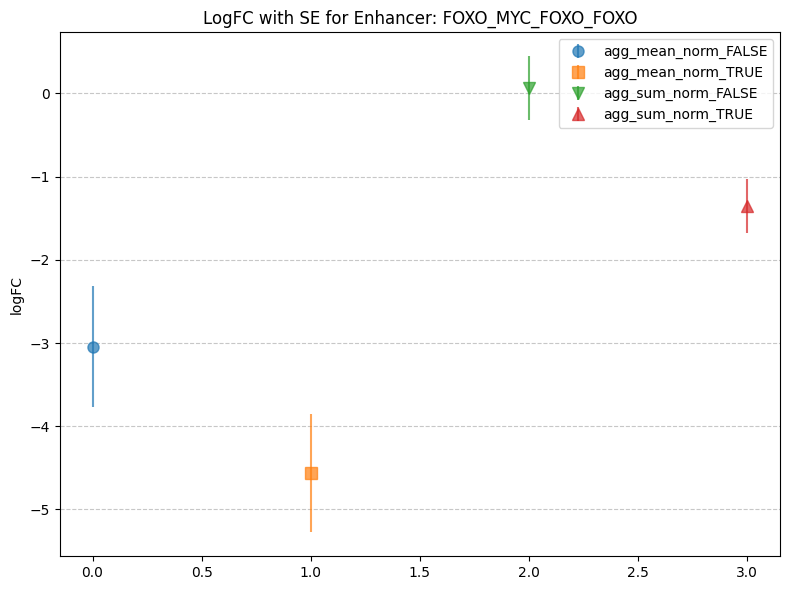

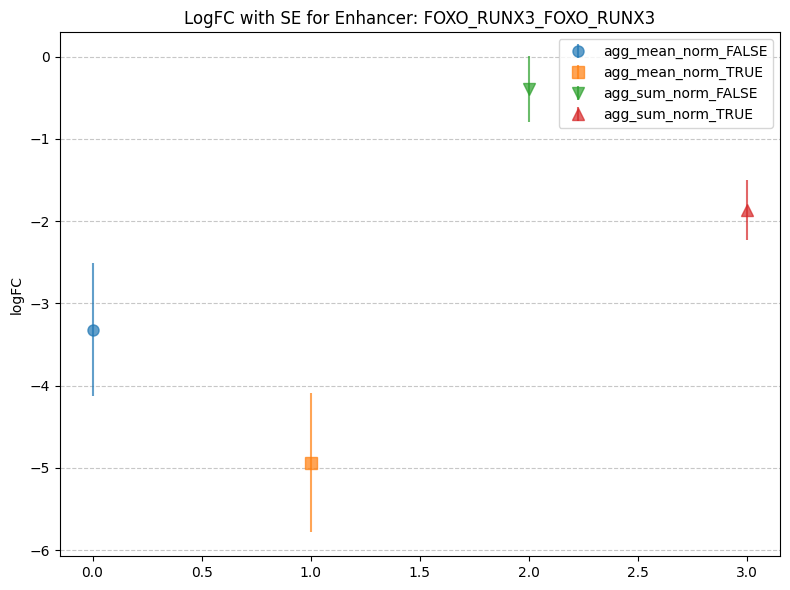

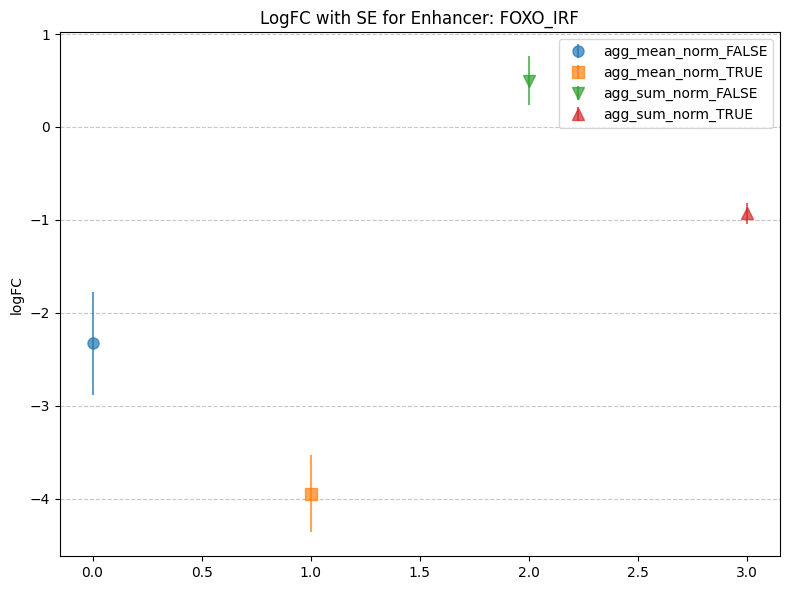

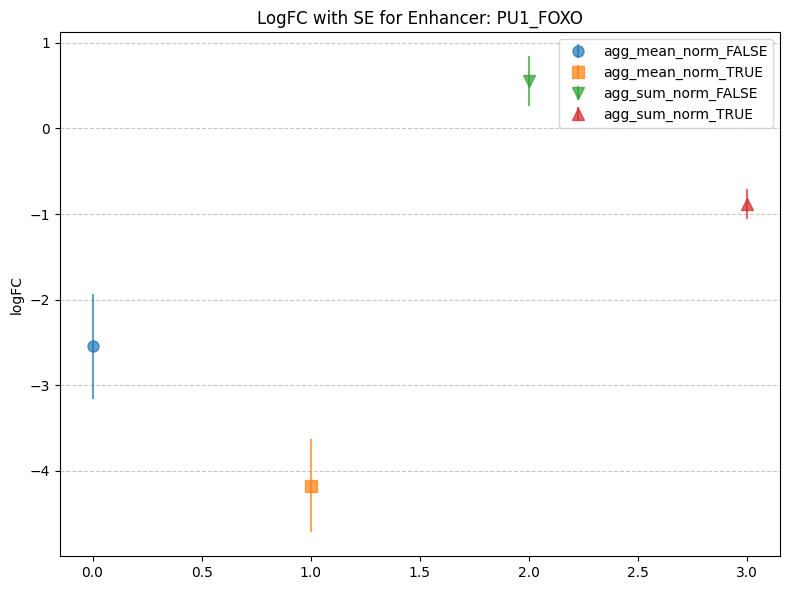

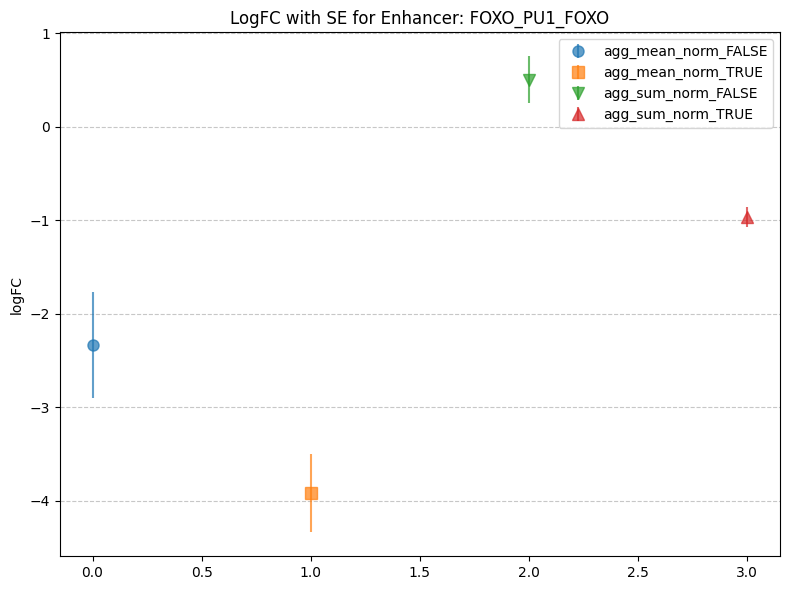

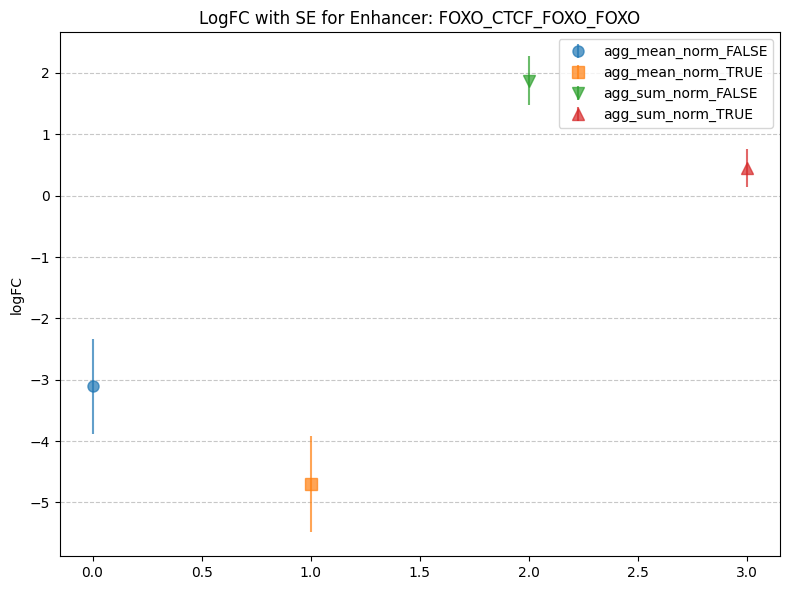

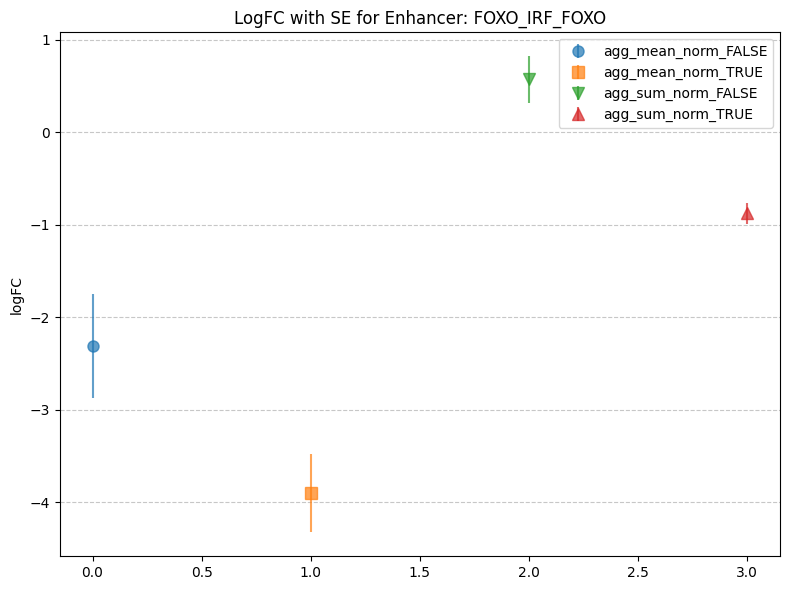

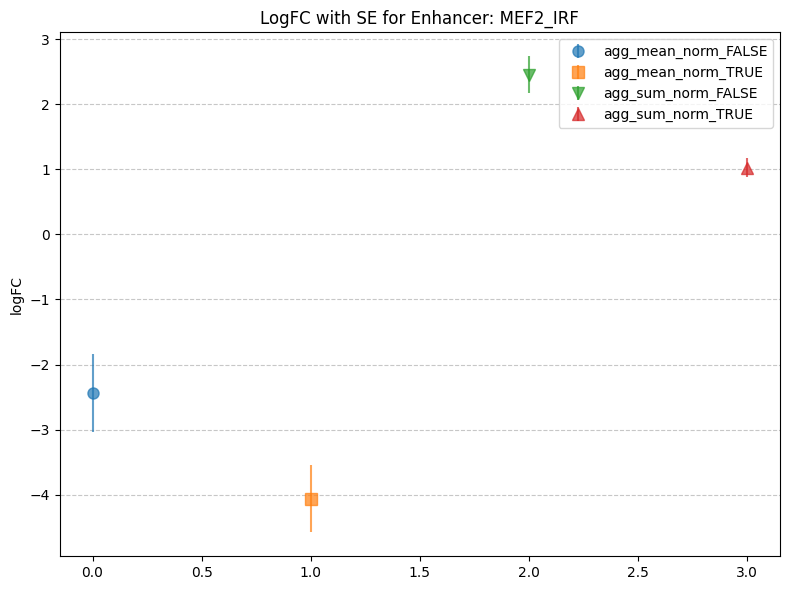

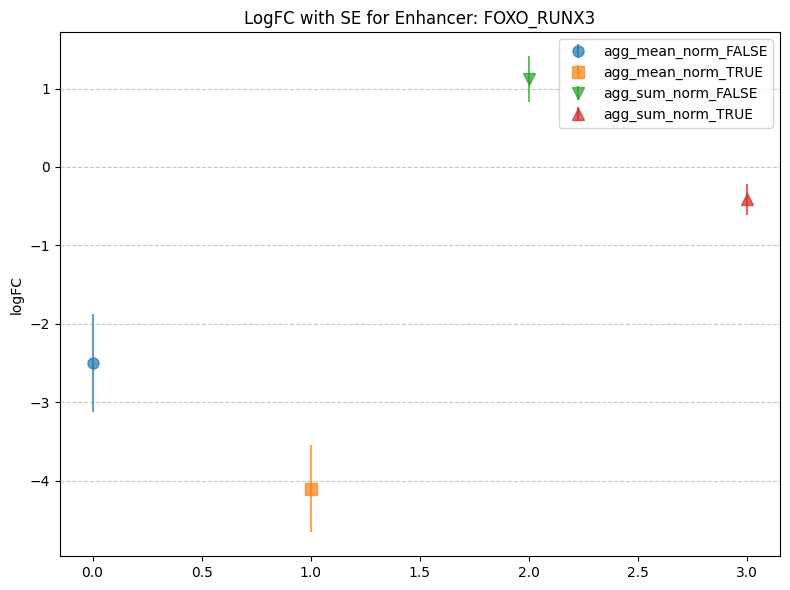

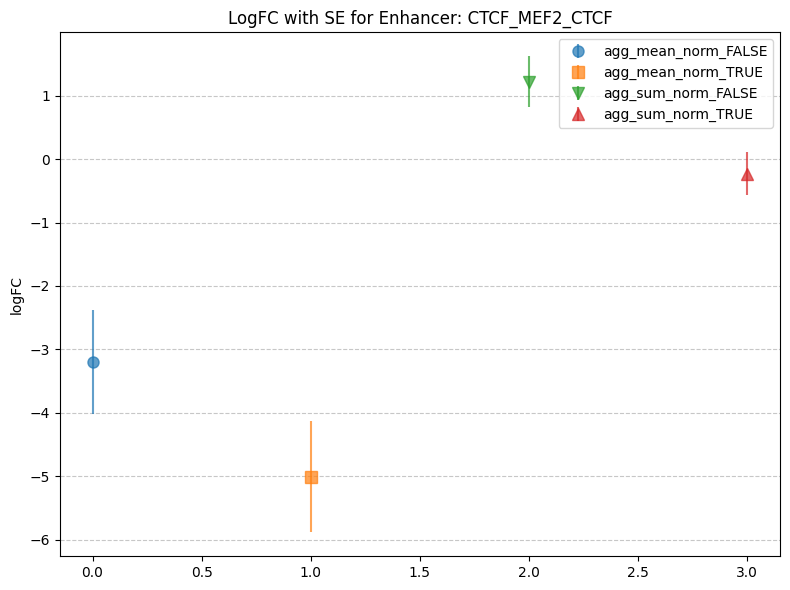

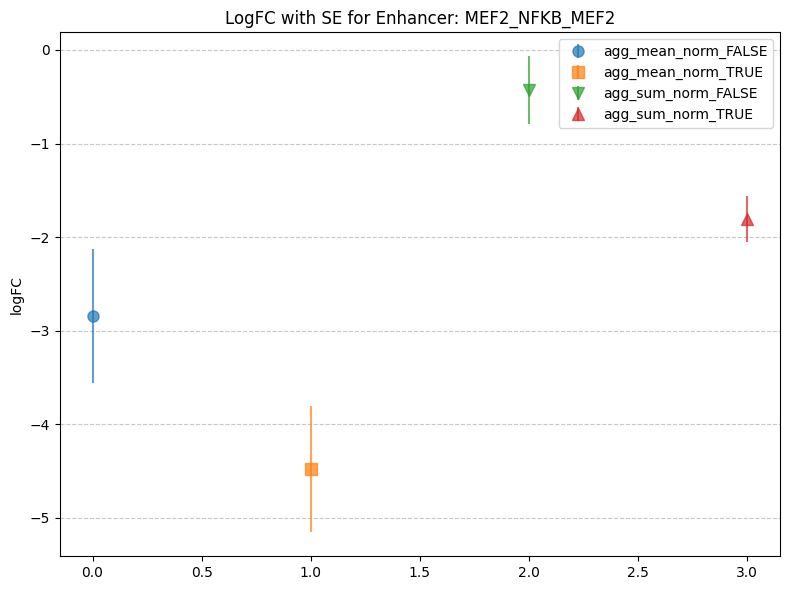

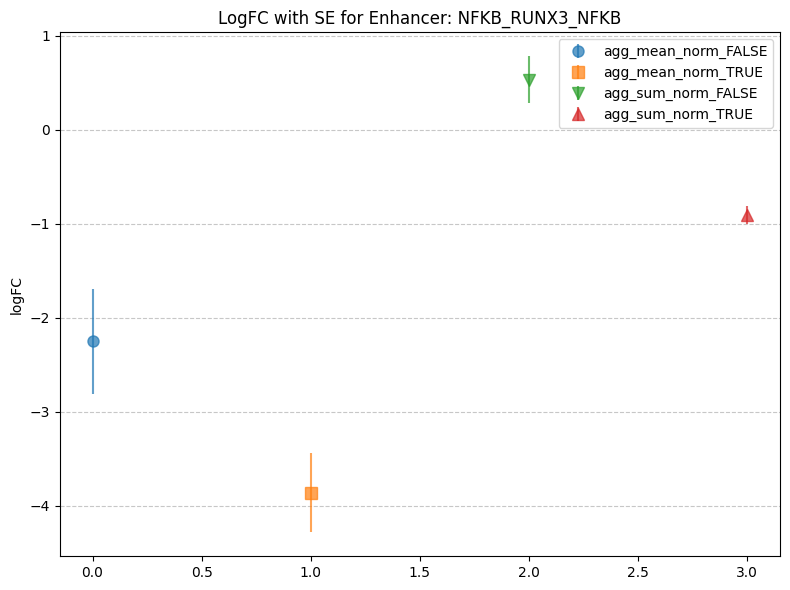

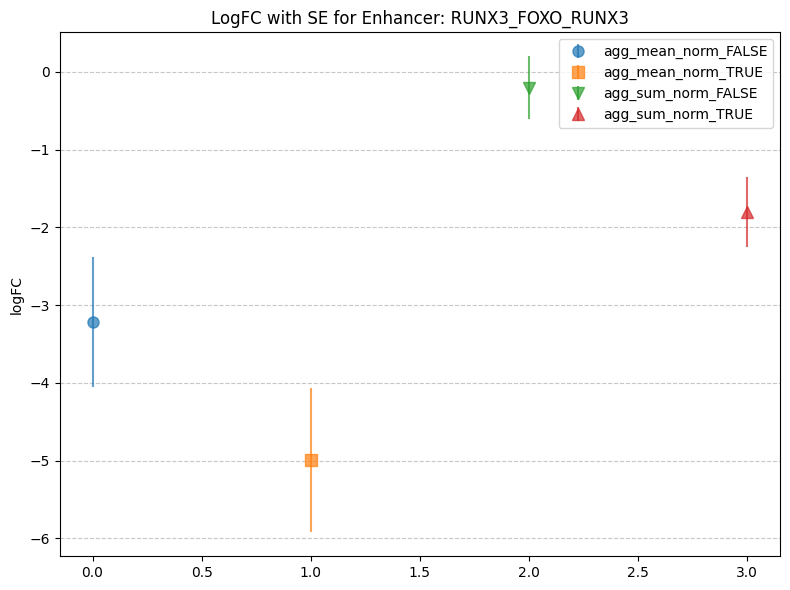

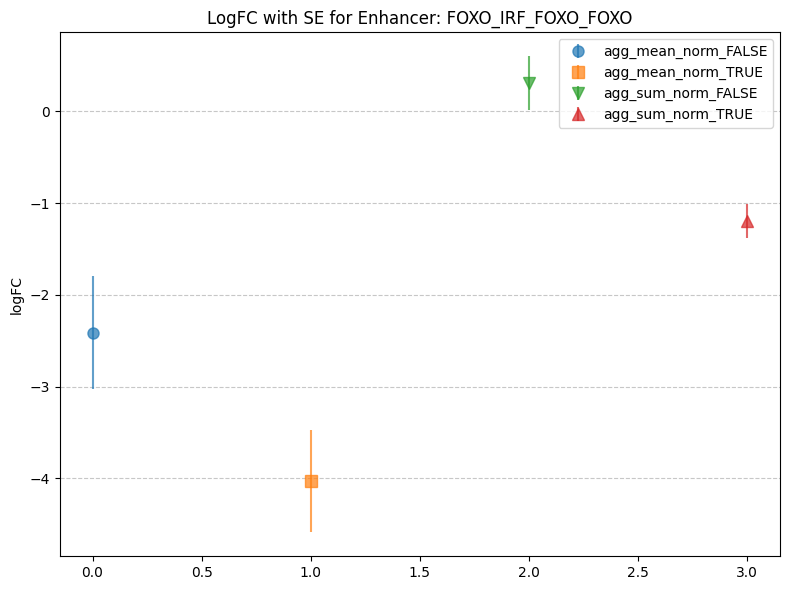

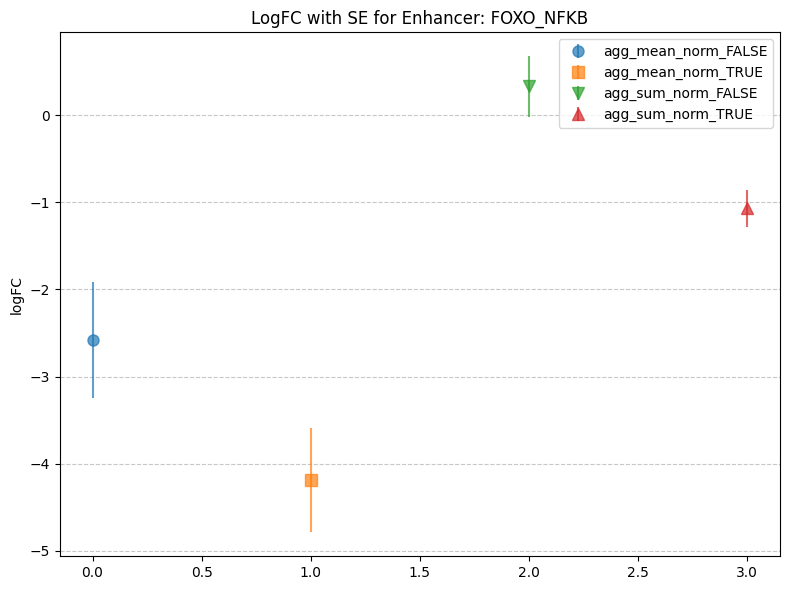

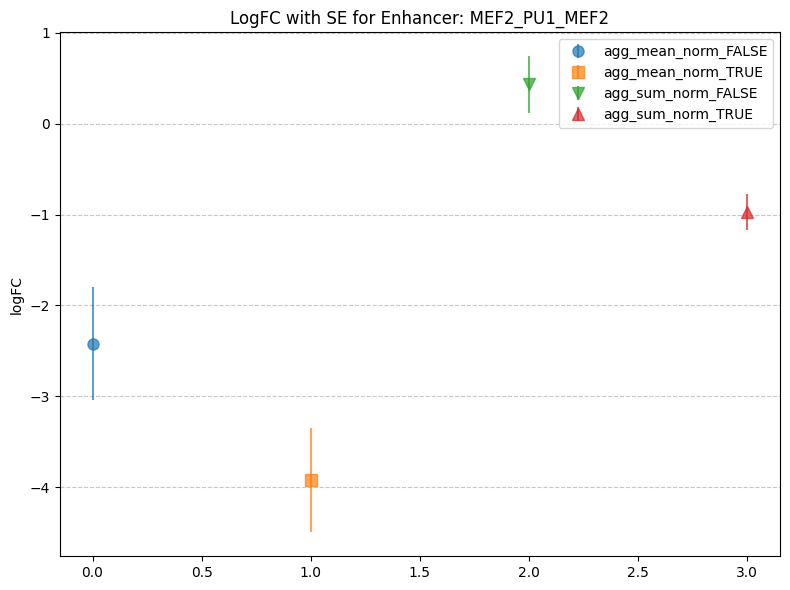

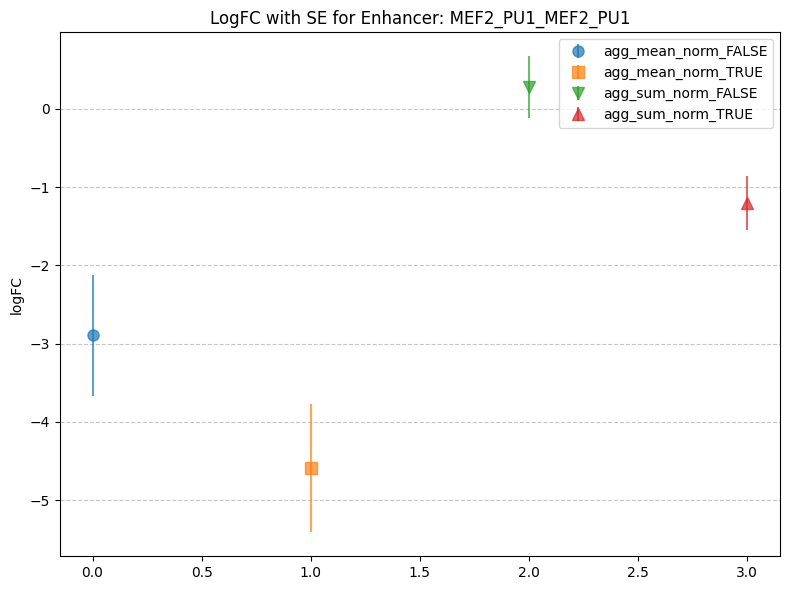

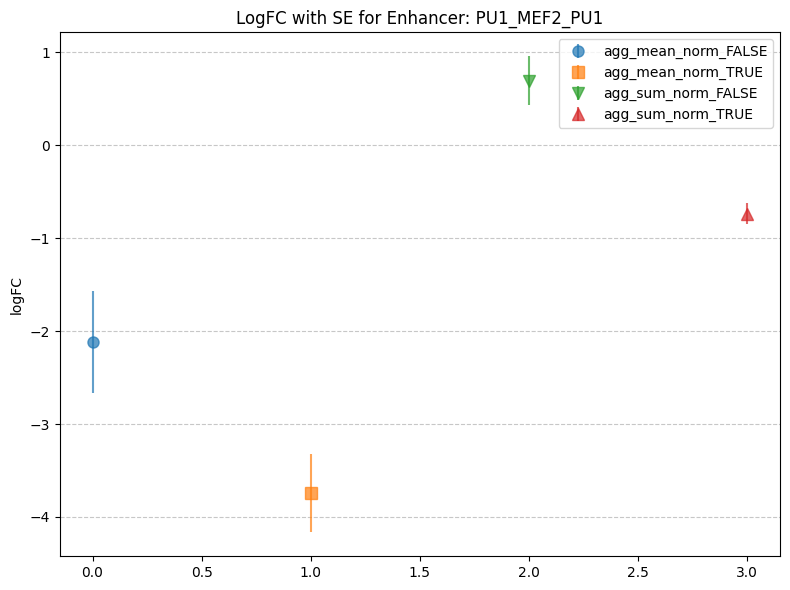

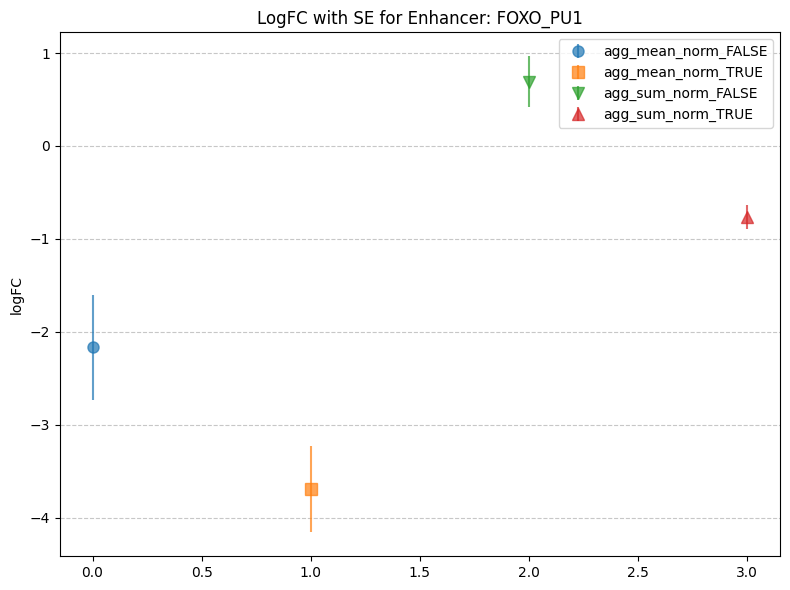

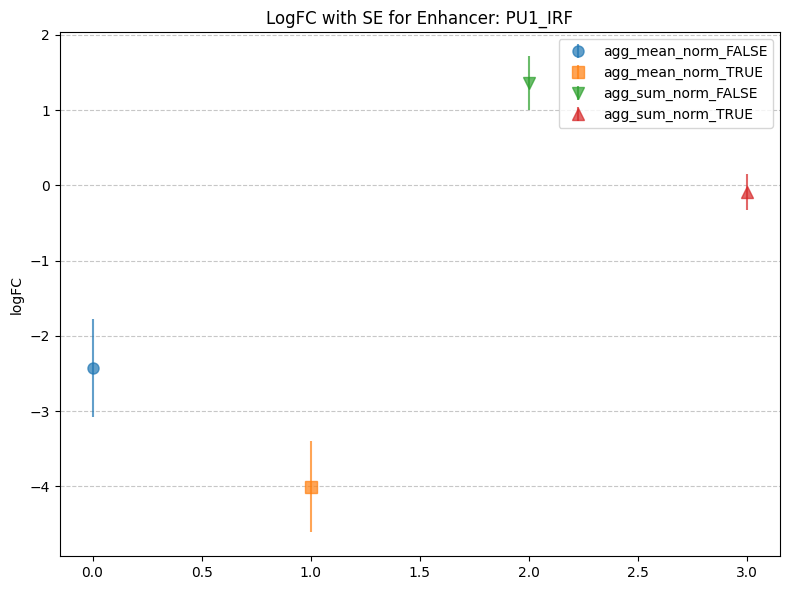

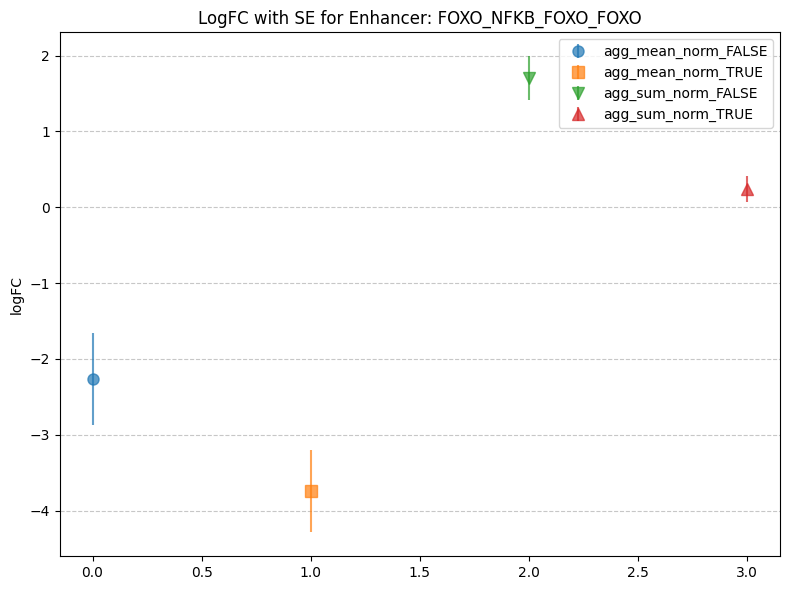

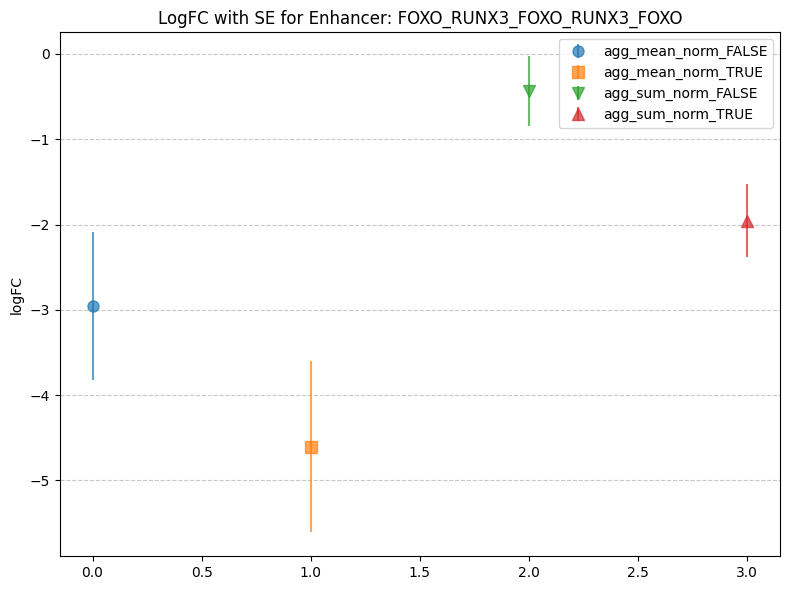

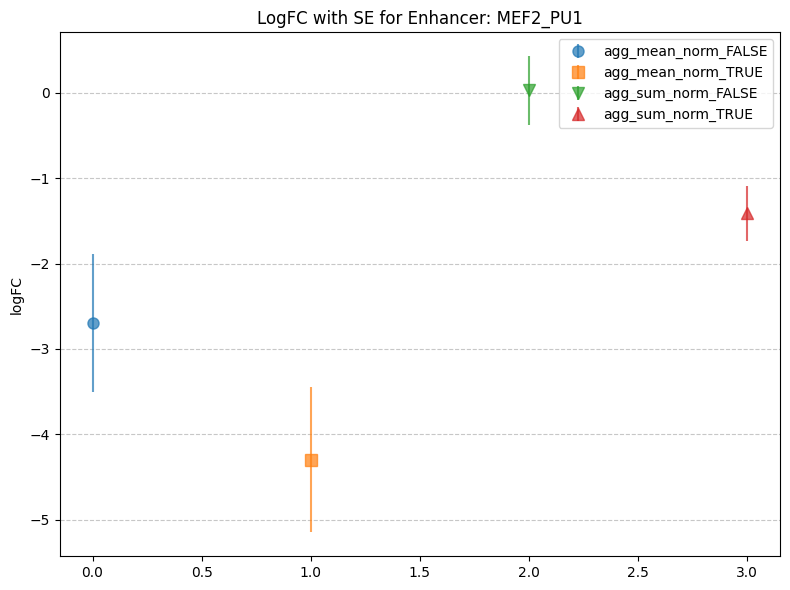

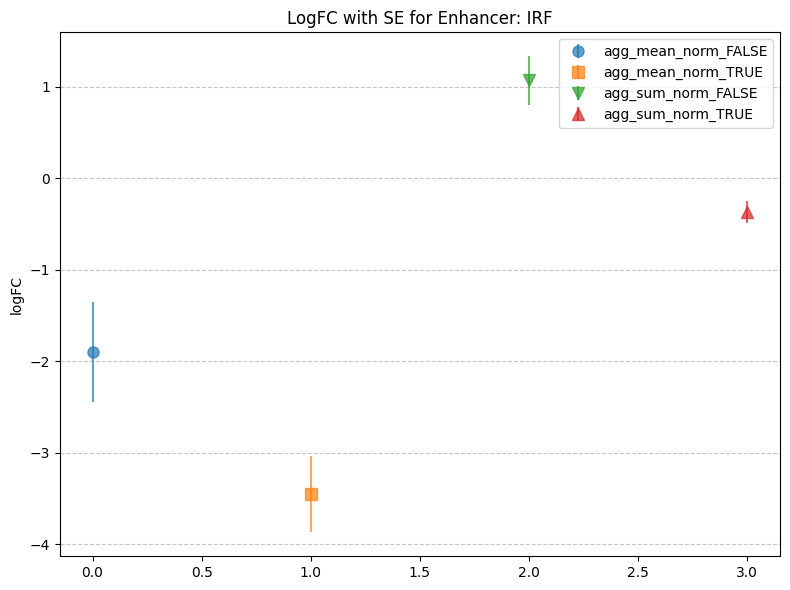

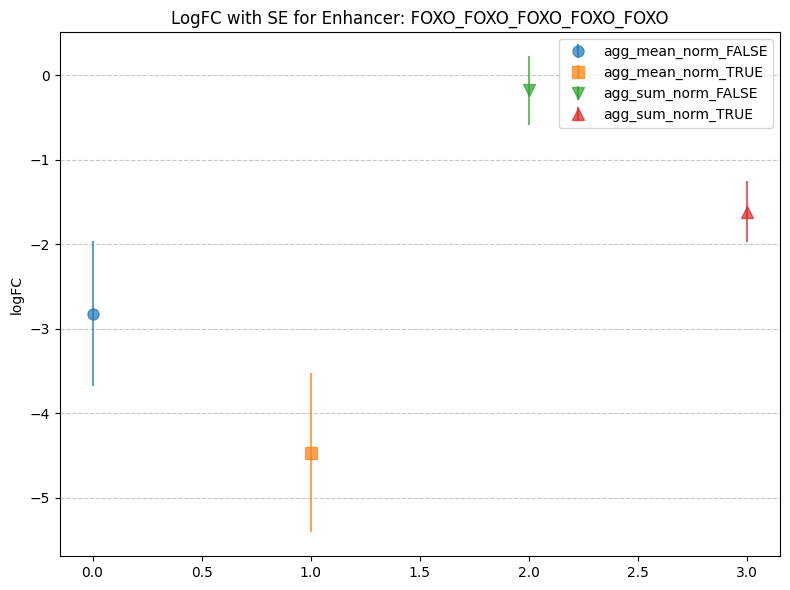

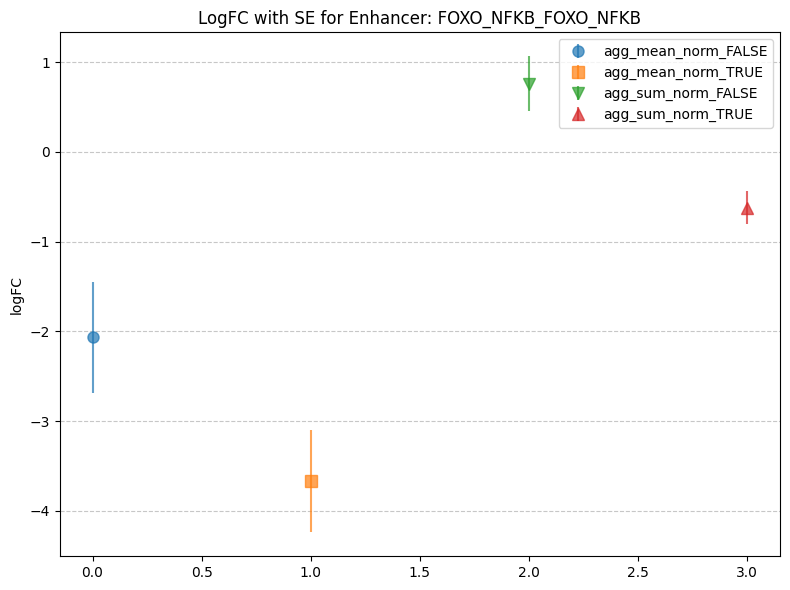

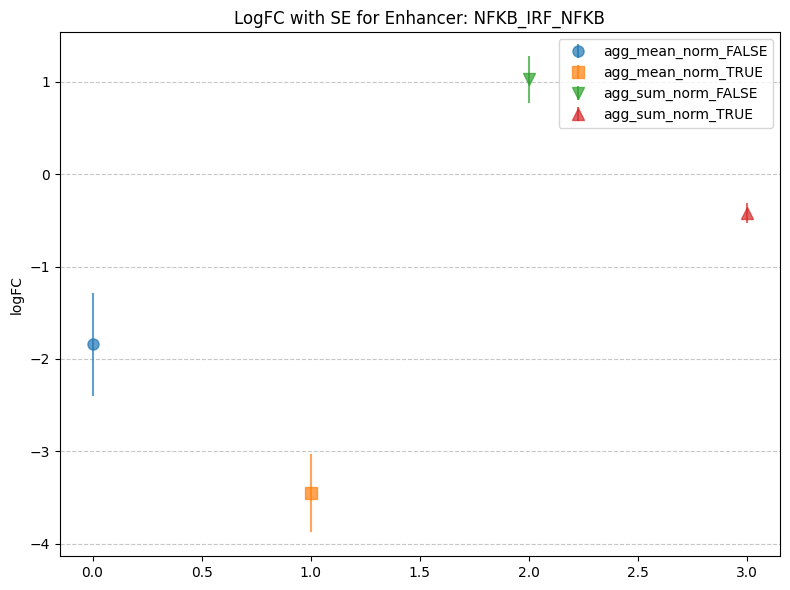

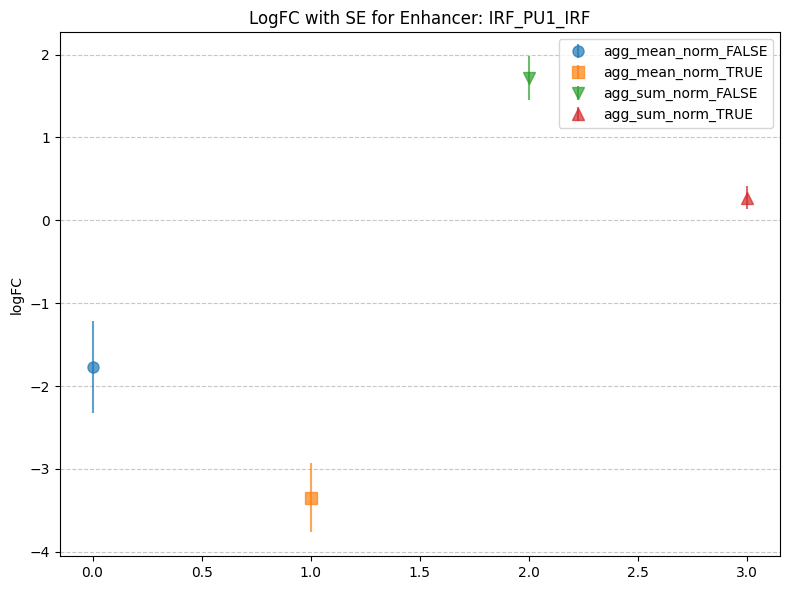

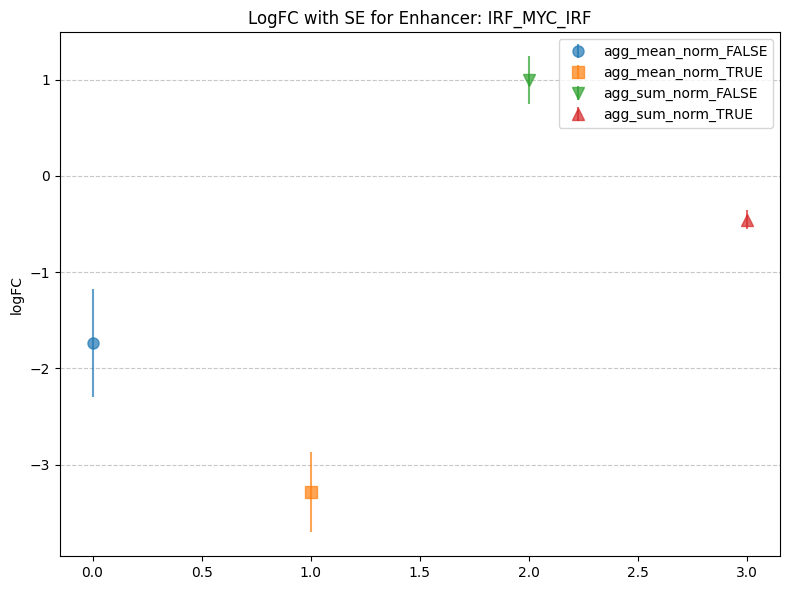

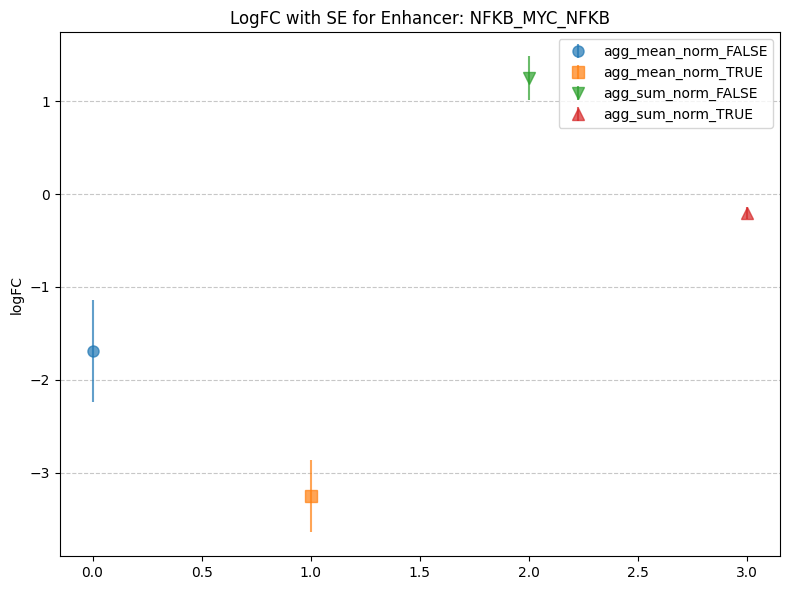

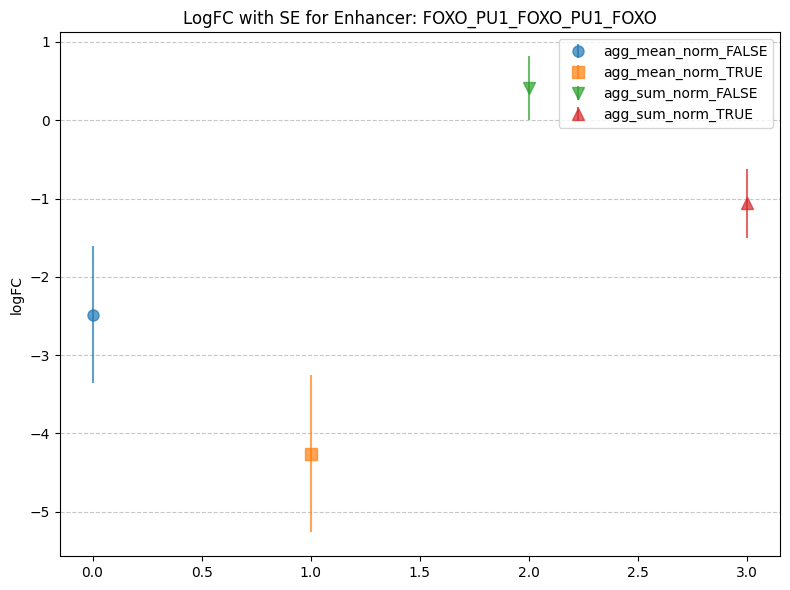

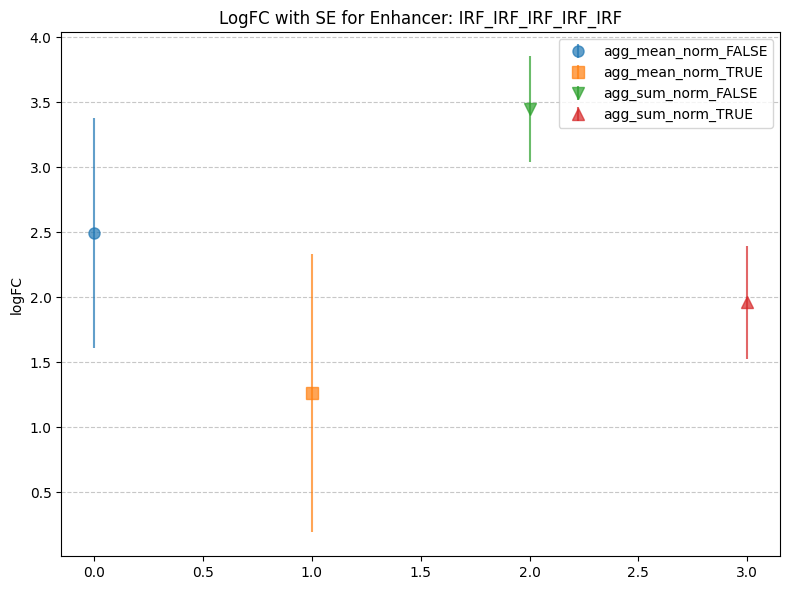

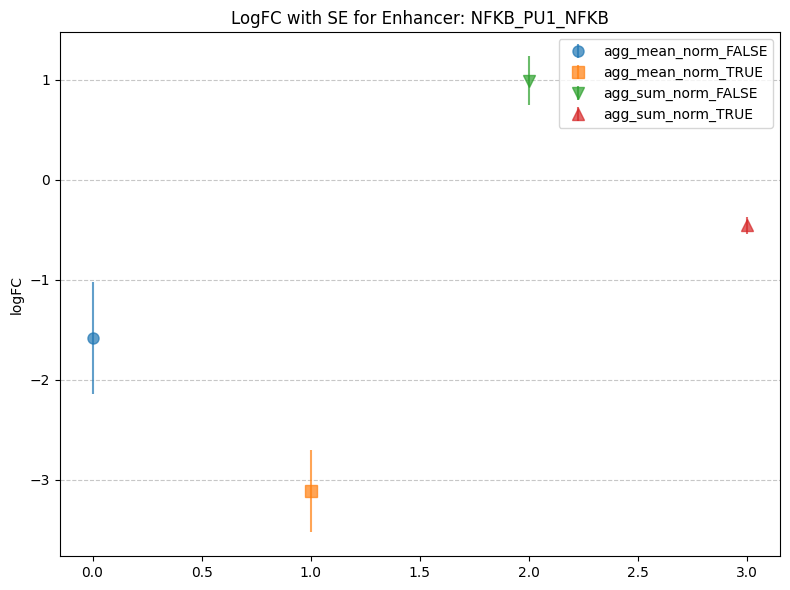

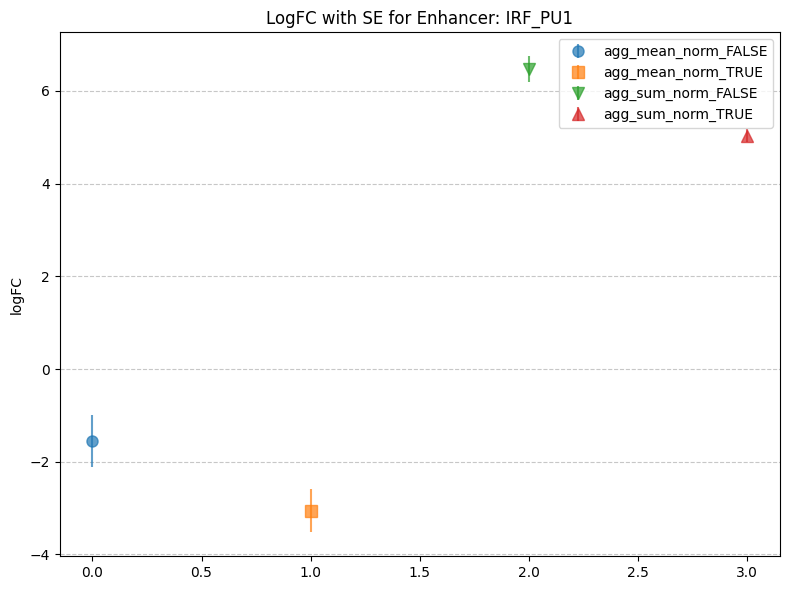

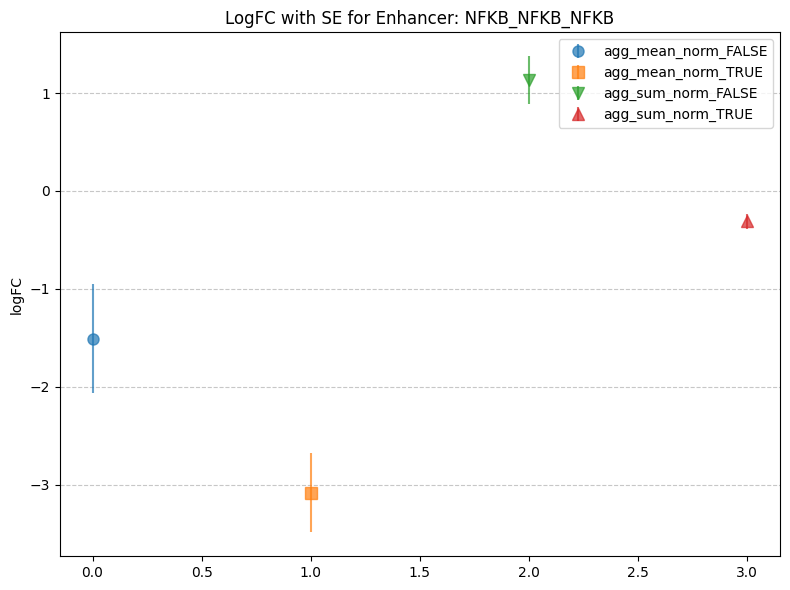

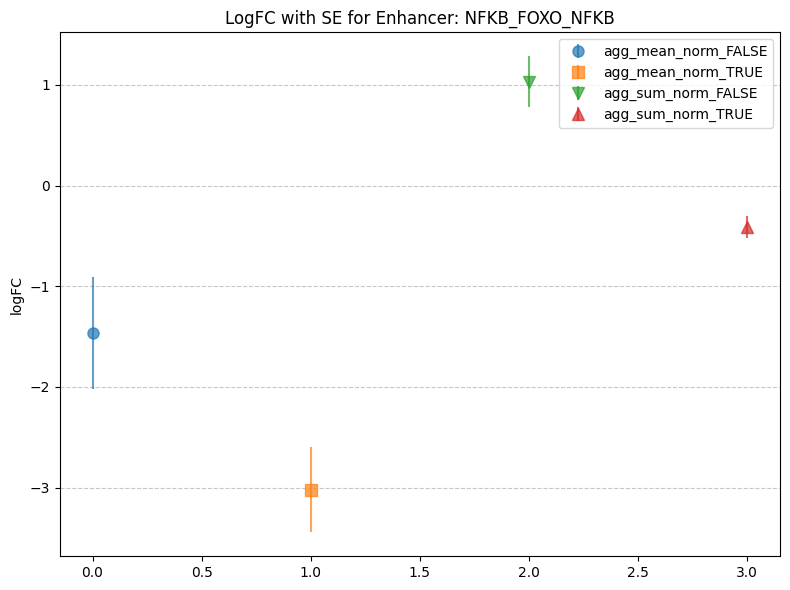

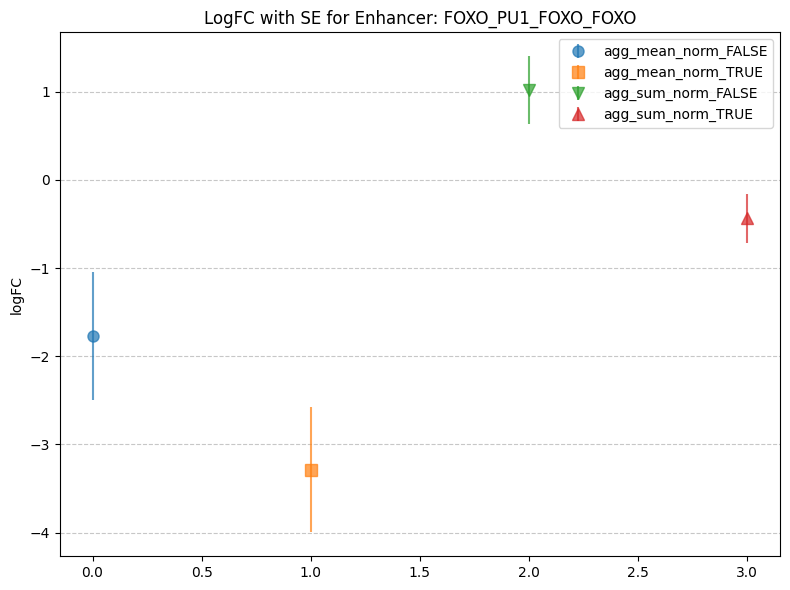

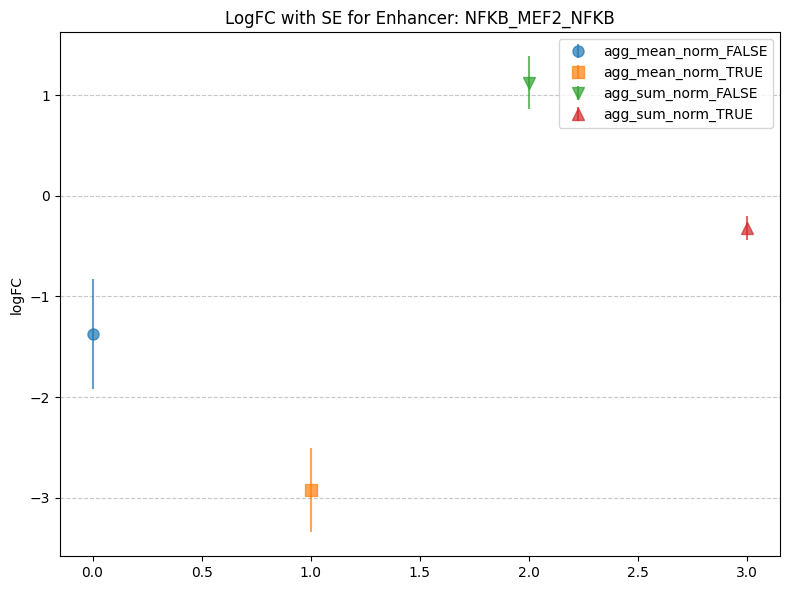

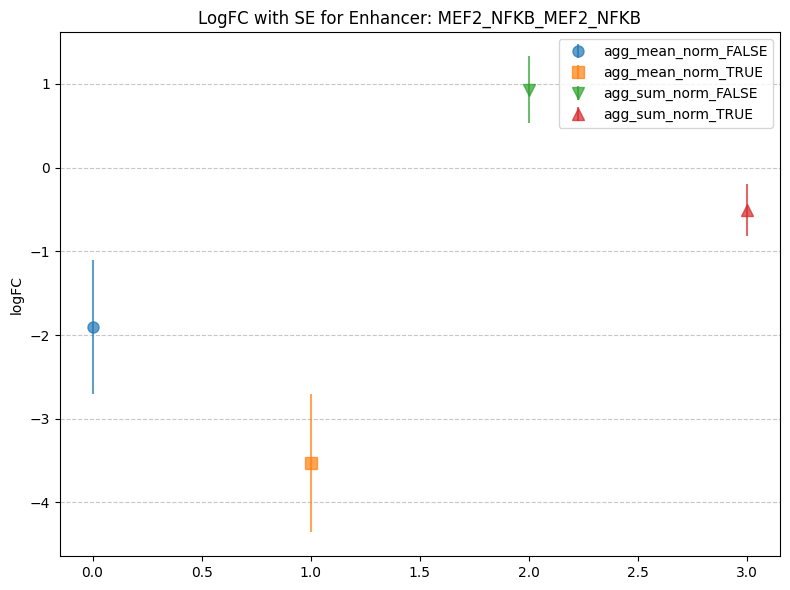

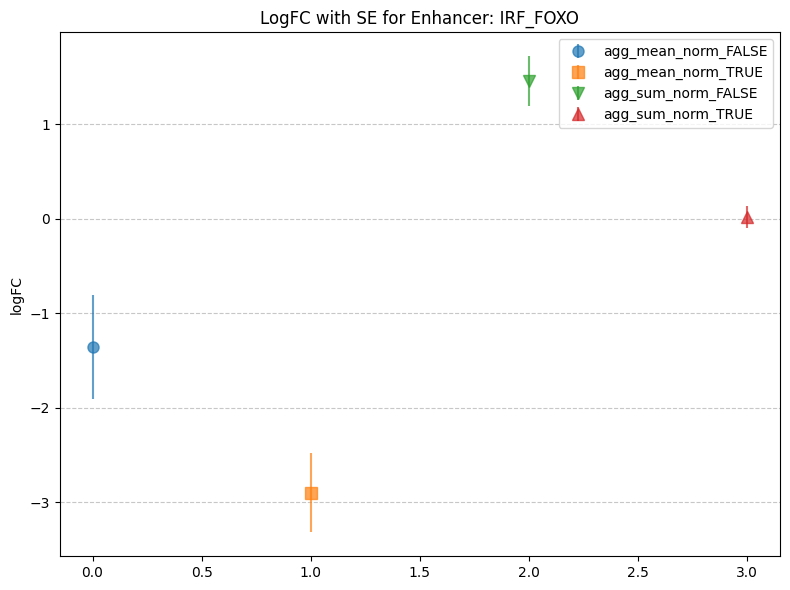

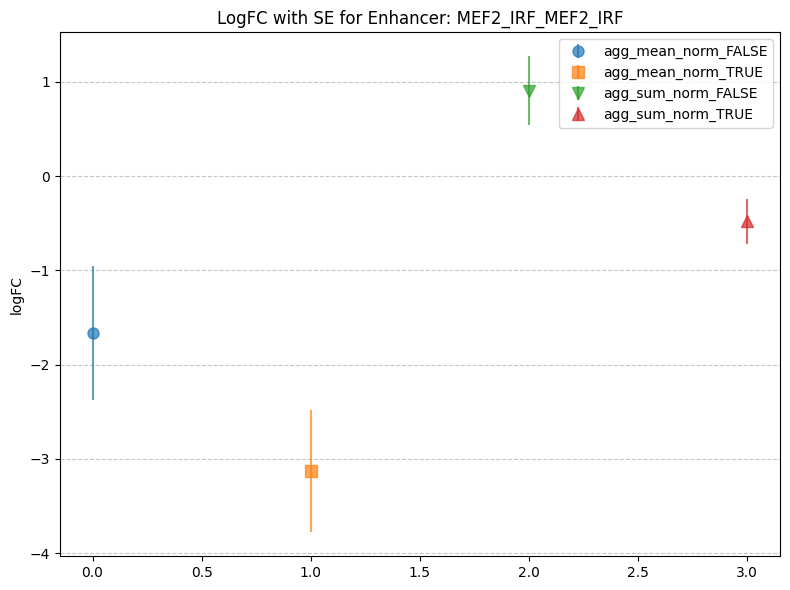

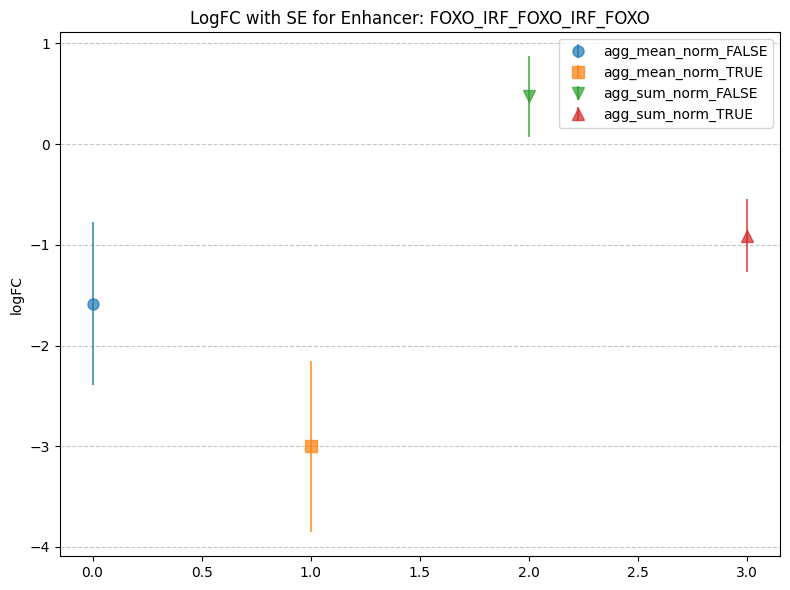

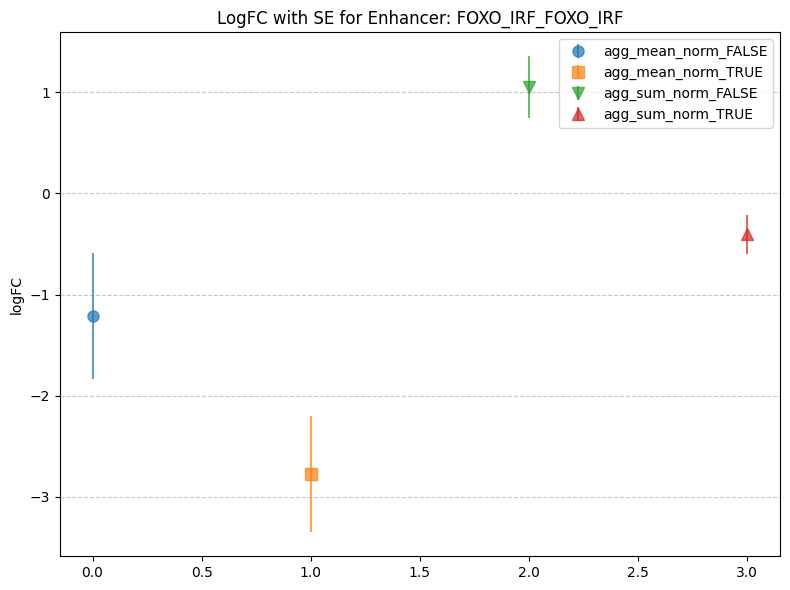

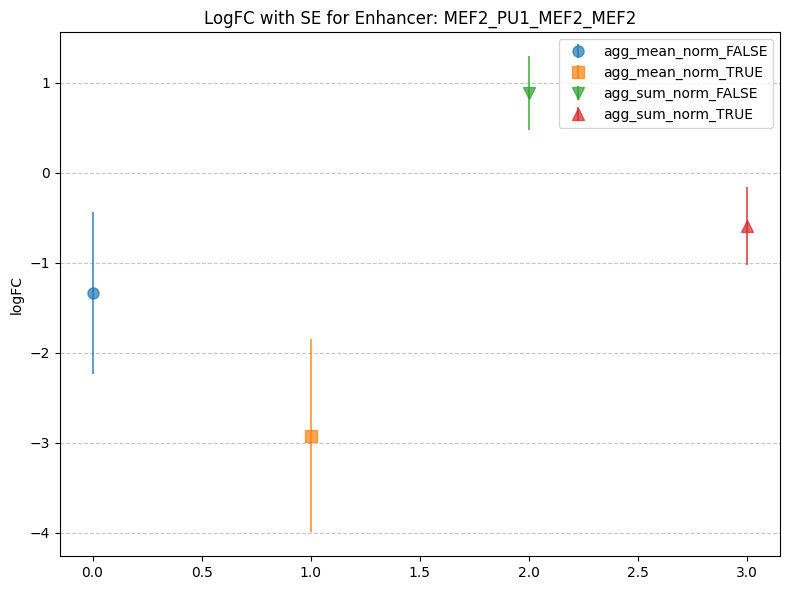

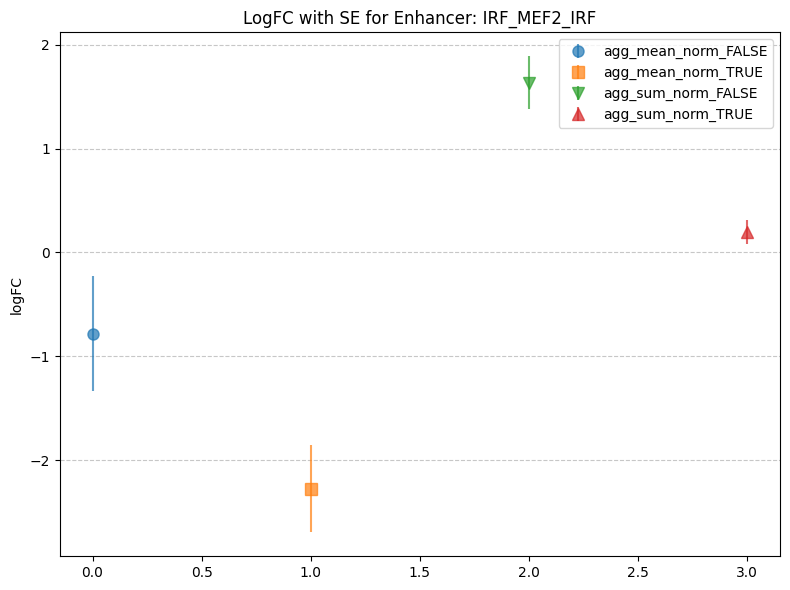

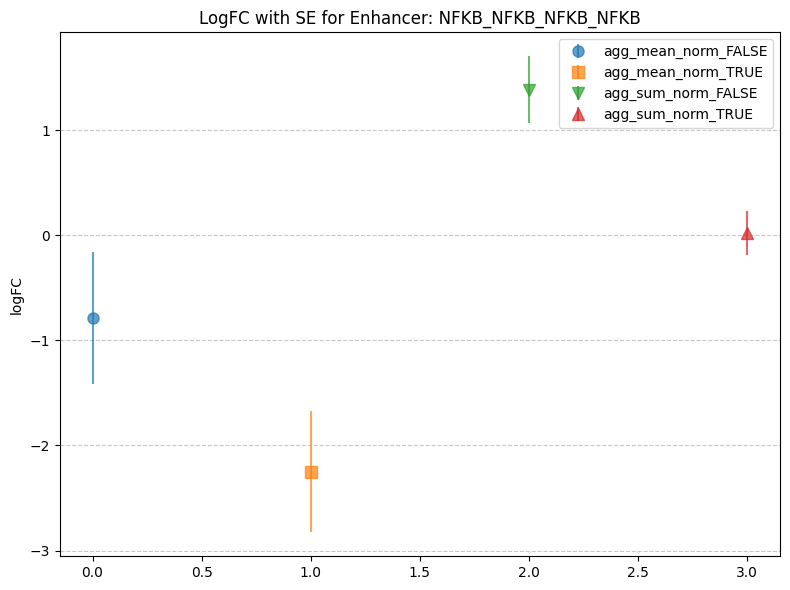

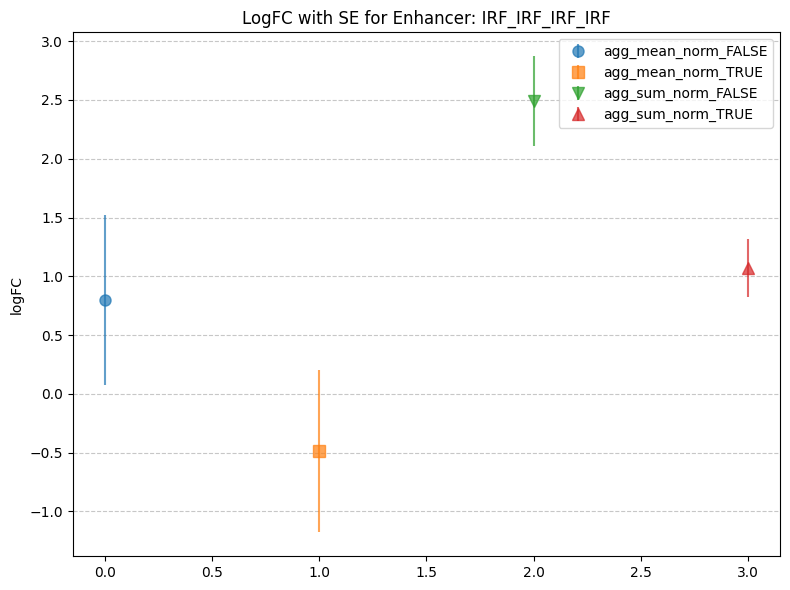

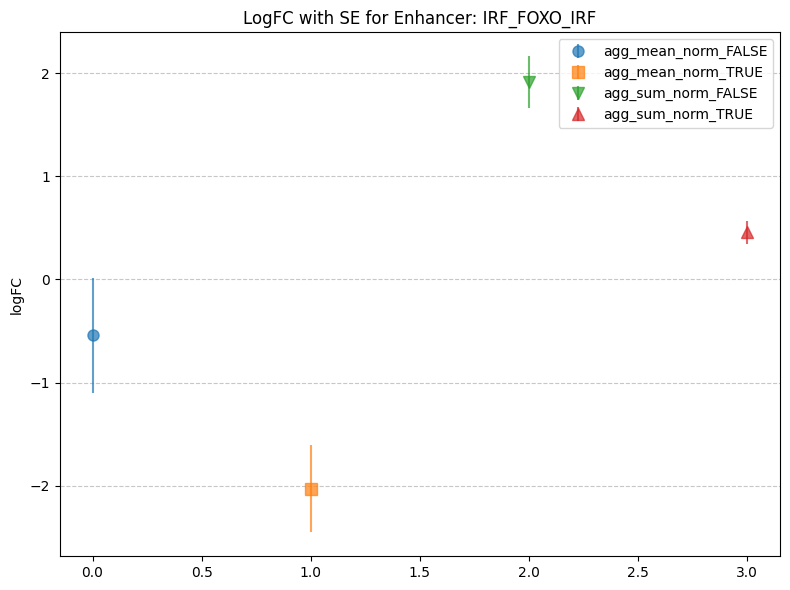

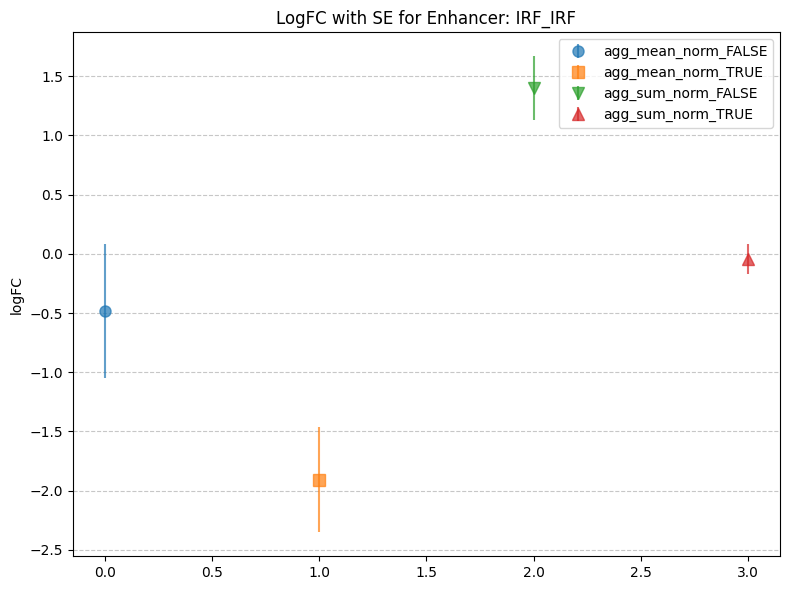

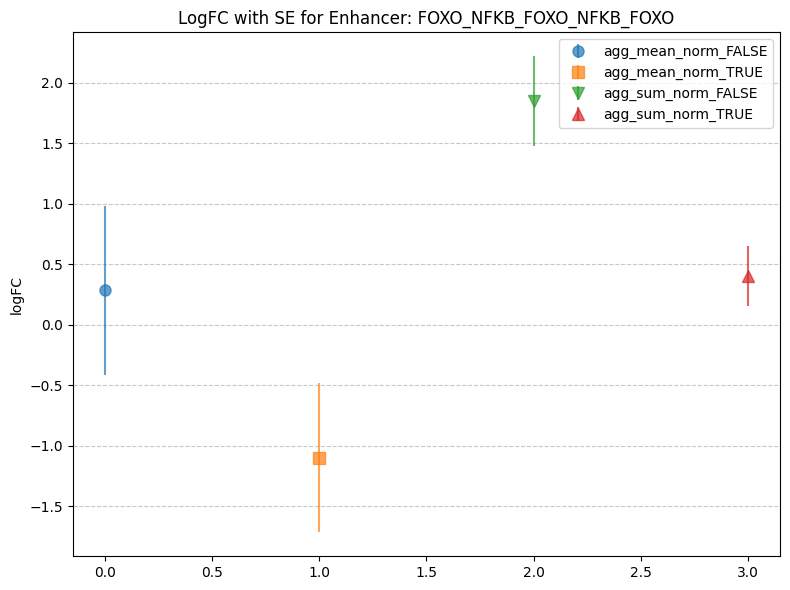

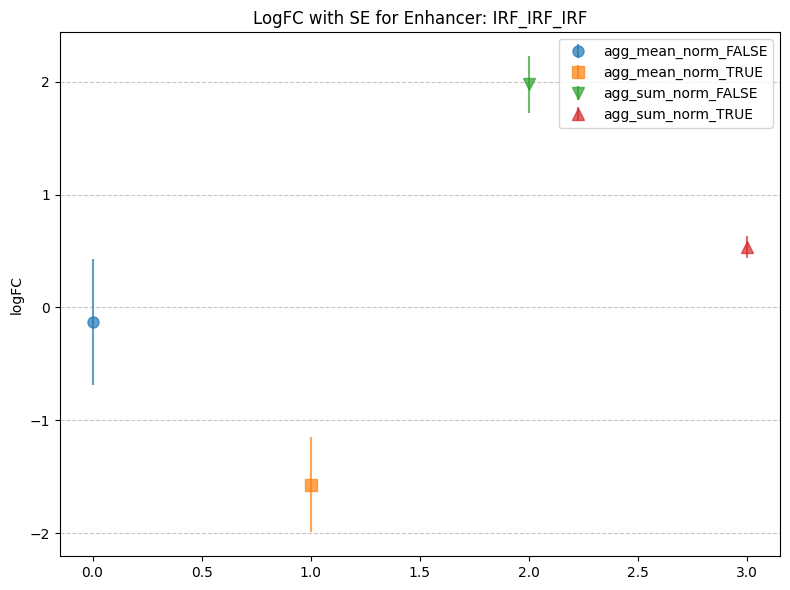

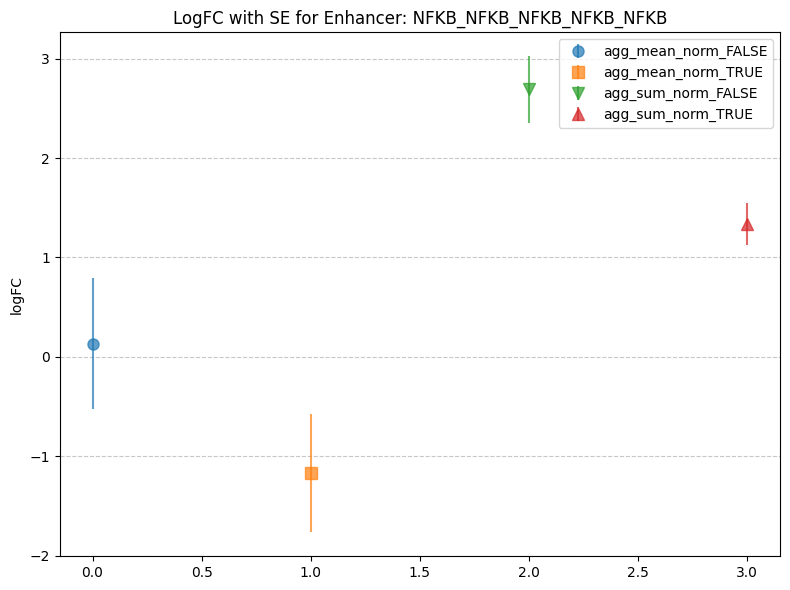

In [11]:
conditions = ['agg_mean_norm_FALSE', 'agg_mean_norm_TRUE', 
              'agg_sum_norm_FALSE', 'agg_sum_norm_TRUE']
marker_styles = ['o', 's', 'v', '^'] 

for enhancer_idx in range(len(merged_df)):
    enhancer_name = merged_df.iloc[enhancer_idx]['Enhancer']
    plt.figure(figsize=(8, 6))
    
    for i, condition in enumerate(conditions):
        logFC_values = merged_df.iloc[enhancer_idx][f'logFC_{condition}']
        SE_values = merged_df.iloc[enhancer_idx][f'SE_{condition}']
        
        plt.errorbar(
            i, logFC_values, yerr=SE_values, fmt=marker_styles[i],
            label=condition, markersize=8, alpha=0.7
        )
    
    plt.ylabel('logFC')
    plt.title(f'LogFC with SE for Enhancer: {enhancer_name}')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    plt.legend()
    
    plot_filename = f"{enhancer_name}_logFC_with_SE.png"
    plt.tight_layout()
    # plt.save_fig(plot_filename)
    plt.show()
    plt.close()

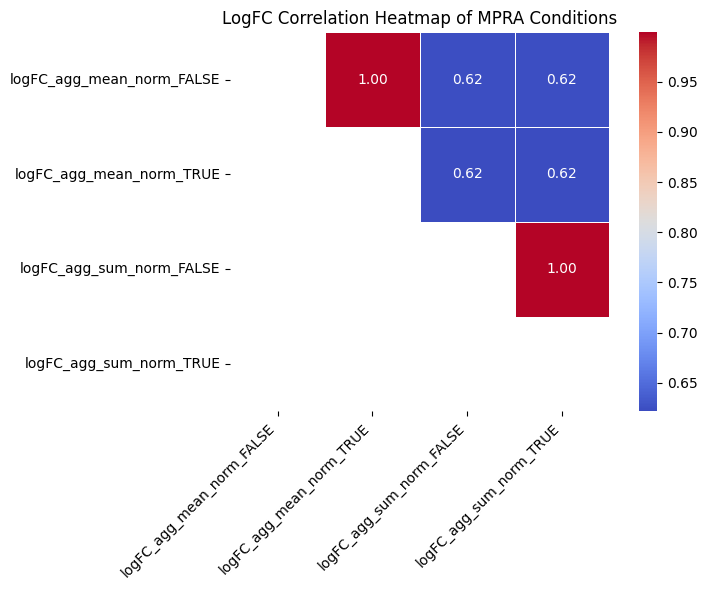

In [12]:
logfc_cols = [col for col in merged_df.columns if col.startswith('logFC')]
logfc_df = merged_df[logfc_cols]

cor_matrix = logfc_df.corr()

mask = np.tril(np.ones_like(cor_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("LogFC Correlation Heatmap of MPRA Conditions")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

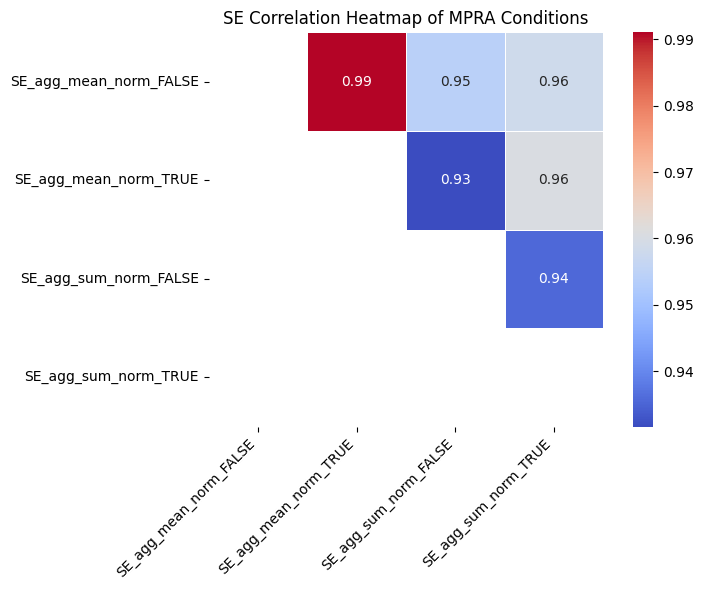

In [13]:
se_cols = [col for col in merged_df.columns if col.startswith('SE')]
se_df = merged_df[se_cols]

cor_matrix = se_df.corr()

mask = np.tril(np.ones_like(cor_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title("SE Correlation Heatmap of MPRA Conditions")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
merged_df[merged_df['Enhancer'] == 'PU1_PU1']

logFC_agg_mean_norm_FALSE  SE_agg_mean_norm_FALSE  \
65                  -3.209395                0.615266   

    logFC_agg_mean_norm_TRUE  SE_agg_mean_norm_TRUE  logFC_agg_sum_norm_FALSE  \
65                 -4.849814               0.551859                 -0.208792   

    SE_agg_sum_norm_FALSE  logFC_agg_sum_norm_TRUE  SE_agg_sum_norm_TRUE  \
65                 0.2913                -1.670201              0.175834   

   Enhancer  Enhancer_barcode_count  
65  PU1_PU1                      49

In [15]:
enhancer_df = mpra_raw_data[mpra_raw_data['Enhancer'] == 'PU1_PU1']
enhancer_df

sequence  gDNA_rep1  gDNA_rep2  gDNA_rep3  mRNA_rep1  mRNA_rep2  \
67    CTTTGGAGAAAA       2197       1014       1993          0        386   
264   ATGTTGTGGCTA        217          0        142          0          0   
470   AGGACGGTGAGA        260          0         87          0          0   
555   CCTGCGCGGCGT        341        229        514          0          0   
693   GCTCCCTCTTCG        529        375         90          0        283   
729   TTGTTTATAAAC        317        329        486        266        404   
1019  CAGACGGGTGAG         56         89        387          0        594   
1134  TATTTAAACAAC        247        238        195          0          0   
1165  TAGCTACGTTCC        273        377        162        407        919   
1227  TCGCCAGCCTTG        563        597        805          0        395   
1265  GGTAGACCAAGG        271         55        288          0        202   
1448  TCAAGGTGCCTA        163         55        147          0        317   
2055  CTCATAGTCTCC        268         98        393          0          0   
2101  GAACCATCATCG        150          0        119          0          0   
2459  AACGCGCTTCCC        537        473       1337          0        999   
2573  GAGGGCACAGTC        293        314        288          0          0   
2866  GTTAGGCCGGGC        405        904        758        305          0   
2986  CCACCCTGAAGG         87        172          0        408          0   
3329  CTTTTGTGATCG        331        804        737        195        406   
3638  TCCAAGACGGTA        285        747        538          0        120   
3799  TGGGTGCTCGAA        133          0         29          0          0   
4299  TTAAATTGAAAG         19         51        375        326          0   
4471  GATGCAAAAAAG        127        108        103          0          0   
4498  AGTACTATTGCT         47         46         19          0          0   
4521  TGGGGCCGCCCG         35        352        588          0        477   
4633  GGCCCGTTCCCC        237        527        307        685        558   
4812  CCGAATAGTTAG        174         62        189        574          0   
4817  GAGTTGGGTCGT        192        190        343       1444        298   
5180  GCCAGCATCTGC         94        155          0        284        230   
5309  TTTACGGCAGGA        114        112          3        743          0   
5455  AGCCTTGCCTAC         92        169        137          0        499   
5508  ATTGCCACCTGC         99          4          0        296        472   
5644  TCATAGTCTAAT         85        174        178          0        469   
6008  CCTCTTTCCGAA        182         96        317          0          0   
6027  GGTTATCCGTCC        111        122         62          0          0   
6258  CTTACCTTATCA        262         45          0          0        478   
6268  GCACCGTGGACT        506        127        366       1187       1298   
6736  ATACTGGTTATG         51         51          0          0          0   
7031  AGACGTAAGTGG        105        271        169        370          0   
7253  CTGAACACCCTT         71        387        305        370        452   
7708  CGGAGTCATCTG         24         93          0        201          0   
7824  CAGCCACCCGAC          5         22        278          0          0   
7904  CCAAGCTACAAT         37         65        210          0          0   
7922  CTCATCGAAGAT         16         78        140          0          0   
8078  CAACATCTCATG          6        172          0        347          0   
8418  CCTCATTGTAAG          0        139        118          0          0   
8601  ATGTATAGGCTG          0        121        165          0        341   
8637  GGCTTGGGCCTT          0         41        290          0          0   
8688  TGAGGAGAATAA          0         12        107          0          0   

      mRNA_rep3 Enhancer  
67            0  PU1_PU1  
264         590  PU1_PU1  
470           0  PU1_PU1  
555        1106  PU1_PU1  
693         959  PU1_PU1

In [16]:
gDNA_reps = ['gDNA_rep1', 'gDNA_rep2', 'gDNA_rep3']
mRNA_reps = ['mRNA_rep1', 'mRNA_rep2', 'mRNA_rep3']

# Sum-based aggregation
gDNA_sum = enhancer_df[gDNA_reps].sum().values
mRNA_sum = enhancer_df[mRNA_reps].sum().values
logFC_sum = np.log2(mRNA_sum / gDNA_sum)
logFC_sum_mean = np.mean(logFC_sum)
logFC_sum_se = np.std(logFC_sum, ddof=1) / np.sqrt(len(logFC_sum))

# Mean-based aggregation: log2(mRNA / gDNA) for each barcode
mRNA_array = enhancer_df[mRNA_reps].values.astype(float)
gDNA_array = enhancer_df[gDNA_reps].values.astype(float)

# Avoid division by zero by masking those cases
with np.errstate(divide='ignore', invalid='ignore'):
    log_ratios_per_barcode = np.log2(np.divide(mRNA_array, gDNA_array))
    log_ratios_per_barcode[~np.isfinite(log_ratios_per_barcode)] = np.nan

# ignore NaNs
logFC_mean = np.nanmean(log_ratios_per_barcode, axis=0) # average logFC across all barcodes' logFCs (for each replicate)
logFC_mean_mean = np.nanmean(logFC_mean) # average across replicates
logFC_mean_se = np.nanstd(logFC_mean, ddof=1) / np.sqrt(np.sum(~np.isnan(logFC_mean)))

print(f"Sum Aggregation -> logFC: {logFC_sum_mean:.4f}, SE: {logFC_sum_se:.4f}")
print(f"Mean Aggregation (barcode-wise logFC) -> logFC: {logFC_mean_mean:.4f}, SE: {logFC_mean_se:.4f}")

Sum Aggregation -> logFC: -0.2052, SE: 0.1000
Mean Aggregation (barcode-wise logFC) -> logFC: 1.3732, SE: 0.2517


In [17]:
print(logFC_mean)
print(logFC_sum)

[1.87490234 1.08543456 1.15930884]
[-0.33613388 -0.00882219 -0.27053842]
